# Building Machine Learning Systems with Python - Chapter 9

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Nov  8 2017, 15:10:56) [MSC v.1900 64 bit (AMD64)]'

In this chapter we are discussing two methods to reduce the feature space: filters and wrappers.

## Utilities we will need

In [2]:
import os
CHART_DIR = "charts"
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    raise Exception("Data directory %s not found" % os.path.abspath(DATA_DIR))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import scipy

DPI = 300

import collections
import csv
import json


def save_png(name):
    fn = 'B09124_09_%s.png'%name # please ignore, it just helps our publisher :-)
    plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches="tight")
    
    
def plot_pr(auc_score, name, precision, recall, label=None, plot_nr=None):
    plt.clf()
    plt.figure(num=None, figsize=(5, 4), dpi=DPI)
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R curve (AUC=%0.2f) / %s' % (auc_score, label))
    filename = name.replace(" ", "_")
    save_png("%s_pr_%s" % (plot_nr, filename))


def tweak_labels(Y, pos_sent_list):
    pos = Y == pos_sent_list[0]
    for sent_label in pos_sent_list[1:]:
        pos |= Y == sent_label

    Y = np.zeros(Y.shape[0])
    Y[pos] = 1
    Y = Y.astype(int)

    return Y

## Loading data from Twitter

This section is a slight adaptation of the Niek Sanders' [Twitter sentiment corpus install script](http://sananalytics.com/lab/twitter-sentiment/), which pulls tweet data from Twitter.

In Sanders' original form, the code was using Twitter API 1.0.
Now that Twitter moved to 1.1, we had to make a few changes.
Cf. twitterauth.py for the details.

Regarding rate limiting, please check
https://dev.twitter.com/rest/public/rate-limiting


In [3]:
import csv
import json
import time

try:
    import twitter
except ImportError:
    print("""\
You need to ...
    pip install twitter
If pip is not found you might have to install it using easy_install.
If it does not work on your system, you might want to follow instructions
at https://github.com/sixohsix/twitter, most likely:
  $ git clone https://github.com/sixohsix/twitter
  $ cd twitter
  $ sudo python setup.py install
""")

    sys.exit(1)
    
print()

from twitterauth import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET
api = twitter.Twitter(auth=twitter.OAuth(consumer_key=CONSUMER_KEY, consumer_secret=CONSUMER_SECRET,
                                         token=ACCESS_TOKEN_KEY, token_secret=ACCESS_TOKEN_SECRET))

# for some reasons TWeets disappear. In this file we collect those
MISSING_ID_FILE = os.path.join(DATA_DIR, "missing.tsv")
NOT_AUTHORIZED_ID_FILE = os.path.join(DATA_DIR, "not_authorized.tsv")

def get_user_params(DATA_DIR):
    user_params = {}

    # get user input params
    user_params['inList'] = os.path.join(DATA_DIR, 'corpus.csv')
    user_params['outList'] = os.path.join(DATA_DIR, 'full-corpus.csv')
    user_params['rawDir'] = os.path.join(DATA_DIR, 'rawdata/')

    return user_params


def read_total_list(in_filename):

    # read total fetch list csv
    with open(in_filename, 'rt') as f:
        reader = csv.reader(f, delimiter=',', quotechar='"')

        if os.path.exists(MISSING_ID_FILE):
            missing_ids = [line.strip()
                           for line in open(MISSING_ID_FILE, "r").readlines()]
        else:
            missing_ids = []

        if os.path.exists(NOT_AUTHORIZED_ID_FILE):
            not_authed_ids = [line.strip()
                              for line in open(NOT_AUTHORIZED_ID_FILE, "r").readlines()]
        else:
            not_authed_ids = []

        print("We will skip %i tweets that are not available or visible any more on twitter" % (
            len(missing_ids) + len(not_authed_ids)))

        ignore_ids = set(missing_ids + not_authed_ids)
        total_list = []

        for row in reader:
            if row[2] not in ignore_ids:
                total_list.append(row)

        return total_list


def purge_already_fetched(fetch_list, raw_dir):

    # list of tweet ids that still need downloading
    rem_list = []
    count_done = 0

    # check each tweet to see if we have it
    for item in fetch_list:

        # check if json file exists
        tweet_file = os.path.join(raw_dir, item[2] + '.json')
        if os.path.exists(tweet_file):

            # attempt to parse json file
            try:
                parse_tweet_json(tweet_file)
                count_done += 1
            except RuntimeError:
                print("Error parsing", item)
                rem_list.append(item)
        else:
            rem_list.append(item)

    print("We have already downloaded %i tweets." % count_done)

    return rem_list


def download_tweets(fetch_list, raw_dir):

    # ensure raw data directory exists
    if not os.path.exists(raw_dir):
        os.mkdir(raw_dir)

    # download tweets
    for idx in range(0, len(fetch_list)):
        # current item
        item = fetch_list[idx]
        print(item)

        print('--> downloading tweet #%s (%d of %d)' %
              (item[2], idx + 1, len(fetch_list)))

        try:
            response = api.statuses.show(_id=item[2])

            if response.rate_limit_remaining <= 0:
                if response.rate_limit_reset == 0:
                    wait_seconds = 60
                    
                    print("Rate limiting exceeded - deliberately waiting %is seconds" %
                          wait_seconds)
                    
                else:
                    wait_seconds = response.rate_limit_reset - time.time()
                    print("Rate limiting requests us to wait %f seconds" %
                          wait_seconds)
                
                time.sleep(wait_seconds+5)

        except twitter.TwitterError as e:
            fatal = True
            print(e)
            for m in e.response_data['errors']:
                if m['code'] in [34, 144]:
                    print("Tweet missing: ", item)
                    with open(MISSING_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")

                    fatal = False
                    break
                elif m['code'] == 63:
                    print("User of tweet '%s' has been suspended." % item)
                    with open(MISSING_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")

                    fatal = False
                    break
                elif m['code'] == 88:
                    print("Rate limit exceeded.")
                    fatal = False
                    break
                elif m['code'] == 179:
                    print("Not authorized to view this tweet.")
                    with open(NOT_AUTHORIZED_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")
                    fatal = False
                    break
                else:
                    fatal = True

            if fatal:
                raise
            else:
                continue

        with open(raw_dir + item[2] + '.json', "wt") as f:
            f.write(json.dumps(dict(response)) + "\n")

    return


def parse_tweet_json(filename):

    # read tweet
    fp = open(filename, 'r')

    # parse json
    try:
        tweet_json = json.load(fp)
    except ValueError as e:
        print(e)
        raise RuntimeError('error parsing json')

    # look for twitter api error msgs
    if 'error' in tweet_json or 'errors' in tweet_json:
        raise RuntimeError('error in downloaded tweet')

    # extract creation date and tweet text
    return [tweet_json['created_at'], tweet_json['text']]


def build_output_corpus(out_filename, raw_dir, total_list):
    # open csv output file
    with open(out_filename, 'w') as f:
        writer = csv.writer(f, delimiter=',', quotechar='"', escapechar='\\',
                            quoting=csv.QUOTE_ALL)

        # write header row
        writer.writerow(['Topic', 'Sentiment', 'TweetId', 'TweetDate', 'TweetText'])

        # parse all downloaded tweets
        missing_count = 0
        for item in total_list:

            # ensure tweet exists
            if os.path.exists(raw_dir + item[2] + '.json'):

                try:
                    # parse tweet
                    parsed_tweet = parse_tweet_json(raw_dir + item[2] + '.json')
                    full_row = item + parsed_tweet

                    # character encoding for output
                    for i in range(0, len(full_row)):
                        full_row[i] = full_row[i].encode("utf-8")

                    # write csv row
                    writer.writerow(full_row)

                except RuntimeError:
                    print('--> bad data in tweet #' + item[2])
                    missing_count += 1

            else:
                print('--> missing tweet #' + item[2])
                missing_count += 1

        # indicate success
        if missing_count == 0:
            print('\nSuccessfully downloaded corpus!')
            print('Output in: ' + out_filename + '\n')
        else:
            print('\nMissing %d of %d tweets!' % (missing_count, len(total_list)))
            print('Partial output in: ' + out_filename + '\n')


def fetch_data():
    # get user parameters
    user_params = get_user_params(DATA_DIR)
    print(user_params)

    # get fetch list
    total_list = read_total_list(user_params['inList'])

    # remove already fetched or missing tweets
    fetch_list = purge_already_fetched(total_list, user_params['rawDir'])
    print("Fetching %i tweets..." % len(fetch_list))

    if fetch_list:
        # start fetching data from twitter
        download_tweets(fetch_list, user_params['rawDir'])

        # second pass for any failed downloads
        fetch_list = purge_already_fetched(total_list, user_params['rawDir'])
        if fetch_list:
            print('\nStarting second pass to retry %i failed downloads...' %
                  len(fetch_list))
            download_tweets(fetch_list, user_params['rawDir'])
    else:
        print("Nothing to fetch any more.")

    # build output corpus
    build_output_corpus(user_params['outList'], user_params['rawDir'],
                        total_list)


import time
start_time = time.time()
fetch_data()
print(time.time()-start_time)


{'inList': 'data\\corpus.csv', 'outList': 'data\\full-corpus.csv', 'rawDir': 'data\\rawdata/'}
We will skip 2126 tweets that are not available or visible any more on twitter
We have already downloaded 0 tweets.
Fetching 4259 tweets...
['apple', 'positive', '126415614616154112']
--> downloading tweet #126415614616154112 (1 of 4259)
['apple', 'positive', '126402758403305474']
--> downloading tweet #126402758403305474 (2 of 4259)
['apple', 'positive', '126397179614068736']
--> downloading tweet #126397179614068736 (3 of 4259)
['apple', 'positive', '126379685453119488']
--> downloading tweet #126379685453119488 (4 of 4259)
['apple', 'positive', '126377656416612353']
--> downloading tweet #126377656416612353 (5 of 4259)
['apple', 'positive', '126373779483004928']
--> downloading tweet #126373779483004928 (6 of 4259)
['apple', 'positive', '126366353757179904']
--> downloading tweet #126366353757179904 (7 of 4259)
['apple', 'positive', '126365858481188864']
--> downloading tweet #12636585848

['apple', 'positive', '125677424565424128']
--> downloading tweet #125677424565424128 (82 of 4259)
['apple', 'positive', '125667241978114048']
--> downloading tweet #125667241978114048 (83 of 4259)
['apple', 'positive', '125664375364255744']
--> downloading tweet #125664375364255744 (84 of 4259)
['apple', 'positive', '125662399217930240']
--> downloading tweet #125662399217930240 (85 of 4259)
['apple', 'positive', '125652668080336896']
--> downloading tweet #125652668080336896 (86 of 4259)
['apple', 'positive', '125648027045199873']
--> downloading tweet #125648027045199873 (87 of 4259)
['apple', 'positive', '125628199269961729']
--> downloading tweet #125628199269961729 (88 of 4259)
['apple', 'positive', '125623745284018176']
--> downloading tweet #125623745284018176 (89 of 4259)
['apple', 'positive', '125618466353983488']
--> downloading tweet #125618466353983488 (90 of 4259)
['apple', 'positive', '125610372727193601']
--> downloading tweet #125610372727193601 (91 of 4259)
['apple', 

['apple', 'negative', '126334597431697408']
--> downloading tweet #126334597431697408 (165 of 4259)
['apple', 'negative', '126334188583530496']
--> downloading tweet #126334188583530496 (166 of 4259)
['apple', 'negative', '126331327271284736']
--> downloading tweet #126331327271284736 (167 of 4259)
['apple', 'negative', '126327808803880960']
--> downloading tweet #126327808803880960 (168 of 4259)
['apple', 'negative', '126324573384871936']
--> downloading tweet #126324573384871936 (169 of 4259)
['apple', 'negative', '126324389741473792']
--> downloading tweet #126324389741473792 (170 of 4259)
['apple', 'negative', '126324077513293824']
--> downloading tweet #126324077513293824 (171 of 4259)
['apple', 'negative', '126321169468100609']
--> downloading tweet #126321169468100609 (172 of 4259)
['apple', 'negative', '126320033369563138']
--> downloading tweet #126320033369563138 (173 of 4259)
['apple', 'negative', '126310645443461121']
--> downloading tweet #126310645443461121 (174 of 4259)


['apple', 'negative', '126001775626031105']
--> downloading tweet #126001775626031105 (247 of 4259)
['apple', 'negative', '126001635162992640']
--> downloading tweet #126001635162992640 (248 of 4259)
['apple', 'negative', '125999655011098624']
--> downloading tweet #125999655011098624 (249 of 4259)
['apple', 'negative', '125996379913986048']
--> downloading tweet #125996379913986048 (250 of 4259)
['apple', 'negative', '125995264325599233']
--> downloading tweet #125995264325599233 (251 of 4259)
['apple', 'negative', '125994965183635456']
--> downloading tweet #125994965183635456 (252 of 4259)
['apple', 'negative', '125994596336533504']
--> downloading tweet #125994596336533504 (253 of 4259)
['apple', 'negative', '125989051101741056']
--> downloading tweet #125989051101741056 (254 of 4259)
['apple', 'negative', '125987979784224770']
--> downloading tweet #125987979784224770 (255 of 4259)
['apple', 'negative', '125987439692099584']
--> downloading tweet #125987439692099584 (256 of 4259)


['apple', 'negative', '125598450090917888']
--> downloading tweet #125598450090917888 (329 of 4259)
['apple', 'negative', '125588202286366721']
--> downloading tweet #125588202286366721 (330 of 4259)
['apple', 'negative', '125586348064247808']
--> downloading tweet #125586348064247808 (331 of 4259)
['apple', 'negative', '125583385895768064']
--> downloading tweet #125583385895768064 (332 of 4259)
['apple', 'negative', '125556679571025920']
--> downloading tweet #125556679571025920 (333 of 4259)
['apple', 'negative', '125544764203466752']
--> downloading tweet #125544764203466752 (334 of 4259)
['apple', 'negative', '125533730222784512']
--> downloading tweet #125533730222784512 (335 of 4259)
['apple', 'negative', '125521682894041088']
--> downloading tweet #125521682894041088 (336 of 4259)
['apple', 'negative', '125510333078048768']
--> downloading tweet #125510333078048768 (337 of 4259)
['apple', 'negative', '125471372485992448']
--> downloading tweet #125471372485992448 (338 of 4259)


['apple', 'neutral', '126374630377275392']
--> downloading tweet #126374630377275392 (412 of 4259)
['apple', 'neutral', '126368680459251712']
--> downloading tweet #126368680459251712 (413 of 4259)
['apple', 'neutral', '126368285259350017']
--> downloading tweet #126368285259350017 (414 of 4259)
['apple', 'neutral', '126368127524159488']
--> downloading tweet #126368127524159488 (415 of 4259)
['apple', 'neutral', '126364189097865216']
--> downloading tweet #126364189097865216 (416 of 4259)
['apple', 'neutral', '126360821419884544']
--> downloading tweet #126360821419884544 (417 of 4259)
['apple', 'neutral', '126360182308618240']
--> downloading tweet #126360182308618240 (418 of 4259)
['apple', 'neutral', '126358012343492608']
--> downloading tweet #126358012343492608 (419 of 4259)
['apple', 'neutral', '126357527196741632']
--> downloading tweet #126357527196741632 (420 of 4259)
['apple', 'neutral', '126353359962775552']
--> downloading tweet #126353359962775552 (421 of 4259)
['apple', 

['apple', 'neutral', '126141157146238976']
--> downloading tweet #126141157146238976 (495 of 4259)
['apple', 'neutral', '126134865887363072']
--> downloading tweet #126134865887363072 (496 of 4259)
['apple', 'neutral', '126130171404230656']
--> downloading tweet #126130171404230656 (497 of 4259)
['apple', 'neutral', '126125830094061568']
--> downloading tweet #126125830094061568 (498 of 4259)
['apple', 'neutral', '126122372775415808']
--> downloading tweet #126122372775415808 (499 of 4259)
['apple', 'neutral', '126118389591711744']
--> downloading tweet #126118389591711744 (500 of 4259)
['apple', 'neutral', '126110863550717952']
--> downloading tweet #126110863550717952 (501 of 4259)
['apple', 'neutral', '126110374549405696']
--> downloading tweet #126110374549405696 (502 of 4259)
['apple', 'neutral', '126109969912311810']
--> downloading tweet #126109969912311810 (503 of 4259)
['apple', 'neutral', '126107127231152129']
--> downloading tweet #126107127231152129 (504 of 4259)
['apple', 

['apple', 'neutral', '125984350989860864']
--> downloading tweet #125984350989860864 (578 of 4259)
['apple', 'neutral', '125983179877253120']
--> downloading tweet #125983179877253120 (579 of 4259)
['apple', 'neutral', '125980918220464128']
--> downloading tweet #125980918220464128 (580 of 4259)
['apple', 'neutral', '125980676653723648']
--> downloading tweet #125980676653723648 (581 of 4259)
['apple', 'neutral', '125979228452818944']
--> downloading tweet #125979228452818944 (582 of 4259)
['apple', 'neutral', '125978290367381504']
--> downloading tweet #125978290367381504 (583 of 4259)
['apple', 'neutral', '125975779447291904']
--> downloading tweet #125975779447291904 (584 of 4259)
['apple', 'neutral', '125974955983769603']
--> downloading tweet #125974955983769603 (585 of 4259)
['apple', 'neutral', '125972882240188416']
--> downloading tweet #125972882240188416 (586 of 4259)
['apple', 'neutral', '125969677997453312']
--> downloading tweet #125969677997453312 (587 of 4259)
['apple', 

['apple', 'neutral', '125828984293425152']
--> downloading tweet #125828984293425152 (661 of 4259)
['apple', 'neutral', '125826820057731074']
--> downloading tweet #125826820057731074 (662 of 4259)
['apple', 'neutral', '125824709421039616']
--> downloading tweet #125824709421039616 (663 of 4259)
['apple', 'neutral', '125823389804929024']
--> downloading tweet #125823389804929024 (664 of 4259)
['apple', 'neutral', '125821979797364736']
--> downloading tweet #125821979797364736 (665 of 4259)
['apple', 'neutral', '125821218258550784']
--> downloading tweet #125821218258550784 (666 of 4259)
['apple', 'neutral', '125817967240949760']
--> downloading tweet #125817967240949760 (667 of 4259)
['apple', 'neutral', '125811943054393344']
--> downloading tweet #125811943054393344 (668 of 4259)
['apple', 'neutral', '125807897568481280']
--> downloading tweet #125807897568481280 (669 of 4259)
['apple', 'neutral', '125804983185719297']
--> downloading tweet #125804983185719297 (670 of 4259)
['apple', 

['apple', 'neutral', '125528344480587776']
--> downloading tweet #125528344480587776 (744 of 4259)
['apple', 'neutral', '125527718203887616']
--> downloading tweet #125527718203887616 (745 of 4259)
['apple', 'neutral', '125512197135806464']
--> downloading tweet #125512197135806464 (746 of 4259)
['apple', 'neutral', '125498684401135616']
--> downloading tweet #125498684401135616 (747 of 4259)
['apple', 'neutral', '125496516000485376']
--> downloading tweet #125496516000485376 (748 of 4259)
['apple', 'neutral', '125493419522002944']
--> downloading tweet #125493419522002944 (749 of 4259)
['apple', 'neutral', '125489264157917184']
--> downloading tweet #125489264157917184 (750 of 4259)
['apple', 'neutral', '125486845768368128']
--> downloading tweet #125486845768368128 (751 of 4259)
['apple', 'neutral', '125460019859820544']
--> downloading tweet #125460019859820544 (752 of 4259)
['apple', 'neutral', '125457535951060993']
--> downloading tweet #125457535951060993 (753 of 4259)
['apple', 

['apple', 'neutral', '125218106778992640']
--> downloading tweet #125218106778992640 (827 of 4259)
['apple', 'neutral', '125211793655218178']
--> downloading tweet #125211793655218178 (828 of 4259)
['apple', 'neutral', '125193298624258049']
--> downloading tweet #125193298624258049 (829 of 4259)
['apple', 'neutral', '125184976579862530']
--> downloading tweet #125184976579862530 (830 of 4259)
['apple', 'neutral', '125085987431923713']
--> downloading tweet #125085987431923713 (831 of 4259)
['apple', 'irrelevant', '126405660308021248']
--> downloading tweet #126405660308021248 (832 of 4259)
['apple', 'irrelevant', '126403953058529280']
--> downloading tweet #126403953058529280 (833 of 4259)
['apple', 'irrelevant', '126402391259103232']
--> downloading tweet #126402391259103232 (834 of 4259)
['apple', 'irrelevant', '126399172495679488']
--> downloading tweet #126399172495679488 (835 of 4259)
['apple', 'irrelevant', '126394266145665025']
--> downloading tweet #126394266145665025 (836 of 4

['apple', 'irrelevant', '125647972087242754']
--> downloading tweet #125647972087242754 (908 of 4259)
['apple', 'irrelevant', '125602732278169601']
--> downloading tweet #125602732278169601 (909 of 4259)
['apple', 'irrelevant', '125595437938905088']
--> downloading tweet #125595437938905088 (910 of 4259)
['apple', 'irrelevant', '125590191502131200']
--> downloading tweet #125590191502131200 (911 of 4259)
['apple', 'irrelevant', '125568051277086721']
--> downloading tweet #125568051277086721 (912 of 4259)
['apple', 'irrelevant', '125542968844226560']
--> downloading tweet #125542968844226560 (913 of 4259)
['apple', 'irrelevant', '125542941287649280']
--> downloading tweet #125542941287649280 (914 of 4259)
['apple', 'irrelevant', '125534067495141376']
--> downloading tweet #125534067495141376 (915 of 4259)
['apple', 'irrelevant', '125526544377577472']
--> downloading tweet #125526544377577472 (916 of 4259)
['apple', 'irrelevant', '125521498055254016']
--> downloading tweet #1255214980552

['google', 'positive', '126511426926944256']
--> downloading tweet #126511426926944256 (989 of 4259)
['google', 'positive', '126510977335300096']
--> downloading tweet #126510977335300096 (990 of 4259)
['google', 'positive', '126510551789604864']
--> downloading tweet #126510551789604864 (991 of 4259)
['google', 'positive', '126509929619132417']
--> downloading tweet #126509929619132417 (992 of 4259)
['google', 'positive', '126509528287166464']
--> downloading tweet #126509528287166464 (993 of 4259)
['google', 'positive', '126508433582211072']
--> downloading tweet #126508433582211072 (994 of 4259)
['google', 'positive', '126507456019968000']
--> downloading tweet #126507456019968000 (995 of 4259)
['google', 'positive', '126507105023819776']
--> downloading tweet #126507105023819776 (996 of 4259)
['google', 'positive', '126506850781888512']
--> downloading tweet #126506850781888512 (997 of 4259)
['google', 'positive', '126506410195431424']
--> downloading tweet #126506410195431424 (998

['google', 'positive', '126491556831182848']
--> downloading tweet #126491556831182848 (1070 of 4259)
['google', 'positive', '126491420260442112']
--> downloading tweet #126491420260442112 (1071 of 4259)
['google', 'positive', '126491304036278272']
--> downloading tweet #126491304036278272 (1072 of 4259)
['google', 'positive', '126491109982613505']
--> downloading tweet #126491109982613505 (1073 of 4259)
['google', 'positive', '126491084854530049']
--> downloading tweet #126491084854530049 (1074 of 4259)
['google', 'positive', '126490970803027969']
--> downloading tweet #126490970803027969 (1075 of 4259)
['google', 'positive', '126490696214511616']
--> downloading tweet #126490696214511616 (1076 of 4259)
['google', 'positive', '126490548306579457']
--> downloading tweet #126490548306579457 (1077 of 4259)
['google', 'positive', '126490282878443520']
--> downloading tweet #126490282878443520 (1078 of 4259)
['google', 'positive', '126490137944268800']
--> downloading tweet #12649013794426

['google', 'negative', '126488700975726593']
--> downloading tweet #126488700975726593 (1151 of 4259)
['google', 'negative', '126487669533442048']
--> downloading tweet #126487669533442048 (1152 of 4259)
['google', 'negative', '126487604035198976']
--> downloading tweet #126487604035198976 (1153 of 4259)
['google', 'negative', '126486838549557248']
--> downloading tweet #126486838549557248 (1154 of 4259)
['google', 'negative', '126486654830645249']
--> downloading tweet #126486654830645249 (1155 of 4259)
['google', 'negative', '126486634458914816']
--> downloading tweet #126486634458914816 (1156 of 4259)
['google', 'neutral', '126535080557551616']
--> downloading tweet #126535080557551616 (1157 of 4259)
['google', 'neutral', '126535043588964352']
--> downloading tweet #126535043588964352 (1158 of 4259)
['google', 'neutral', '126535016049160192']
--> downloading tweet #126535016049160192 (1159 of 4259)
['google', 'neutral', '126534917290070016']
--> downloading tweet #126534917290070016

['google', 'neutral', '126526793380409344']
--> downloading tweet #126526793380409344 (1233 of 4259)
['google', 'neutral', '126526782001262592']
--> downloading tweet #126526782001262592 (1234 of 4259)
['google', 'neutral', '126526594973052928']
--> downloading tweet #126526594973052928 (1235 of 4259)
['google', 'neutral', '126526457974489088']
--> downloading tweet #126526457974489088 (1236 of 4259)
['google', 'neutral', '126526371785752576']
--> downloading tweet #126526371785752576 (1237 of 4259)
['google', 'neutral', '126525872915226624']
--> downloading tweet #126525872915226624 (1238 of 4259)
['google', 'neutral', '126525730526998528']
--> downloading tweet #126525730526998528 (1239 of 4259)
['google', 'neutral', '126525539442892800']
--> downloading tweet #126525539442892800 (1240 of 4259)
['google', 'neutral', '126525506018492416']
--> downloading tweet #126525506018492416 (1241 of 4259)
['google', 'neutral', '126525491954987008']
--> downloading tweet #126525491954987008 (1242

['google', 'neutral', '126517793792344064']
--> downloading tweet #126517793792344064 (1315 of 4259)
['google', 'neutral', '126517583347326976']
--> downloading tweet #126517583347326976 (1316 of 4259)
['google', 'neutral', '126517558152134656']
--> downloading tweet #126517558152134656 (1317 of 4259)
['google', 'neutral', '126517526363504641']
--> downloading tweet #126517526363504641 (1318 of 4259)
['google', 'neutral', '126517510915899392']
--> downloading tweet #126517510915899392 (1319 of 4259)
['google', 'neutral', '126517179272278016']
--> downloading tweet #126517179272278016 (1320 of 4259)
['google', 'neutral', '126517076889321472']
--> downloading tweet #126517076889321472 (1321 of 4259)
['google', 'neutral', '126516982936895488']
--> downloading tweet #126516982936895488 (1322 of 4259)
['google', 'neutral', '126516936862474241']
--> downloading tweet #126516936862474241 (1323 of 4259)
['google', 'neutral', '126516898845310977']
--> downloading tweet #126516898845310977 (1324

['google', 'neutral', '126508398522019840']
--> downloading tweet #126508398522019840 (1397 of 4259)
['google', 'neutral', '126508037400825857']
--> downloading tweet #126508037400825857 (1398 of 4259)
['google', 'neutral', '126508035416928256']
--> downloading tweet #126508035416928256 (1399 of 4259)
['google', 'neutral', '126507982543532034']
--> downloading tweet #126507982543532034 (1400 of 4259)
['google', 'neutral', '126507925337411584']
--> downloading tweet #126507925337411584 (1401 of 4259)
['google', 'neutral', '126507911844339712']
--> downloading tweet #126507911844339712 (1402 of 4259)
['google', 'neutral', '126507657472393216']
--> downloading tweet #126507657472393216 (1403 of 4259)
['google', 'neutral', '126507418539671552']
--> downloading tweet #126507418539671552 (1404 of 4259)
['google', 'neutral', '126506926069645312']
--> downloading tweet #126506926069645312 (1405 of 4259)
['google', 'neutral', '126506902145347584']
--> downloading tweet #126506902145347584 (1406

['google', 'neutral', '126501463626223616']
--> downloading tweet #126501463626223616 (1479 of 4259)
['google', 'neutral', '126501463554924544']
--> downloading tweet #126501463554924544 (1480 of 4259)
['google', 'neutral', '126501463529754624']
--> downloading tweet #126501463529754624 (1481 of 4259)
['google', 'neutral', '126501428897382400']
--> downloading tweet #126501428897382400 (1482 of 4259)
['google', 'neutral', '126501392163684353']
--> downloading tweet #126501392163684353 (1483 of 4259)
['google', 'neutral', '126501360089825280']
--> downloading tweet #126501360089825280 (1484 of 4259)
['google', 'neutral', '126501176559677441']
--> downloading tweet #126501176559677441 (1485 of 4259)
['google', 'neutral', '126501155999203328']
--> downloading tweet #126501155999203328 (1486 of 4259)
['google', 'neutral', '126500867280093184']
--> downloading tweet #126500867280093184 (1487 of 4259)
['google', 'neutral', '126500856026771456']
--> downloading tweet #126500856026771456 (1488

['google', 'neutral', '126494239143116801']
--> downloading tweet #126494239143116801 (1561 of 4259)
['google', 'neutral', '126494171065364480']
--> downloading tweet #126494171065364480 (1562 of 4259)
['google', 'neutral', '126494094276042752']
--> downloading tweet #126494094276042752 (1563 of 4259)
['google', 'neutral', '126493962499391488']
--> downloading tweet #126493962499391488 (1564 of 4259)
['google', 'neutral', '126493954429550593']
--> downloading tweet #126493954429550593 (1565 of 4259)
['google', 'neutral', '126493895625424896']
--> downloading tweet #126493895625424896 (1566 of 4259)
['google', 'neutral', '126493811638677504']
--> downloading tweet #126493811638677504 (1567 of 4259)
['google', 'neutral', '126493785533321216']
--> downloading tweet #126493785533321216 (1568 of 4259)
['google', 'neutral', '126493567182061569']
--> downloading tweet #126493567182061569 (1569 of 4259)
['google', 'neutral', '126493558365630465']
--> downloading tweet #126493558365630465 (1570

['google', 'neutral', '126488649905864705']
--> downloading tweet #126488649905864705 (1643 of 4259)
['google', 'neutral', '126488582218203136']
--> downloading tweet #126488582218203136 (1644 of 4259)
['google', 'neutral', '126488561888399360']
--> downloading tweet #126488561888399360 (1645 of 4259)
['google', 'neutral', '126487924043821057']
--> downloading tweet #126487924043821057 (1646 of 4259)
['google', 'neutral', '126487912433975297']
--> downloading tweet #126487912433975297 (1647 of 4259)
['google', 'neutral', '126487846038147073']
--> downloading tweet #126487846038147073 (1648 of 4259)
['google', 'neutral', '126487807156944899']
--> downloading tweet #126487807156944899 (1649 of 4259)
['google', 'neutral', '126487744787660800']
--> downloading tweet #126487744787660800 (1650 of 4259)
['google', 'neutral', '126487541569433600']
--> downloading tweet #126487541569433600 (1651 of 4259)
['google', 'neutral', '126487465203736576']
--> downloading tweet #126487465203736576 (1652

['google', 'irrelevant', '126529267503861760']
--> downloading tweet #126529267503861760 (1722 of 4259)
['google', 'irrelevant', '126529265142472704']
--> downloading tweet #126529265142472704 (1723 of 4259)
['google', 'irrelevant', '126529171773067265']
--> downloading tweet #126529171773067265 (1724 of 4259)
['google', 'irrelevant', '126529003879272448']
--> downloading tweet #126529003879272448 (1725 of 4259)
['google', 'irrelevant', '126529001866002432']
--> downloading tweet #126529001866002432 (1726 of 4259)
['google', 'irrelevant', '126528999554949120']
--> downloading tweet #126528999554949120 (1727 of 4259)
['google', 'irrelevant', '126528997763989504']
--> downloading tweet #126528997763989504 (1728 of 4259)
['google', 'irrelevant', '126528993187999744']
--> downloading tweet #126528993187999744 (1729 of 4259)
['google', 'irrelevant', '126528658834853888']
--> downloading tweet #126528658834853888 (1730 of 4259)
['google', 'irrelevant', '126528444476555264']
--> downloading t

['google', 'irrelevant', '126517183139430400']
--> downloading tweet #126517183139430400 (1801 of 4259)
['google', 'irrelevant', '126516892029558784']
--> downloading tweet #126516892029558784 (1802 of 4259)
['google', 'irrelevant', '126516806360899584']
--> downloading tweet #126516806360899584 (1803 of 4259)
['google', 'irrelevant', '126516804108562433']
--> downloading tweet #126516804108562433 (1804 of 4259)
['google', 'irrelevant', '126516802011402240']
--> downloading tweet #126516802011402240 (1805 of 4259)
['google', 'irrelevant', '126516602316406784']
--> downloading tweet #126516602316406784 (1806 of 4259)
['google', 'irrelevant', '126516523408949248']
--> downloading tweet #126516523408949248 (1807 of 4259)
['google', 'irrelevant', '126516376566366208']
--> downloading tweet #126516376566366208 (1808 of 4259)
['google', 'irrelevant', '126516048961863681']
--> downloading tweet #126516048961863681 (1809 of 4259)
['google', 'irrelevant', '126516048626335744']
--> downloading t

['google', 'irrelevant', '126502150472871937']
--> downloading tweet #126502150472871937 (1880 of 4259)
['google', 'irrelevant', '126501402397782016']
--> downloading tweet #126501402397782016 (1881 of 4259)
['google', 'irrelevant', '126501224148242432']
--> downloading tweet #126501224148242432 (1882 of 4259)
['google', 'irrelevant', '126501161502126080']
--> downloading tweet #126501161502126080 (1883 of 4259)
['google', 'irrelevant', '126501085794930688']
--> downloading tweet #126501085794930688 (1884 of 4259)
['google', 'irrelevant', '126500586681143296']
--> downloading tweet #126500586681143296 (1885 of 4259)
['google', 'irrelevant', '126500532671086592']
--> downloading tweet #126500532671086592 (1886 of 4259)
['google', 'irrelevant', '126500515872915457']
--> downloading tweet #126500515872915457 (1887 of 4259)
['google', 'irrelevant', '126500195570683905']
--> downloading tweet #126500195570683905 (1888 of 4259)
['google', 'irrelevant', '126500127354535937']
--> downloading t

['google', 'irrelevant', '126493525578747905']
--> downloading tweet #126493525578747905 (1959 of 4259)
['google', 'irrelevant', '126493517622149121']
--> downloading tweet #126493517622149121 (1960 of 4259)
['google', 'irrelevant', '126493154219266048']
--> downloading tweet #126493154219266048 (1961 of 4259)
['google', 'irrelevant', '126493144824020993']
--> downloading tweet #126493144824020993 (1962 of 4259)
['google', 'irrelevant', '126493116554424320']
--> downloading tweet #126493116554424320 (1963 of 4259)
['google', 'irrelevant', '126493078717603840']
--> downloading tweet #126493078717603840 (1964 of 4259)
['google', 'irrelevant', '126493008244912128']
--> downloading tweet #126493008244912128 (1965 of 4259)
['google', 'irrelevant', '126492972735922177']
--> downloading tweet #126492972735922177 (1966 of 4259)
['google', 'irrelevant', '126492948740313088']
--> downloading tweet #126492948740313088 (1967 of 4259)
['google', 'irrelevant', '126492905476067328']
--> downloading t

['google', 'irrelevant', '126489462648745984']
--> downloading tweet #126489462648745984 (2038 of 4259)
['google', 'irrelevant', '126489460551585792']
--> downloading tweet #126489460551585792 (2039 of 4259)
['google', 'irrelevant', '126489430830743552']
--> downloading tweet #126489430830743552 (2040 of 4259)
['google', 'irrelevant', '126489415248920576']
--> downloading tweet #126489415248920576 (2041 of 4259)
['google', 'irrelevant', '126489326786850816']
--> downloading tweet #126489326786850816 (2042 of 4259)
['google', 'irrelevant', '126489254535774208']
--> downloading tweet #126489254535774208 (2043 of 4259)
['google', 'irrelevant', '126489247581609986']
--> downloading tweet #126489247581609986 (2044 of 4259)
['google', 'irrelevant', '126489192866910208']
--> downloading tweet #126489192866910208 (2045 of 4259)
['google', 'irrelevant', '126489107143737344']
--> downloading tweet #126489107143737344 (2046 of 4259)
['google', 'irrelevant', '126489099858214914']
--> downloading t

['microsoft', 'positive', '126748155021762561']
--> downloading tweet #126748155021762561 (2117 of 4259)
['microsoft', 'positive', '126748153952206849']
--> downloading tweet #126748153952206849 (2118 of 4259)
['microsoft', 'positive', '126747965393084416']
--> downloading tweet #126747965393084416 (2119 of 4259)
['microsoft', 'positive', '126747962817781760']
--> downloading tweet #126747962817781760 (2120 of 4259)
['microsoft', 'positive', '126747960900984832']
--> downloading tweet #126747960900984832 (2121 of 4259)
['microsoft', 'positive', '126744770713362432']
--> downloading tweet #126744770713362432 (2122 of 4259)
['microsoft', 'positive', '126743288320491521']
--> downloading tweet #126743288320491521 (2123 of 4259)
['microsoft', 'positive', '126742063961214976']
--> downloading tweet #126742063961214976 (2124 of 4259)
['microsoft', 'positive', '126741671965769728']
--> downloading tweet #126741671965769728 (2125 of 4259)
['microsoft', 'positive', '126738939594813440']
--> dow

['microsoft', 'negative', '126763744557662209']
--> downloading tweet #126763744557662209 (2196 of 4259)
['microsoft', 'negative', '126763108080427009']
--> downloading tweet #126763108080427009 (2197 of 4259)
['microsoft', 'negative', '126761988608098304']
--> downloading tweet #126761988608098304 (2198 of 4259)
['microsoft', 'negative', '126759080860725248']
--> downloading tweet #126759080860725248 (2199 of 4259)
['microsoft', 'negative', '126758070176059392']
--> downloading tweet #126758070176059392 (2200 of 4259)
['microsoft', 'negative', '126754989409452032']
--> downloading tweet #126754989409452032 (2201 of 4259)
['microsoft', 'negative', '126754753697943552']
--> downloading tweet #126754753697943552 (2202 of 4259)
['microsoft', 'negative', '126753683630333952']
--> downloading tweet #126753683630333952 (2203 of 4259)
['microsoft', 'negative', '126750481069510656']
--> downloading tweet #126750481069510656 (2204 of 4259)
['microsoft', 'negative', '126748091083788288']
--> dow

['microsoft', 'negative', '126570851389800448']
--> downloading tweet #126570851389800448 (2275 of 4259)
['microsoft', 'negative', '126570732430966785']
--> downloading tweet #126570732430966785 (2276 of 4259)
['microsoft', 'negative', '126570180070481920']
--> downloading tweet #126570180070481920 (2277 of 4259)
['microsoft', 'negative', '126567507350913024']
--> downloading tweet #126567507350913024 (2278 of 4259)
['microsoft', 'negative', '126566106252062720']
--> downloading tweet #126566106252062720 (2279 of 4259)
['microsoft', 'negative', '126565636703924225']
--> downloading tweet #126565636703924225 (2280 of 4259)
['microsoft', 'negative', '126564844211154944']
--> downloading tweet #126564844211154944 (2281 of 4259)
['microsoft', 'negative', '126560723794010112']
--> downloading tweet #126560723794010112 (2282 of 4259)
['microsoft', 'negative', '126558437017530368']
--> downloading tweet #126558437017530368 (2283 of 4259)
['microsoft', 'negative', '126546665342640128']
--> dow

['microsoft', 'neutral', '126771594470232064']
--> downloading tweet #126771594470232064 (2354 of 4259)
['microsoft', 'neutral', '126769762452770819']
--> downloading tweet #126769762452770819 (2355 of 4259)
['microsoft', 'neutral', '126768953027608576']
--> downloading tweet #126768953027608576 (2356 of 4259)
['microsoft', 'neutral', '126768739692720128']
--> downloading tweet #126768739692720128 (2357 of 4259)
['microsoft', 'neutral', '126768259734315008']
--> downloading tweet #126768259734315008 (2358 of 4259)
['microsoft', 'neutral', '126768125386571776']
--> downloading tweet #126768125386571776 (2359 of 4259)
['microsoft', 'neutral', '126768055769513984']
--> downloading tweet #126768055769513984 (2360 of 4259)
['microsoft', 'neutral', '126768000949948416']
--> downloading tweet #126768000949948416 (2361 of 4259)
['microsoft', 'neutral', '126767824386531329']
--> downloading tweet #126767824386531329 (2362 of 4259)
['microsoft', 'neutral', '126767467077976065']
--> downloading t

['microsoft', 'neutral', '126733589328048128']
--> downloading tweet #126733589328048128 (2433 of 4259)
['microsoft', 'neutral', '126733404870942720']
--> downloading tweet #126733404870942720 (2434 of 4259)
['microsoft', 'neutral', '126732739083898881']
--> downloading tweet #126732739083898881 (2435 of 4259)
['microsoft', 'neutral', '126732343254851584']
--> downloading tweet #126732343254851584 (2436 of 4259)
['microsoft', 'neutral', '126732316000264192']
--> downloading tweet #126732316000264192 (2437 of 4259)
['microsoft', 'neutral', '126731759646810113']
--> downloading tweet #126731759646810113 (2438 of 4259)
['microsoft', 'neutral', '126729179994656769']
--> downloading tweet #126729179994656769 (2439 of 4259)
['microsoft', 'neutral', '126728328358014980']
--> downloading tweet #126728328358014980 (2440 of 4259)
['microsoft', 'neutral', '126726863811903488']
--> downloading tweet #126726863811903488 (2441 of 4259)
['microsoft', 'neutral', '126726826923012096']
--> downloading t

['microsoft', 'neutral', '126698182141947904']
--> downloading tweet #126698182141947904 (2512 of 4259)
['microsoft', 'neutral', '126697870689710080']
--> downloading tweet #126697870689710080 (2513 of 4259)
['microsoft', 'neutral', '126697419953012737']
--> downloading tweet #126697419953012737 (2514 of 4259)
['microsoft', 'neutral', '126697038187474944']
--> downloading tweet #126697038187474944 (2515 of 4259)
['microsoft', 'neutral', '126696856959983616']
--> downloading tweet #126696856959983616 (2516 of 4259)
['microsoft', 'neutral', '126696843299135488']
--> downloading tweet #126696843299135488 (2517 of 4259)
['microsoft', 'neutral', '126696759077511168']
--> downloading tweet #126696759077511168 (2518 of 4259)
['microsoft', 'neutral', '126696757294927874']
--> downloading tweet #126696757294927874 (2519 of 4259)
['microsoft', 'neutral', '126696671894704129']
--> downloading tweet #126696671894704129 (2520 of 4259)
['microsoft', 'neutral', '126696627955171328']
--> downloading t

['microsoft', 'neutral', '126667274080894976']
--> downloading tweet #126667274080894976 (2591 of 4259)
['microsoft', 'neutral', '126666679785766914']
--> downloading tweet #126666679785766914 (2592 of 4259)
['microsoft', 'neutral', '126666425715798016']
--> downloading tweet #126666425715798016 (2593 of 4259)
['microsoft', 'neutral', '126665951172243456']
--> downloading tweet #126665951172243456 (2594 of 4259)
['microsoft', 'neutral', '126665581519835136']
--> downloading tweet #126665581519835136 (2595 of 4259)
['microsoft', 'neutral', '126664658651332608']
--> downloading tweet #126664658651332608 (2596 of 4259)
['microsoft', 'neutral', '126664524156764160']
--> downloading tweet #126664524156764160 (2597 of 4259)
['microsoft', 'neutral', '126663746767699969']
--> downloading tweet #126663746767699969 (2598 of 4259)
['microsoft', 'neutral', '126662968434900992']
--> downloading tweet #126662968434900992 (2599 of 4259)
['microsoft', 'neutral', '126662905084129280']
--> downloading t

['microsoft', 'neutral', '126628527155052544']
--> downloading tweet #126628527155052544 (2670 of 4259)
['microsoft', 'neutral', '126626502937812992']
--> downloading tweet #126626502937812992 (2671 of 4259)
['microsoft', 'neutral', '126626166261022720']
--> downloading tweet #126626166261022720 (2672 of 4259)
['microsoft', 'neutral', '126625418118832128']
--> downloading tweet #126625418118832128 (2673 of 4259)
['microsoft', 'neutral', '126625193786490881']
--> downloading tweet #126625193786490881 (2674 of 4259)
['microsoft', 'neutral', '126622411587190784']
--> downloading tweet #126622411587190784 (2675 of 4259)
['microsoft', 'neutral', '126622356817981440']
--> downloading tweet #126622356817981440 (2676 of 4259)
['microsoft', 'neutral', '126622297917374464']
--> downloading tweet #126622297917374464 (2677 of 4259)
['microsoft', 'neutral', '126621573271650304']
--> downloading tweet #126621573271650304 (2678 of 4259)
['microsoft', 'neutral', '126621144177577984']
--> downloading t

['microsoft', 'neutral', '126586306464727041']
--> downloading tweet #126586306464727041 (2749 of 4259)
['microsoft', 'neutral', '126585952394166272']
--> downloading tweet #126585952394166272 (2750 of 4259)
['microsoft', 'neutral', '126585097297199104']
--> downloading tweet #126585097297199104 (2751 of 4259)
['microsoft', 'neutral', '126584640453611521']
--> downloading tweet #126584640453611521 (2752 of 4259)
['microsoft', 'neutral', '126583805229285376']
--> downloading tweet #126583805229285376 (2753 of 4259)
['microsoft', 'neutral', '126582210420674560']
--> downloading tweet #126582210420674560 (2754 of 4259)
['microsoft', 'neutral', '126582173787619328']
--> downloading tweet #126582173787619328 (2755 of 4259)
['microsoft', 'neutral', '126581768529788929']
--> downloading tweet #126581768529788929 (2756 of 4259)
['microsoft', 'neutral', '126581659612094464']
--> downloading tweet #126581659612094464 (2757 of 4259)
['microsoft', 'neutral', '126581308158779392']
--> downloading t

['microsoft', 'neutral', '126519858035822594']
--> downloading tweet #126519858035822594 (2828 of 4259)
['microsoft', 'neutral', '126514963924787201']
--> downloading tweet #126514963924787201 (2829 of 4259)
['microsoft', 'neutral', '126514187647201280']
--> downloading tweet #126514187647201280 (2830 of 4259)
['microsoft', 'neutral', '126508567053340672']
--> downloading tweet #126508567053340672 (2831 of 4259)
['microsoft', 'neutral', '126507878382174208']
--> downloading tweet #126507878382174208 (2832 of 4259)
['microsoft', 'neutral', '126507753484193792']
--> downloading tweet #126507753484193792 (2833 of 4259)
['microsoft', 'neutral', '126507677919617024']
--> downloading tweet #126507677919617024 (2834 of 4259)
['microsoft', 'neutral', '126507292777652224']
--> downloading tweet #126507292777652224 (2835 of 4259)
['microsoft', 'neutral', '126506577946615808']
--> downloading tweet #126506577946615808 (2836 of 4259)
['microsoft', 'neutral', '126500912578564097']
--> downloading t

['microsoft', 'irrelevant', '126770869254094849']
--> downloading tweet #126770869254094849 (2906 of 4259)
['microsoft', 'irrelevant', '126770866435530752']
--> downloading tweet #126770866435530752 (2907 of 4259)
['microsoft', 'irrelevant', '126769830568280065']
--> downloading tweet #126769830568280065 (2908 of 4259)
['microsoft', 'irrelevant', '126769633301774336']
--> downloading tweet #126769633301774336 (2909 of 4259)
['microsoft', 'irrelevant', '126769627484274688']
--> downloading tweet #126769627484274688 (2910 of 4259)
['microsoft', 'irrelevant', '126769625420673024']
--> downloading tweet #126769625420673024 (2911 of 4259)
['microsoft', 'irrelevant', '126769621394137088']
--> downloading tweet #126769621394137088 (2912 of 4259)
['microsoft', 'irrelevant', '126769618458120192']
--> downloading tweet #126769618458120192 (2913 of 4259)
['microsoft', 'irrelevant', '126769617019486209']
--> downloading tweet #126769617019486209 (2914 of 4259)
['microsoft', 'irrelevant', '12676890

['microsoft', 'irrelevant', '126722505128935424']
--> downloading tweet #126722505128935424 (2983 of 4259)
['microsoft', 'irrelevant', '126721828432519170']
--> downloading tweet #126721828432519170 (2984 of 4259)
['microsoft', 'irrelevant', '126719767590604801']
--> downloading tweet #126719767590604801 (2985 of 4259)
['microsoft', 'irrelevant', '126719569179054080']
--> downloading tweet #126719569179054080 (2986 of 4259)
['microsoft', 'irrelevant', '126719029921579008']
--> downloading tweet #126719029921579008 (2987 of 4259)
['microsoft', 'irrelevant', '126717715657396224']
--> downloading tweet #126717715657396224 (2988 of 4259)
['microsoft', 'irrelevant', '126717214211575808']
--> downloading tweet #126717214211575808 (2989 of 4259)
['microsoft', 'irrelevant', '126715806565412864']
--> downloading tweet #126715806565412864 (2990 of 4259)
['microsoft', 'irrelevant', '126715672981016577']
--> downloading tweet #126715672981016577 (2991 of 4259)
['microsoft', 'irrelevant', '12671406

['microsoft', 'irrelevant', '126674938076725248']
--> downloading tweet #126674938076725248 (3060 of 4259)
['microsoft', 'irrelevant', '126673983235035138']
--> downloading tweet #126673983235035138 (3061 of 4259)
['microsoft', 'irrelevant', '126673920014299137']
--> downloading tweet #126673920014299137 (3062 of 4259)
['microsoft', 'irrelevant', '126673684936146944']
--> downloading tweet #126673684936146944 (3063 of 4259)
['microsoft', 'irrelevant', '126673474751172608']
--> downloading tweet #126673474751172608 (3064 of 4259)
['microsoft', 'irrelevant', '126673257175855106']
--> downloading tweet #126673257175855106 (3065 of 4259)
['microsoft', 'irrelevant', '126671001357529089']
--> downloading tweet #126671001357529089 (3066 of 4259)
['microsoft', 'irrelevant', '126671000736763904']
--> downloading tweet #126671000736763904 (3067 of 4259)
['microsoft', 'irrelevant', '126670954112880640']
--> downloading tweet #126670954112880640 (3068 of 4259)
['microsoft', 'irrelevant', '12666976

['microsoft', 'irrelevant', '126637475153186816']
--> downloading tweet #126637475153186816 (3137 of 4259)
['microsoft', 'irrelevant', '126636564469121024']
--> downloading tweet #126636564469121024 (3138 of 4259)
['microsoft', 'irrelevant', '126633706566856704']
--> downloading tweet #126633706566856704 (3139 of 4259)
['microsoft', 'irrelevant', '126632414830276608']
--> downloading tweet #126632414830276608 (3140 of 4259)
['microsoft', 'irrelevant', '126631816873517056']
--> downloading tweet #126631816873517056 (3141 of 4259)
['microsoft', 'irrelevant', '126630702392426496']
--> downloading tweet #126630702392426496 (3142 of 4259)
['microsoft', 'irrelevant', '126630465246466048']
--> downloading tweet #126630465246466048 (3143 of 4259)
['microsoft', 'irrelevant', '126629195546755072']
--> downloading tweet #126629195546755072 (3144 of 4259)
['microsoft', 'irrelevant', '126628979636572160']
--> downloading tweet #126628979636572160 (3145 of 4259)
['microsoft', 'irrelevant', '12662869

['microsoft', 'irrelevant', '126575943706877953']
--> downloading tweet #126575943706877953 (3214 of 4259)
['microsoft', 'irrelevant', '126575853818744832']
--> downloading tweet #126575853818744832 (3215 of 4259)
['microsoft', 'irrelevant', '126575680585596928']
--> downloading tweet #126575680585596928 (3216 of 4259)
['microsoft', 'irrelevant', '126575637942120448']
--> downloading tweet #126575637942120448 (3217 of 4259)
['microsoft', 'irrelevant', '126575368692957184']
--> downloading tweet #126575368692957184 (3218 of 4259)
['microsoft', 'irrelevant', '126575205048000512']
--> downloading tweet #126575205048000512 (3219 of 4259)
['microsoft', 'irrelevant', '126574756307808256']
--> downloading tweet #126574756307808256 (3220 of 4259)
['microsoft', 'irrelevant', '126574310176468992']
--> downloading tweet #126574310176468992 (3221 of 4259)
['microsoft', 'irrelevant', '126573880285466625']
--> downloading tweet #126573880285466625 (3222 of 4259)
['microsoft', 'irrelevant', '12657378

['twitter', 'positive', '126874346873556993']
--> downloading tweet #126874346873556993 (3287 of 4259)
['twitter', 'positive', '126873707066048513']
--> downloading tweet #126873707066048513 (3288 of 4259)
['twitter', 'positive', '126873518385274882']
--> downloading tweet #126873518385274882 (3289 of 4259)
['twitter', 'positive', '126873128348561409']
--> downloading tweet #126873128348561409 (3290 of 4259)
['twitter', 'positive', '126872791197814784']
--> downloading tweet #126872791197814784 (3291 of 4259)
['twitter', 'positive', '126870551032643584']
--> downloading tweet #126870551032643584 (3292 of 4259)
['twitter', 'positive', '126869964144644097']
--> downloading tweet #126869964144644097 (3293 of 4259)
['twitter', 'positive', '126868475892338688']
--> downloading tweet #126868475892338688 (3294 of 4259)
['twitter', 'positive', '126865422174785536']
--> downloading tweet #126865422174785536 (3295 of 4259)
['twitter', 'positive', '126864056366804992']
--> downloading tweet #1268

['twitter', 'neutral', '126883124595527681']
--> downloading tweet #126883124595527681 (3367 of 4259)
['twitter', 'neutral', '126882885553758208']
--> downloading tweet #126882885553758208 (3368 of 4259)
['twitter', 'neutral', '126882800585539585']
--> downloading tweet #126882800585539585 (3369 of 4259)
['twitter', 'neutral', '126882730154803200']
--> downloading tweet #126882730154803200 (3370 of 4259)
['twitter', 'neutral', '126882726061146112']
--> downloading tweet #126882726061146112 (3371 of 4259)
['twitter', 'neutral', '126882617843924992']
--> downloading tweet #126882617843924992 (3372 of 4259)
['twitter', 'neutral', '126882542610690049']
--> downloading tweet #126882542610690049 (3373 of 4259)
['twitter', 'neutral', '126882493059170304']
--> downloading tweet #126882493059170304 (3374 of 4259)
['twitter', 'neutral', '126882427661582336']
--> downloading tweet #126882427661582336 (3375 of 4259)
['twitter', 'neutral', '126882349588815873']
--> downloading tweet #12688234958881

['twitter', 'neutral', '126877557550354433']
--> downloading tweet #126877557550354433 (3448 of 4259)
['twitter', 'neutral', '126877467507040257']
--> downloading tweet #126877467507040257 (3449 of 4259)
['twitter', 'neutral', '126877441359757313']
--> downloading tweet #126877441359757313 (3450 of 4259)
['twitter', 'neutral', '126877420178522113']
--> downloading tweet #126877420178522113 (3451 of 4259)
['twitter', 'neutral', '126877416630136832']
--> downloading tweet #126877416630136832 (3452 of 4259)
Rate limiting requests us to wait 253.036414 seconds
['twitter', 'neutral', '126877186689998848']
--> downloading tweet #126877186689998848 (3453 of 4259)
['twitter', 'neutral', '126877128204627970']
--> downloading tweet #126877128204627970 (3454 of 4259)
['twitter', 'neutral', '126877032704507904']
--> downloading tweet #126877032704507904 (3455 of 4259)
['twitter', 'neutral', '126876964287033344']
--> downloading tweet #126876964287033344 (3456 of 4259)
['twitter', 'neutral', '12687

['twitter', 'neutral', '126873418846044160']
--> downloading tweet #126873418846044160 (3528 of 4259)
['twitter', 'neutral', '126873366304010240']
--> downloading tweet #126873366304010240 (3529 of 4259)
['twitter', 'neutral', '126873364173299712']
--> downloading tweet #126873364173299712 (3530 of 4259)
['twitter', 'neutral', '126873323014590464']
--> downloading tweet #126873323014590464 (3531 of 4259)
['twitter', 'neutral', '126873153015263233']
--> downloading tweet #126873153015263233 (3532 of 4259)
['twitter', 'neutral', '126873112389226497']
--> downloading tweet #126873112389226497 (3533 of 4259)
['twitter', 'neutral', '126873062439260160']
--> downloading tweet #126873062439260160 (3534 of 4259)
['twitter', 'neutral', '126873001198239744']
--> downloading tweet #126873001198239744 (3535 of 4259)
['twitter', 'neutral', '126872982315474945']
--> downloading tweet #126872982315474945 (3536 of 4259)
['twitter', 'neutral', '126872890007236608']
--> downloading tweet #12687289000723

['twitter', 'neutral', '126868950637219840']
--> downloading tweet #126868950637219840 (3604 of 4259)
['twitter', 'neutral', '126868911361757185']
--> downloading tweet #126868911361757185 (3605 of 4259)
['twitter', 'neutral', '126868888074989568']
--> downloading tweet #126868888074989568 (3606 of 4259)
['twitter', 'neutral', '126868868512743425']
--> downloading tweet #126868868512743425 (3607 of 4259)
['twitter', 'neutral', '126868831493820416']
--> downloading tweet #126868831493820416 (3608 of 4259)
['twitter', 'neutral', '126868783431303168']
--> downloading tweet #126868783431303168 (3609 of 4259)
['twitter', 'neutral', '126868754033426434']
--> downloading tweet #126868754033426434 (3610 of 4259)
['twitter', 'neutral', '126868751533617152']
--> downloading tweet #126868751533617152 (3611 of 4259)
['twitter', 'neutral', '126868627109584896']
--> downloading tweet #126868627109584896 (3612 of 4259)
['twitter', 'neutral', '126868533991849988']
--> downloading tweet #12686853399184

['twitter', 'neutral', '126864610958647296']
--> downloading tweet #126864610958647296 (3685 of 4259)
['twitter', 'neutral', '126864491890749440']
--> downloading tweet #126864491890749440 (3686 of 4259)
['twitter', 'neutral', '126864423037046784']
--> downloading tweet #126864423037046784 (3687 of 4259)
['twitter', 'neutral', '126864404196241408']
--> downloading tweet #126864404196241408 (3688 of 4259)
['twitter', 'neutral', '126864301293182977']
--> downloading tweet #126864301293182977 (3689 of 4259)
['twitter', 'neutral', '126864271501041664']
--> downloading tweet #126864271501041664 (3690 of 4259)
['twitter', 'neutral', '126864244716208129']
--> downloading tweet #126864244716208129 (3691 of 4259)
['twitter', 'neutral', '126864237200023553']
--> downloading tweet #126864237200023553 (3692 of 4259)
['twitter', 'neutral', '126864231718076417']
--> downloading tweet #126864231718076417 (3693 of 4259)
['twitter', 'neutral', '126864167343894529']
--> downloading tweet #12686416734389

['twitter', 'neutral', '126860700915208193']
--> downloading tweet #126860700915208193 (3766 of 4259)
['twitter', 'neutral', '126860691255721984']
--> downloading tweet #126860691255721984 (3767 of 4259)
['twitter', 'neutral', '126860597013917697']
--> downloading tweet #126860597013917697 (3768 of 4259)
['twitter', 'neutral', '126860548359995393']
--> downloading tweet #126860548359995393 (3769 of 4259)
['twitter', 'neutral', '126860527497515008']
--> downloading tweet #126860527497515008 (3770 of 4259)
['twitter', 'neutral', '126860492261167104']
--> downloading tweet #126860492261167104 (3771 of 4259)
['twitter', 'neutral', '126860373117775872']
--> downloading tweet #126860373117775872 (3772 of 4259)
['twitter', 'neutral', '126860267178049536']
--> downloading tweet #126860267178049536 (3773 of 4259)
['twitter', 'neutral', '126860173053669376']
--> downloading tweet #126860173053669376 (3774 of 4259)
['twitter', 'neutral', '126860038525562880']
--> downloading tweet #12686003852556

['twitter', 'irrelevant', '126880484797063168']
--> downloading tweet #126880484797063168 (3846 of 4259)
['twitter', 'irrelevant', '126880477943570433']
--> downloading tweet #126880477943570433 (3847 of 4259)
['twitter', 'irrelevant', '126880436906491904']
--> downloading tweet #126880436906491904 (3848 of 4259)
['twitter', 'irrelevant', '126880353817337856']
--> downloading tweet #126880353817337856 (3849 of 4259)
['twitter', 'irrelevant', '126880217124974594']
--> downloading tweet #126880217124974594 (3850 of 4259)
['twitter', 'irrelevant', '126880194588975104']
--> downloading tweet #126880194588975104 (3851 of 4259)
['twitter', 'irrelevant', '126880098401001473']
--> downloading tweet #126880098401001473 (3852 of 4259)
['twitter', 'irrelevant', '126880095334973440']
--> downloading tweet #126880095334973440 (3853 of 4259)
['twitter', 'irrelevant', '126880015357984768']
--> downloading tweet #126880015357984768 (3854 of 4259)
['twitter', 'irrelevant', '126879710054580224']
--> dow

['twitter', 'irrelevant', '126875254437056512']
--> downloading tweet #126875254437056512 (3925 of 4259)
['twitter', 'irrelevant', '126875239438229504']
--> downloading tweet #126875239438229504 (3926 of 4259)
['twitter', 'irrelevant', '126875209897750528']
--> downloading tweet #126875209897750528 (3927 of 4259)
['twitter', 'irrelevant', '126875171008163840']
--> downloading tweet #126875171008163840 (3928 of 4259)
['twitter', 'irrelevant', '126875123457331200']
--> downloading tweet #126875123457331200 (3929 of 4259)
['twitter', 'irrelevant', '126875039621578752']
--> downloading tweet #126875039621578752 (3930 of 4259)
['twitter', 'irrelevant', '126875011221946368']
--> downloading tweet #126875011221946368 (3931 of 4259)
['twitter', 'irrelevant', '126874994180497408']
--> downloading tweet #126874994180497408 (3932 of 4259)
['twitter', 'irrelevant', '126874967433428992']
--> downloading tweet #126874967433428992 (3933 of 4259)
['twitter', 'irrelevant', '126874894943260674']
--> dow

['twitter', 'irrelevant', '126870916729810944']
--> downloading tweet #126870916729810944 (4004 of 4259)
['twitter', 'irrelevant', '126870873176150017']
--> downloading tweet #126870873176150017 (4005 of 4259)
['twitter', 'irrelevant', '126870813839335424']
--> downloading tweet #126870813839335424 (4006 of 4259)
['twitter', 'irrelevant', '126870802837680128']
--> downloading tweet #126870802837680128 (4007 of 4259)
['twitter', 'irrelevant', '126870669492359169']
--> downloading tweet #126870669492359169 (4008 of 4259)
['twitter', 'irrelevant', '126870663758757888']
--> downloading tweet #126870663758757888 (4009 of 4259)
['twitter', 'irrelevant', '126870493402898434']
--> downloading tweet #126870493402898434 (4010 of 4259)
['twitter', 'irrelevant', '126870445659131904']
--> downloading tweet #126870445659131904 (4011 of 4259)
['twitter', 'irrelevant', '126870402910797826']
--> downloading tweet #126870402910797826 (4012 of 4259)
['twitter', 'irrelevant', '126870391774908416']
--> dow

['twitter', 'irrelevant', '126866773705375744']
--> downloading tweet #126866773705375744 (4083 of 4259)
['twitter', 'irrelevant', '126866701877903361']
--> downloading tweet #126866701877903361 (4084 of 4259)
['twitter', 'irrelevant', '126866689236283392']
--> downloading tweet #126866689236283392 (4085 of 4259)
['twitter', 'irrelevant', '126866515122331648']
--> downloading tweet #126866515122331648 (4086 of 4259)
['twitter', 'irrelevant', '126866508818296832']
--> downloading tweet #126866508818296832 (4087 of 4259)
['twitter', 'irrelevant', '126866454845984768']
--> downloading tweet #126866454845984768 (4088 of 4259)
['twitter', 'irrelevant', '126866426521849857']
--> downloading tweet #126866426521849857 (4089 of 4259)
['twitter', 'irrelevant', '126866385757417472']
--> downloading tweet #126866385757417472 (4090 of 4259)
['twitter', 'irrelevant', '126866267998134272']
--> downloading tweet #126866267998134272 (4091 of 4259)
['twitter', 'irrelevant', '126866222355722240']
--> dow

['twitter', 'irrelevant', '126862725933576192']
--> downloading tweet #126862725933576192 (4162 of 4259)
['twitter', 'irrelevant', '126862722028666880']
--> downloading tweet #126862722028666880 (4163 of 4259)
['twitter', 'irrelevant', '126862722007699456']
--> downloading tweet #126862722007699456 (4164 of 4259)
['twitter', 'irrelevant', '126862721793789953']
--> downloading tweet #126862721793789953 (4165 of 4259)
['twitter', 'irrelevant', '126862721609248769']
--> downloading tweet #126862721609248769 (4166 of 4259)
['twitter', 'irrelevant', '126862719927332864']
--> downloading tweet #126862719927332864 (4167 of 4259)
['twitter', 'irrelevant', '126862668039598080']
--> downloading tweet #126862668039598080 (4168 of 4259)
['twitter', 'irrelevant', '126862632648065025']
--> downloading tweet #126862632648065025 (4169 of 4259)
['twitter', 'irrelevant', '126862536162295808']
--> downloading tweet #126862536162295808 (4170 of 4259)
['twitter', 'irrelevant', '126862447041712128']
--> dow

['twitter', 'irrelevant', '126857918929838080']
--> downloading tweet #126857918929838080 (4241 of 4259)
['twitter', 'irrelevant', '126857746200014849']
--> downloading tweet #126857746200014849 (4242 of 4259)
['twitter', 'irrelevant', '126857736238530560']
--> downloading tweet #126857736238530560 (4243 of 4259)
['twitter', 'irrelevant', '126857518591901698']
--> downloading tweet #126857518591901698 (4244 of 4259)
['twitter', 'irrelevant', '126857511230902272']
--> downloading tweet #126857511230902272 (4245 of 4259)
['twitter', 'irrelevant', '126857421321797634']
--> downloading tweet #126857421321797634 (4246 of 4259)
['twitter', 'irrelevant', '126857383715676160']
--> downloading tweet #126857383715676160 (4247 of 4259)
['twitter', 'irrelevant', '126857361515216897']
--> downloading tweet #126857361515216897 (4248 of 4259)
['twitter', 'irrelevant', '126857211921174528']
--> downloading tweet #126857211921174528 (4249 of 4259)
['twitter', 'irrelevant', '126857071667847168']
--> dow

In [4]:
def load_sanders_data(dirname=".", line_count=-1):
    count = 0

    topics = []
    labels = []
    tweets = []

    with open(os.path.join(DATA_DIR, dirname, "corpus.csv"), "r") as csvfile:
        metareader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in metareader:
            count += 1
            if line_count > 0 and count > line_count:
                break

            topic, label, tweet_id = line

            tweet_fn = os.path.join(DATA_DIR, dirname, 'rawdata', '%s.json' % tweet_id)
            try:
                tweet = json.load(open(tweet_fn, "r"))
            except IOError:
                #print(("Tweet '%s' not found. Skip." % tweet_fn))
                continue

            if 'text' in tweet and tweet['user']['lang'] == "en":
                topics.append(topic)
                labels.append(label)
                tweets.append(tweet['text'])

    tweets = np.asarray(tweets)
    labels = np.asarray(labels)

    return tweets, labels


X_orig, Y_orig = load_sanders_data()
classes = np.unique(Y_orig)
for c in classes:
    print("#%s: %i" % (c, sum(Y_orig == c)))

#irrelevant: 437
#negative: 448
#neutral: 1800
#positive: 390


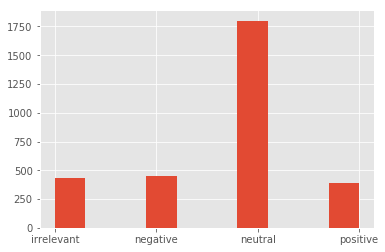

In [5]:
plt.hist(Y_orig);

# Some accuracy tests

In [6]:
np.set_printoptions(precision=20) 

In [7]:
np.array([2.48E-324])

array([  4.94065645841246544177e-324])

In [8]:
np.array([2.47E-324]) # ouch!

array([ 0.])

In [9]:
x = 0.00001

In [10]:
x**64 # still fine

1e-320

In [11]:
x**65 # ouch

0.0

In [12]:
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

# Relationship between probabilities and their logarithm

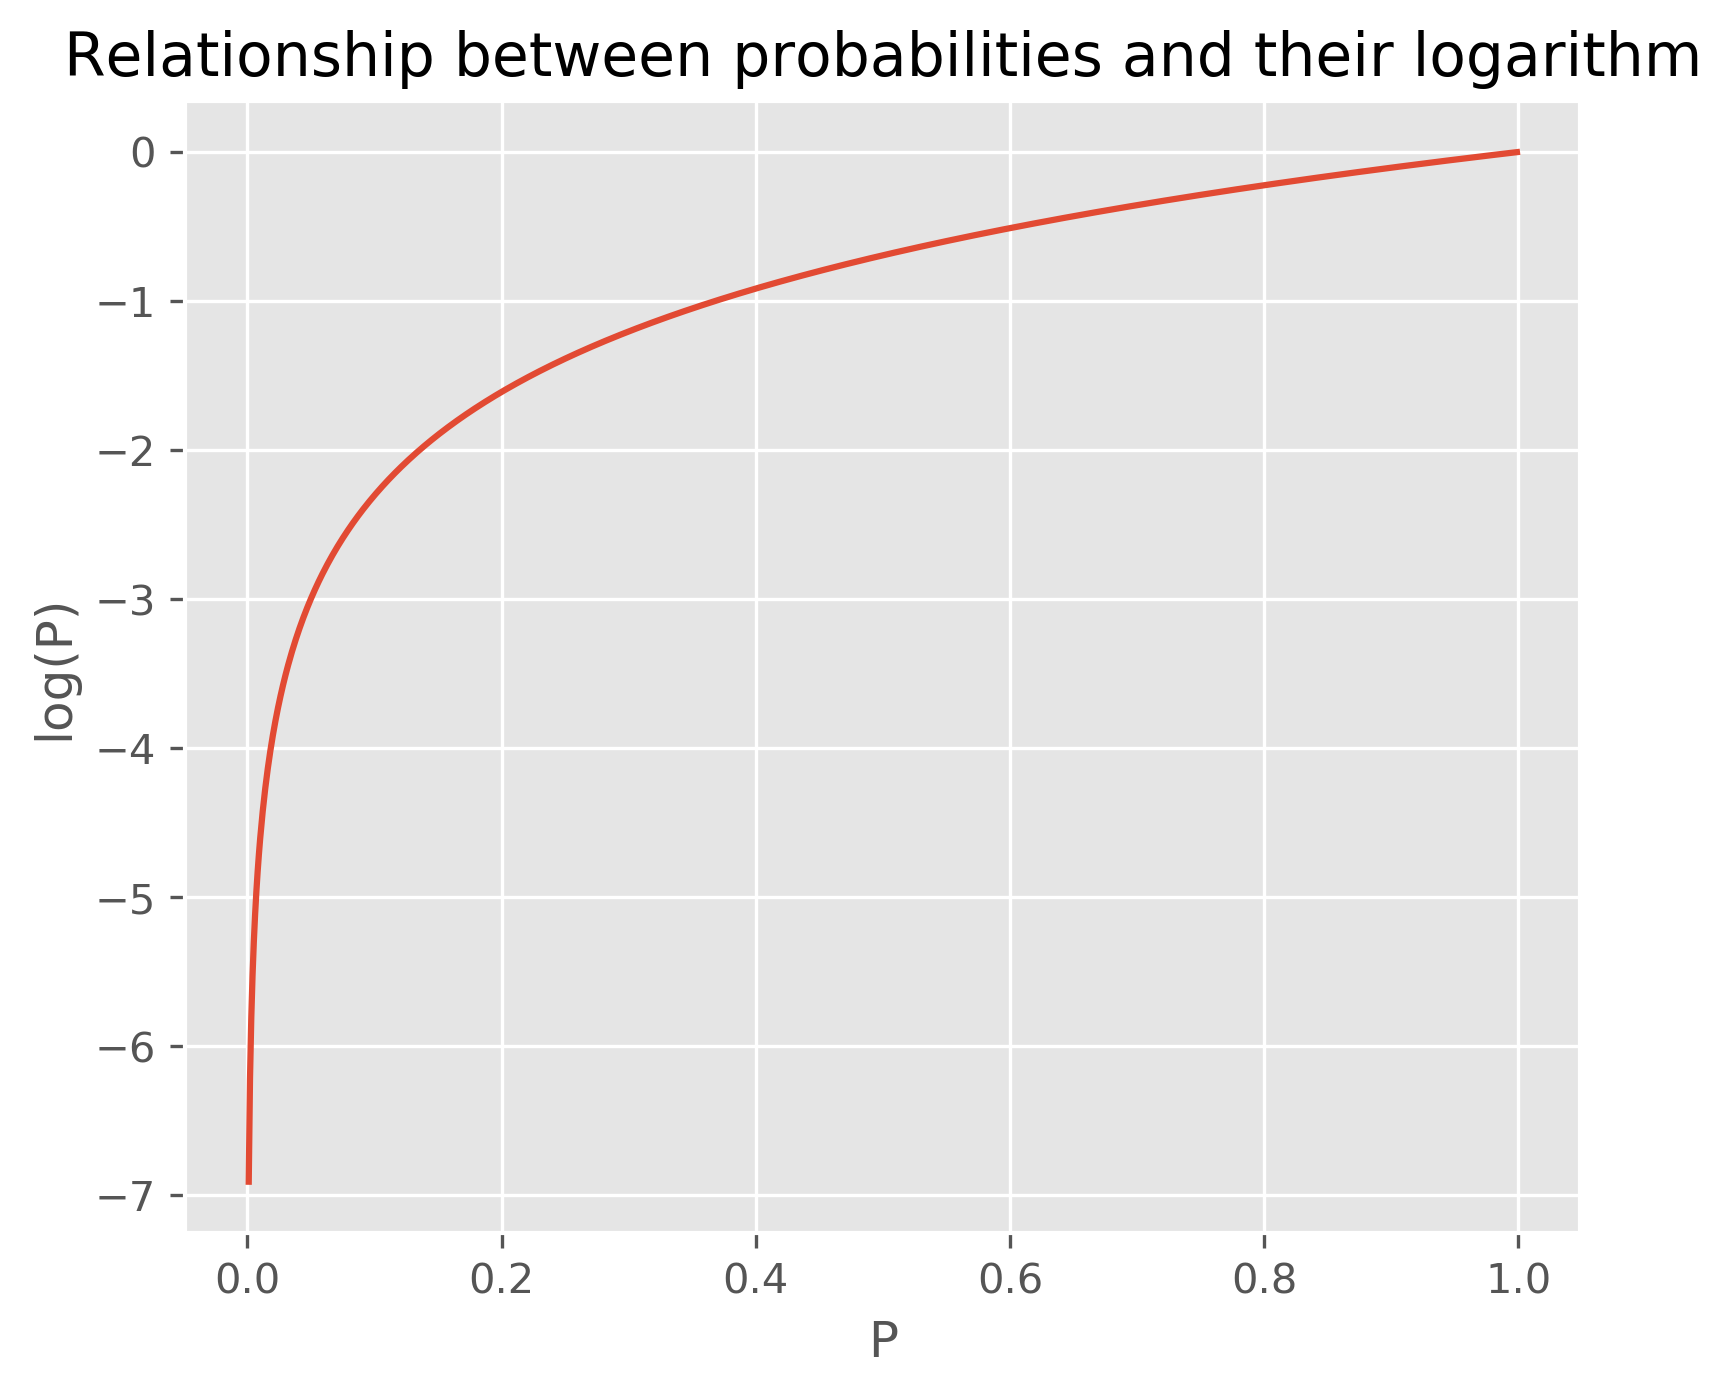

In [13]:
def plot_log():
    plt.clf()
    plt.figure(num=None, figsize=(6, 5), dpi=DPI)

    x = np.arange(0.001, 1, 0.001)
    y = np.log(x)

    plt.title('Relationship between probabilities and their logarithm')
    plt.plot(x, y)
    plt.grid(True)
    plt.xlabel('P')
    plt.ylabel('log(P)')
    filename = 'log_probs.png'
    save_png("0_log")
plot_log()

# Solving an easy problem first

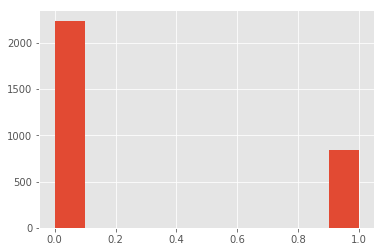

In [14]:
# first create a Boolean list having true for tweets
# that are either positive or negative
pos_neg_idx = np.logical_or(Y_orig=="positive", Y_orig =="negative")
plt.hist(pos_neg_idx);

In [15]:
# now use that index to filter the data and the labels
X = X_orig [pos_neg_idx]
Y = Y_orig [pos_neg_idx]

In [16]:
# finally convert the labels themselves into Boolean
Y = Y=="positive"

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

def create_ngram_model(params=None):
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1, 3), 
                                   analyzer="word", binary=False)
    clf = MultinomialNB()
    pipeline = Pipeline([('tfidf', tfidf_ngrams), ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    return pipeline

In [18]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import ShuffleSplit

def train_model(clf_factory, X, Y, name="NB ngram", plot=None):
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    
    train_errors = []
    test_errors = []

    scores = []
    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for train, test in cv.split(X, Y):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        clf = clf_factory()
        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        precision, recall, pr_thresholds = precision_recall_curve(
            y_test, proba[:, 1])

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

    scores_to_sort = pr_scores
    median = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]

    if plot:
        plot_pr(pr_scores[median], name, precisions[median],
                recalls[median], label=name, plot_nr=plot)

        summary = (np.mean(scores), np.mean(pr_scores))
        print("Mean acc=%.3f\tMean P/R AUC=%.3f" % summary)

    return np.mean(train_errors), np.mean(test_errors)

In [19]:
print("== Pos vs. neg ==")
pos_neg = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg]
Y = Y_orig[pos_neg]
Y = tweak_labels(Y, ["positive"])
print(len(Y_orig), len(Y), len(Y)/len(Y_orig))

== Pos vs. neg ==
3075 838 0.27252032520325203


Mean acc=0.777	Mean P/R AUC=0.887


(0.0020477815699659007, 0.22261904761904763)

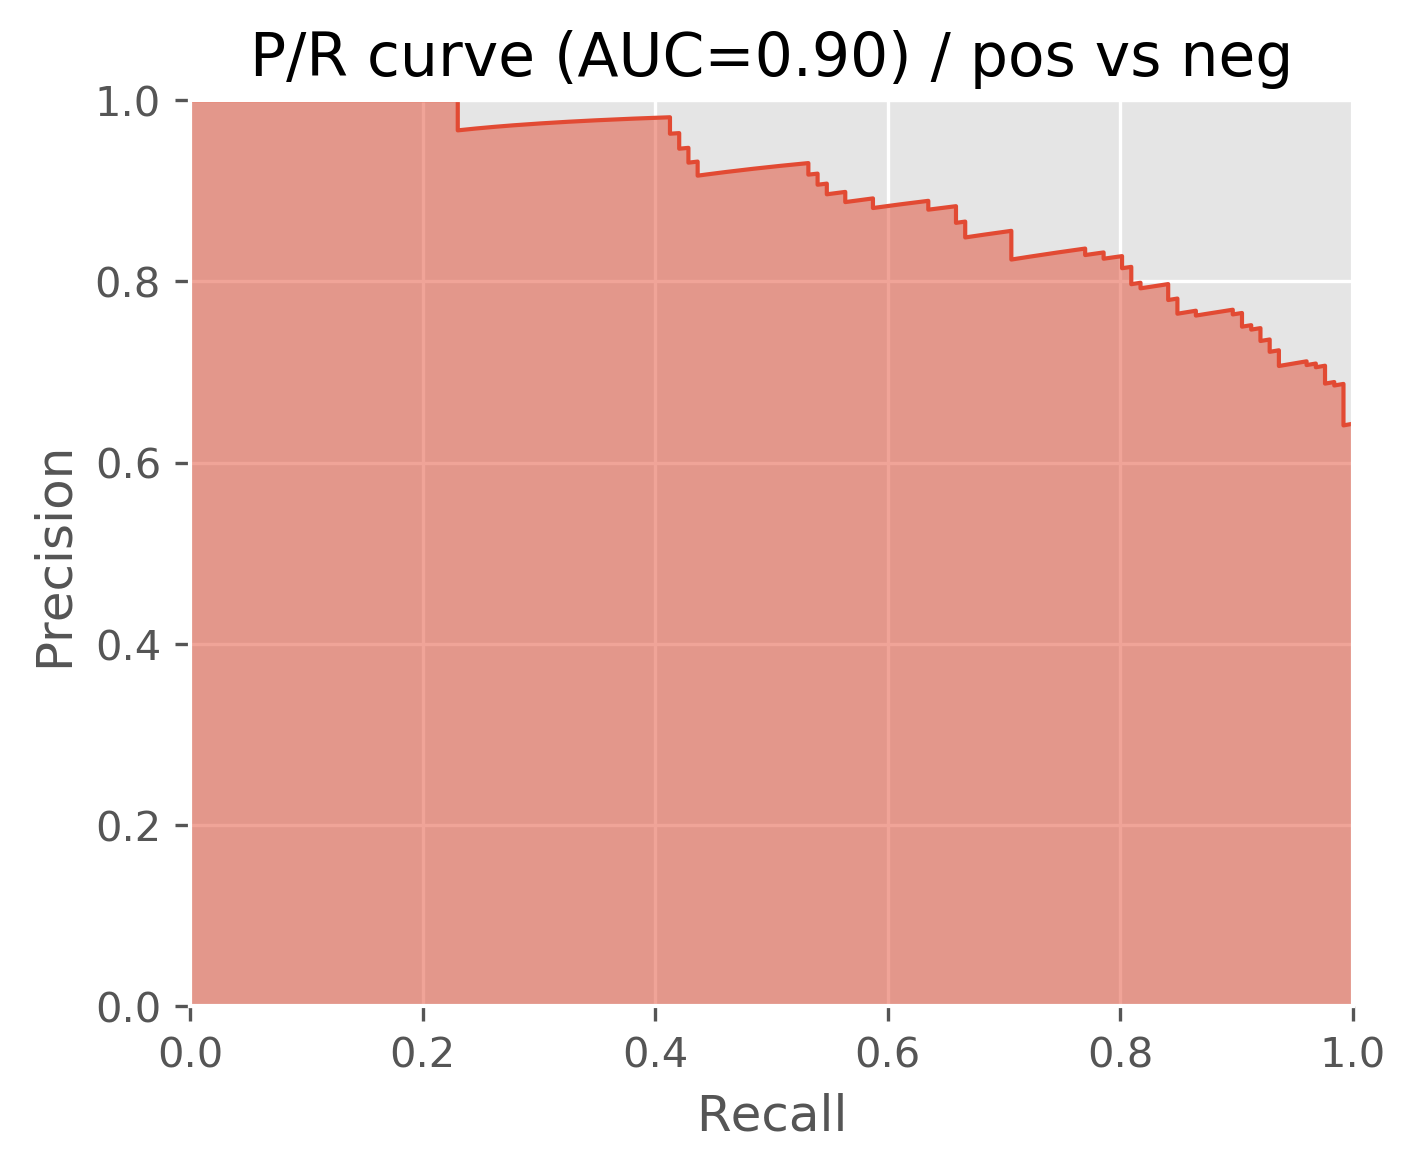

In [20]:
train_model(create_ngram_model, X, Y, name="pos vs neg", plot="1")

# Using all classes

== Pos/neg vs. irrelevant/neutral ==
Mean acc=0.734	Mean P/R AUC=0.661


(0.11226765799256506, 0.26608884073672806)

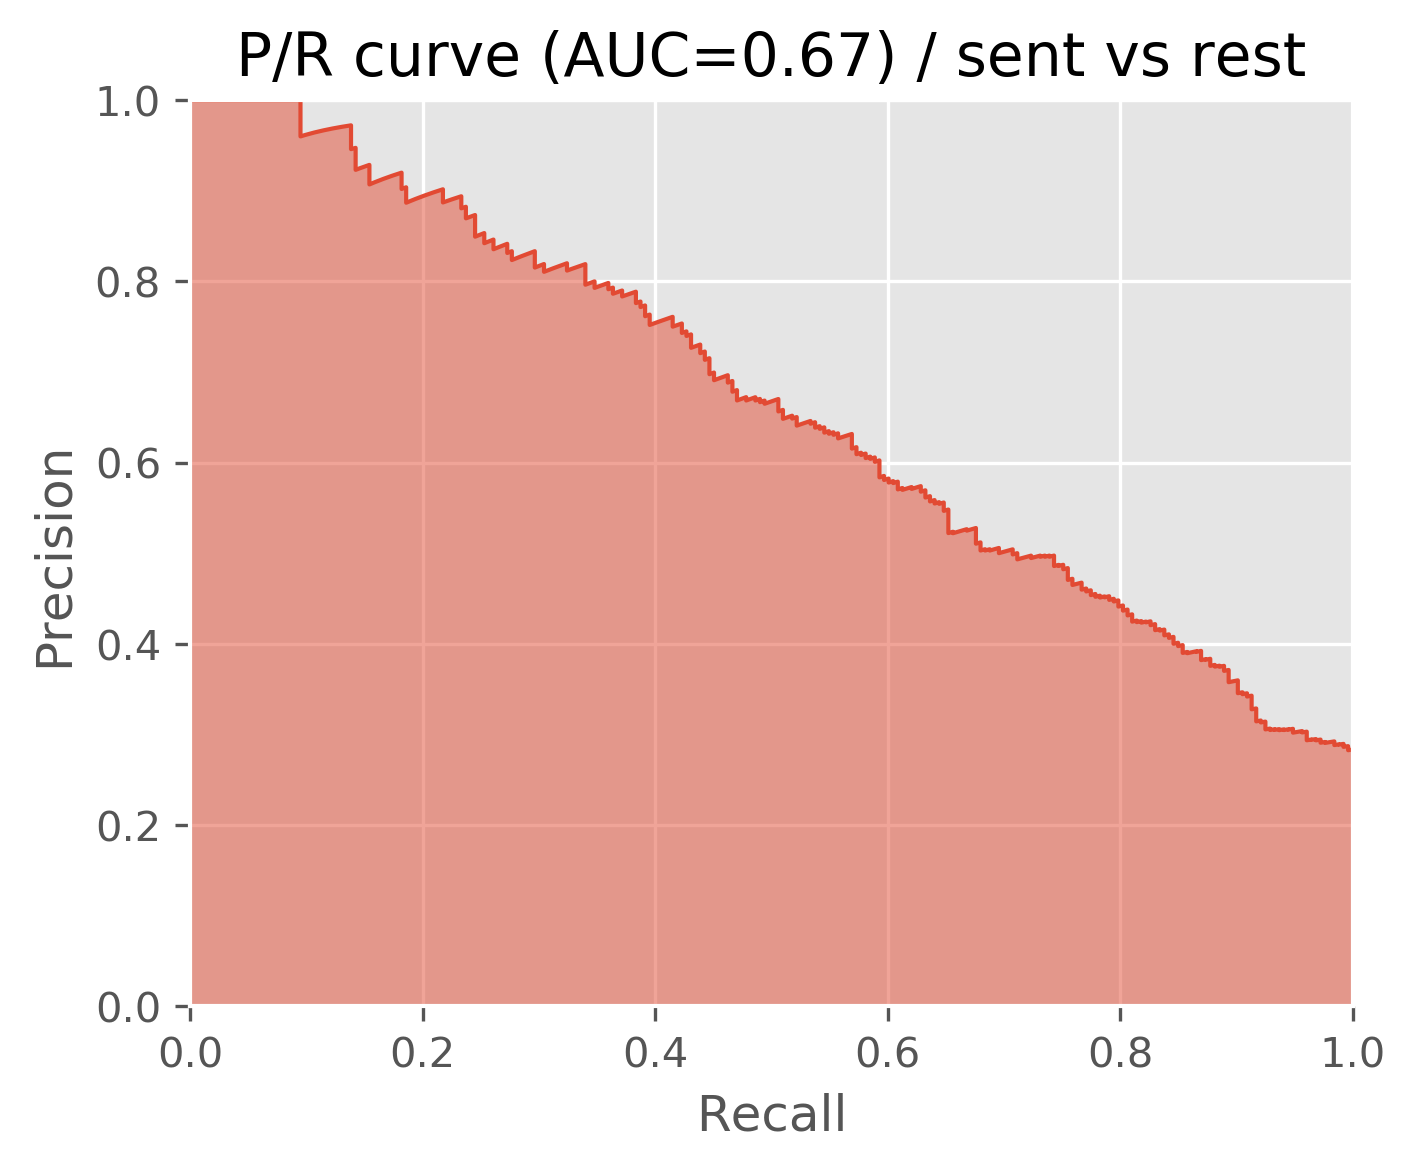

In [21]:
print("== Pos/neg vs. irrelevant/neutral ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
train_model(create_ngram_model, X, Y, name="sent vs rest", plot="2")

== Pos vs. rest ==
Mean acc=0.870	Mean P/R AUC=0.305


(0.12513940520446099, 0.13011917659804983)

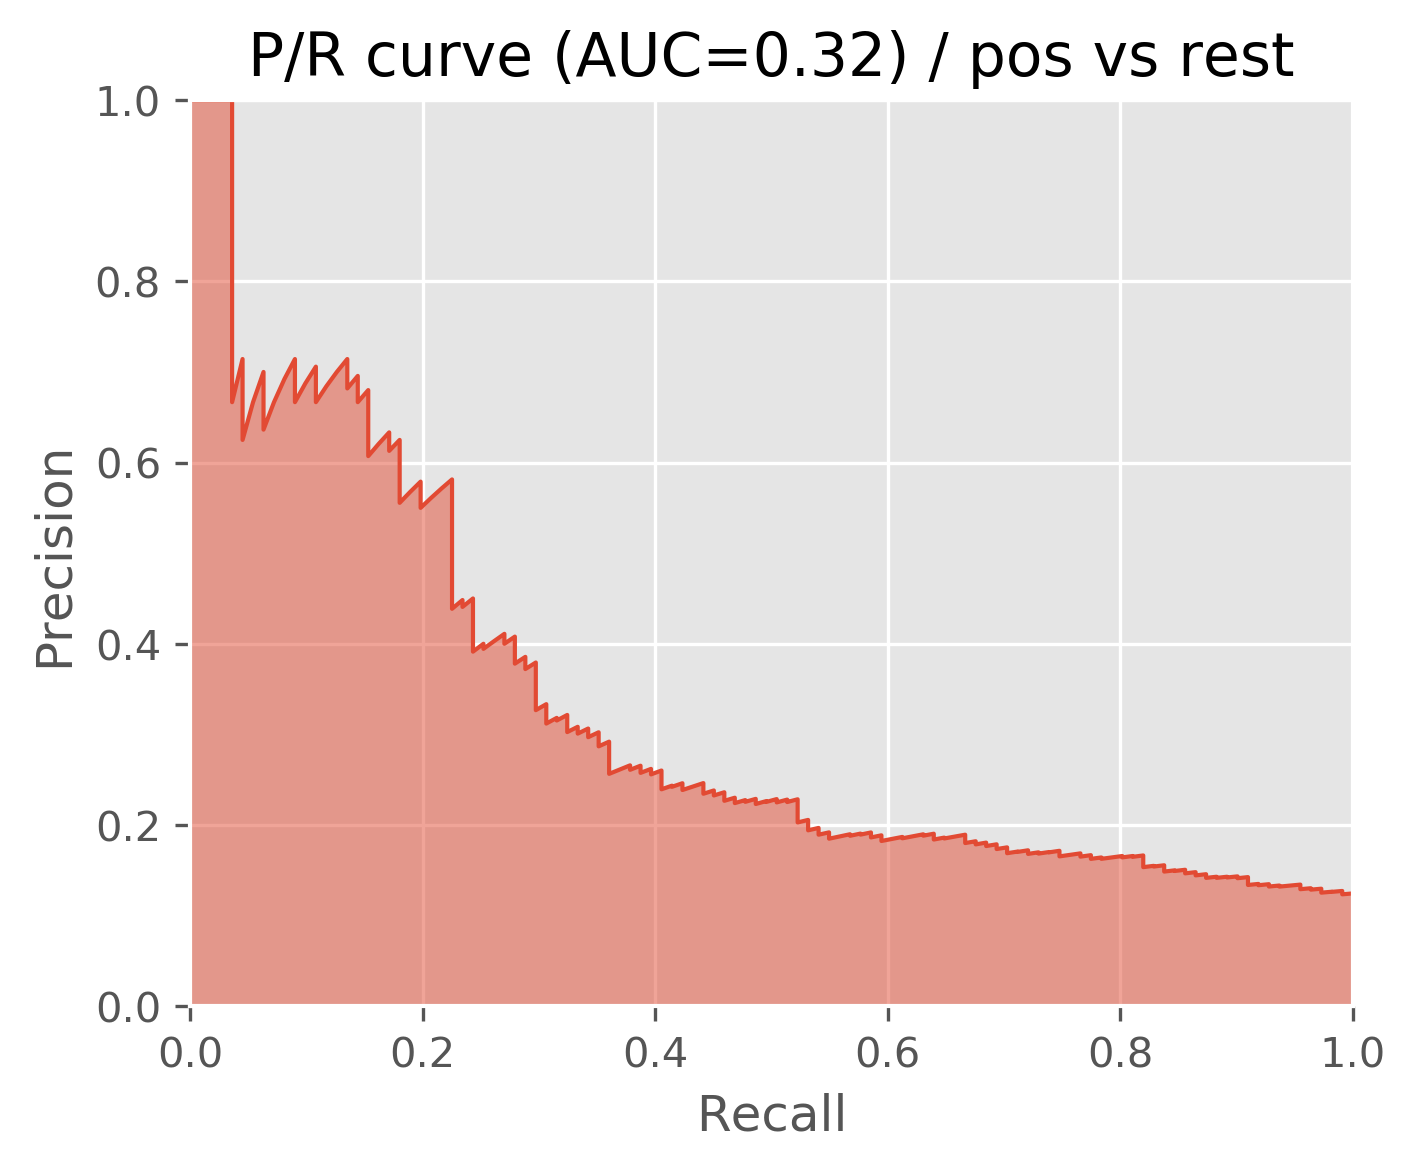

In [22]:
print("== Pos vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])
train_model(create_ngram_model, X, Y, name="pos vs rest", plot="3")

== Neg vs. rest ==
Mean acc=0.852	Mean P/R AUC=0.490


(0.13856877323420075, 0.14756229685807148)

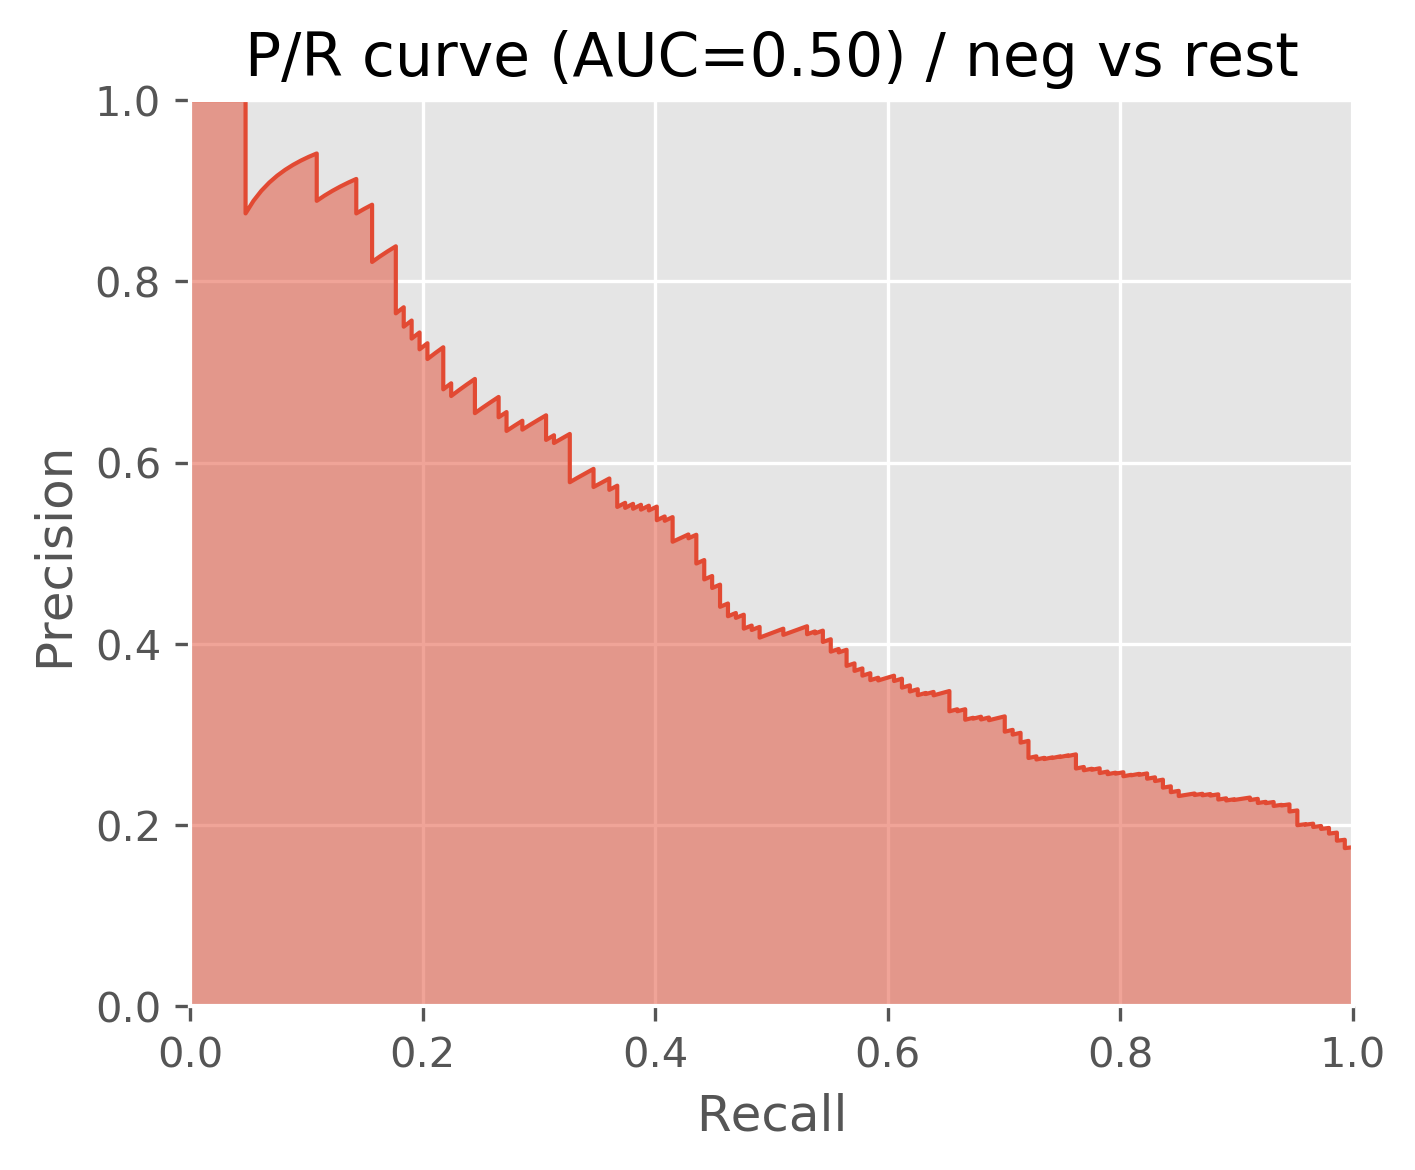

In [23]:
print("== Neg vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])
train_model(create_ngram_model, X, Y, name="neg vs rest", plot="4")

# Grid searching the best classifier

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

def grid_search_model(clf_factory, X, Y):
    cv = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)

    param_grid = dict(tfidf__ngram_range=[(1, 1), (1, 2), (1, 3)],
        tfidf__min_df=[1, 2],
        tfidf__stop_words=[None, "english"],
        tfidf__smooth_idf=[False, True],
        tfidf__use_idf=[False, True],
        tfidf__sublinear_tf=[False, True],
        tfidf__binary=[False, True],
        clf__alpha=[0, 0.01, 0.05, 0.1, 0.5, 1],
        )

    grid_search = GridSearchCV(clf_factory(),
        param_grid=param_grid,
        cv=cv,
        scoring=make_scorer(f1_score),
        verbose=10)
    grid_search.fit(X, Y) 

    return grid_search.best_estimator_

In [28]:
Y = tweak_labels(Y_orig, ["positive", "negative"])
best = grid_search_model(create_ngram_model, X, Y)
print(best)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5010799136069115, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5201793721973095, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5677966101694916, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5622317596566524, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5384615384615385, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5242290748898678, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5115303983228512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.4s remaining:    0.0s


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5685071574642127, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4700665188470067, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5384615384615384, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5245202558635395, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5772

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5575757575757575, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5522682445759369, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5186721991701245, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5786407766990292, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5458089668615984, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5725

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5052192066805846, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4999999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5267857142857143, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.564755838641189, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5396145610278372, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5209713024282562, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5613305613305615, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5115303983228512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5714285714285714, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.46902654867256643, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5432595573440644, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5245202558635395, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5748987854251012, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5575757575757575, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5494071146245059, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5228215767634855, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5797665369649805, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5497076023391813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5736738703339882, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5104602510460251, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5064377682403434, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4943310657596372, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5422993492407808, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5786163522012578, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5435244161358811, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5263157894736842, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5557894736842106, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.528066528066528, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5773195876288658, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.47555555555555556, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5252525252525252, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5010799136069114, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.551440329218107, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5575757575757575, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.536779324055666, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5133470225872689, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.561122244488978, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5514563106796116, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5652173913043478, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49579831932773105, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5107296137339056, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5011286681715575, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5454545454545455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5810526315789474, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5423728813559322, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5263157894736842, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5588235294117647, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.528066528066528, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5802469135802468, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47345132743362833, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.524390243902439, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, s

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5604838709677419, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5309381237524949, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5154639175257731, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.561122244488978, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5486381322957198, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5669291338582677, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.497907949790795, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5010799136069115, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5201793721973095, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5677966101694916, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5622317596566524, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5384615384615385, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5242290748898678, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5613305613305615, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5115303983228512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5685071574642127, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4700665188470067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5406504065040652, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5278969957081545, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5824847250509165, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5604838709677419, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5487077534791251, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5217391304347826, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5813953488372093, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5497076023391813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5686274509803922, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5115303983228512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4999999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5267857142857143, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.564755838641189, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5396145610278372, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5209713024282562, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5613305613305615, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5115303983228512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5714285714285714, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.46902654867256643, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5436105476673427, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5278969957081545, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5784114052953157, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5593561368209257, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5487077534791251, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.525879917184265, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5825242718446602, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5468749999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5725490196078431, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5084033613445379, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5064377682403434, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4943310657596372, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5422993492407808, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5786163522012578, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5435244161358811, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5263157894736842, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5557894736842106, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.528066528066528, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5773195876288658, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.47555555555555556, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5284552845528455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5021834061135371, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5532786885245903, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5622489959839357, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5396825396825397, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5254582484725051, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5617529880478087, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5447470817120622, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5680473372781066, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5031446540880503, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5107296137339056, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5011286681715575, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5454545454545455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5810526315789474, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5423728813559322, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5263157894736842, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5588235294117647, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.528066528066528, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5802469135802468, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47345132743362833, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5295315682281059, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5021834061135371, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5532786885245903, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.564, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5357142857142857, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5265306122448979, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5617529880478087, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5486381322957198, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5697445972495089, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5020920502092051, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5290322580645161, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5069124423963134, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5738396624472574, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5756929637526652, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5809128630705395, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5658747300215983, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5539714867617109, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5725971370143149, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5872340425531916, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5186813186813187, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5439330543933054, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.504424778761062, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5841784989858012, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5491803278688525, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5697211155378487, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.562367864693446, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5573122529644269, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5769980506822612, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5714285714285714, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5316455696202532, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5290322580645161, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5069124423963134, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5738396624472574, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576923076923077, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5779625779625779, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5658747300215983, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5528455284552846, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.569672131147541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5859872611464968, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5175438596491228, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5397489539748954, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.504424778761062, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5841784989858012, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5491803278688525, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5691382765531062, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.562367864693446, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5584158415841584, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.578125, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5714285714285714, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5316455696202532, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5316455696202531, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5599999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576271186440678, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=F

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5507246376811595, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5695931477516061, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5548654244306418, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5640000000000001, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5369978858350952, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5370741482965932, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5021645021645023, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5696969696969697, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5578512396694215, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5443786982248521, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5546218487394958, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5627376425855513, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.589430894308943, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5394190871369294, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5316455696202531, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5055432372505543, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5599999999999999, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5744680851063829, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5477178423236515, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5659574468085107, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5548654244306418, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5640000000000001, total=   0.5s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5970772442588727, total=   0.6s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5369978858350952, total=   0.4s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5410821643286573, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5021645021645023, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5668016194331984, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5567010309278351, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5386138613861386, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5534591194968552, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5652173913043479, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5616698292220114, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.589430894308943, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5413223140495868, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5290322580645161, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5069124423963134, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5738396624472574, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5756929637526652, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5809128630705395, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5658747300215983, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5539714867617109, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5725971370143149, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5872340425531916, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5186813186813187, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5450733752620545, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5877551020408163, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5532786885245903, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5766129032258065, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5654008438818566, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5573122529644269, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.579256360078278, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5767634854771784, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.53276955602537, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5290322580645161, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5069124423963134, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5738396624472574, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576923076923077, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5779625779625779, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5658747300215983, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5528455284552846, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.569672131147541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5859872611464968, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5175438596491228, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5439330543933054, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5011086474501107, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5865580448065173, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5532786885245903, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5766129032258065, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5684210526315788, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5584158415841584, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.579256360078278, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5767634854771784, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.53276955602537, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5316455696202531, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5055432372505543, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5599999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576271186440678, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5507246376811595, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5695931477516061, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5640000000000001, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5970772442588727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5369978858350952, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5410821643286573, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, s

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5696969696969697, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5603271983640081, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5396825396825397, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5590551181102362, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5643939393939394, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5934959349593496, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5424430641821946, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5316455696202531, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5055432372505543, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5599999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5744680851063829, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5659574468085107, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5548654244306418, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5640000000000001, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5970772442588727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5369978858350952, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5450901803607214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5021645021645023, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5696969696969697, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5591836734693878, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5396825396825397, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5553235908141962, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5618860510805501, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5633270321361059, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5934959349593496, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5443298969072164, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5301724137931034, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4897025171624715, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5654008438818565, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5610278372591007, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5708333333333333, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5782608695652173, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5510204081632654, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5731707317073171, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5875, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5120350109409191, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5408805031446542, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4900662251655629, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5731958762886598, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5360824742268041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5656565656565657, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5726315789473685, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5555555555555556, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5625, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5789473684210527, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5316455696202532, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5301724137931034, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49082568807339455, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5654008438818565, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5610278372591007, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5678496868475992, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5782608695652173, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5487804878048782, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5731707317073171, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5862785862785862, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5120350109409191, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5366876310272538, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4911504424778761, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5731958762886598, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5360824742268041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.562753036437247, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5726315789473685, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5566600397614315, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5625, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5789473684210527, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5316455696202532, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5276595744680851, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5625, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.55863539445629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5355648535564854, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.559322033898305, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5560165975103735, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5697211155378487, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5945945945945945, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.538135593220339, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5273833671399594, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49344978165938863, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5679513184584178, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5352697095435685, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5378486055776892, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5488565488565489, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5702970297029702, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5643939393939394, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5939393939393939, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5413223140495868, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5276595744680851, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5625, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5555555555555556, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5355648535564854, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5581395348837209, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5560165975103735, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5697211155378487, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5945945945945945, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.538135593220339, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5273833671399594, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4945295404814004, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5650406504065041, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5341614906832298, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5338645418326693, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5488565488565489, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5714285714285714, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5633270321361059, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5927419354838709, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5454545454545453, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5301724137931034, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4897025171624715, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5654008438818565, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5610278372591007, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5708333333333333, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5782608695652173, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5510204081632654, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5731707317073171, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5875, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5120350109409191, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.542016806722689, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4879120879120879, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5720164609053499, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5420944558521561, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5691056910569106, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5768421052631578, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5533596837944663, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5625, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5813008130081301, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5274261603375527, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5301724137931034, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49082568807339455, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5654008438818565, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5610278372591007, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5678496868475992, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5782608695652173, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5487804878048782, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5731707317073171, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5862785862785862, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5120350109409191, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.542016806722689, total=   0.5s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4889867841409692, total=   0.4s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5720164609053499, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5420944558521561, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5691056910569106, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5768421052631578, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5544554455445544, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5625, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5813008130081301, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5285412262156448, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5276595744680851, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5625, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.55863539445629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5355648535564854, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.559322033898305, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5560165975103735, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5697211155378487, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5945945945945945, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.538135593220339, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5336048879837066, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4945295404814004, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5748987854251012, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5409836065573771, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.536779324055666, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5507246376811594, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5652173913043479, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5660377358490565, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5951417004048584, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5454545454545453, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5276595744680851, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5625, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5555555555555556, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5355648535564854, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5581395348837209, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5560165975103735, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5697211155378487, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5945945945945945, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.538135593220339, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.532520325203252, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4945295404814004, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5720081135902637, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5439672801635991, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.536779324055666, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5507246376811594, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5663366336633663, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5649717514124295, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5939393939393939, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5473251028806585, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4703196347031964, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5393794749403341, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5291479820627804, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5299539170506913, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5356371490280778, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5388127853881278, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5386313465783663, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4867256637168141, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5726495726495727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48888888888888893, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4669603524229075, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.53

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5501066098081023, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5526315789473684, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5405

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.54389721627409, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5496828752642707, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5123966942148761, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5555555555555555, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4946

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5380952380952381, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5258426966292135, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5287356321839081, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5336225596529284, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5388127853881278, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5362637362637362, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4933920704845816, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5769230769230769, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48888888888888893, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.46153846153846156, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.532110

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5496828752642705, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5494505494505495, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.540540540

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5450643776824035, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5492662473794548, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.515463917

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5562372188139059, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4957627118644068, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.46009389671361506, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48623853211009177, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5229357798165137, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5238095238095238, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5515695067264573, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.

[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5010989010989011, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5664488017429193, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5249457700650759, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5414847161572053, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5417515274949083, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5488565488565489, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49159663865546216, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fal

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4975609756097561, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48735632183908045, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fal

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5217391304347827, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5470852017937219, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4999999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5708061002178649, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4742729306487696, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49882352941176467, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, s

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5394736842105263, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5417515274949083, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.540084388185654, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5333333333333334, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5247933884297521, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5507246376811593, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49475890985324944, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4703196347031964, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5393794749403341, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5291479820627804, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5299539170506913, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5356371490280778, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5388

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5386313465783663, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4867256637168141, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5726495726495727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48888888888888893, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.467991169977925, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.53793103

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5526315789473684, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5416666666666666, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5493562231759656, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5496828752642707, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5155925155925156, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5567010309278351, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.497854077253219, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4622425629290618, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5380952380952381, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5258426966292135, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5287356321839081, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5336225596529284, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.538812785

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5769230769230769, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48888888888888893, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4625550660792952, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.536697247706422, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5531914893617021, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5494505494505495, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5375, total=  

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5492662473794548, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5103734439834026, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5567010309278351, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.46009389671361506, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48623853211009177, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5229357798165137, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5238095238095238, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5515695067264573, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5010989010989011, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5664488017429193, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48660714285714285, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4719101123595506, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5035294117647059, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5238095238095238, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.538293216630197, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5428571428571428, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5435244161358811, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5333333333333334, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5499999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49684210526315786, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, s

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4975609756097561, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48735632183908045, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5265588914549654, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5217391304347827, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5470852017937219, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5279642058165548, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4999999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48660714285714285, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4695259593679458, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5281385281385282, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5394736842105263, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5417515274949083, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5431578947368421, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5333333333333334, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5269709543568464, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5530145530145529, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49684210526315786, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4978165938864629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5393794749403341, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5426695842450766, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5482456140350876, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5481798715203425, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5555555555555556, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.542016806722689, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.543103448275862, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5738758029978587, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49673202614379086, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5105485232067511, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5412844036697247, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5515789473684212, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5504201680672269, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5469728601252609, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5379876796714579, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5726141078838175, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5743801652892562, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5020920502092051, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4945295404814004, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5419664268585132, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5458515283842794, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5438

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5493562231759657, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5511111111111111, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5443037974683544, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5493562231759657, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.575107296137339, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5042372881355932, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5379310344827586, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.550420168

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.549266247379455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5481171548117154, total=   0.0s


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5338809034907598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5726141078838175, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5743801652892562, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5052192066805846, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.484304932735426, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48931116389548696, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5193133047210301, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5304347826086957, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5438972162740899, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5745140388768899, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5128205128205129, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5299145299145298, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5919661733615221, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5431578947368421, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.48717948717948717, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4919540229885057, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5387755102040817, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5269709543568465, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5306122448979592, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5720164609053499, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5300207039337475, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5691382765531062, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5344129554655871, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4832214765100671, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49047619047619045, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5170940170940171, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5324675324675325, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5458422174840085, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5720430107526882, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.511727078891258, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5330490405117271, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5907172995780591, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4818763326226013, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4919540229885057, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5417515274949084, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.528066528066528, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5336048879837068, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5731958762886598, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5311203319502076, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5502008032128514, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.567404426559356, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5354969574036512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4978165938864629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5393794749403341, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5426695842450766, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5482456140350876, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5481798715203425, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5555555555555556, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.542016806722689, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.543103448275862, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5738758029978587, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49673202614379086, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5063291139240507, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5412844036697247, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5546218487394957, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5504201680672269, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5481171548117154, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5634408602150537, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5322245322245321, total=   0.1s


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.575, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5726141078838174, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5031446540880503, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4945295404814004, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5419664268585132, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5458515283842794, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.543859649122807, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5493562231759657, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5511111111111111, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5443037974683544, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5493562231759657, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.575107296137339, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5031712473572939, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5379310344827586, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5523012552301255, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.549266247379455, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5481171548117154, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5622317596566524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5330578512396694, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.57380457380457

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5755693581780539, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5052192066805846, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.484304932735426, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48931116389548696, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5193133047210301, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5304347826086957, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5438972162740899, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5745140388768899, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5128205128205129, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5299145299145298, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5919661733615221, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5431578947368421, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True,

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4942263279445728, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5387755102040817, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5249999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5306122448979592, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5702479338842976, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5300207039337475, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5494949494949495, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.579476861167002, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5344129554655871, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4832214765100671, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49047619047619045, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5170940170940171, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5324675324675325, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5458422174840085, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5720430107526882, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.511727078891258, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5330490405117271, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5907172995780591, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5450733752620546, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4861407249466951, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4919540229885057, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5428571428571428, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.528066528066528, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5336048879837068, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5702479338842976, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5352697095435683, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5483870967741935, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5766129032258065, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5106382978723404, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5377358490566038, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5617021276595745, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5477707006369427, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5574468085106382, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5577342047930283, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5525773195876289, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5606694560669456, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5696202531645569, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.510548523206751, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5195876288659793, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5327313769751693, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5637860082304527, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5432098765432098, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5454545454545455, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.570230607966457, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.534412955465587, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5760649087221095, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.569672131147541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5060728744939271, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.505307855626327, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5342789598108748, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5617021276595745, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5466101694915255, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5574468085106382, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5577342047930283, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5514403292181069, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5606694560669456, total=   0.3s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5696202531645569, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5116279069767442, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5165289256198347, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5327313769751693, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5608247422680412, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5432098765432098, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5424430641821947, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5732217573221757, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.539553752535497, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5772357723577236, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.569672131147541, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5090909090909091, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48684210526315785, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48095238095238096, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5252100840336135, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5232067510548524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5496828752642706, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5803757828810021, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5300207039337475, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5324947589098533, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5887265135699373, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5503080082135524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49579831932773105, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.48623853211009177, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5490981963927856, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5215605749486651, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5359999999999999, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5748987854251012, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5461847389558232, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5646123260437376, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5759368836291914, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5375494071146244, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4857768052516411, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47980997624703087, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5252100840336135, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5232067510548524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5496828752642706, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5774058577405857, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5278350515463918, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5333333333333334, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.587991718426501, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5503080082135524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49895178197064993, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4885844748858448, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5450901803607213, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5215605749486651, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5370741482965932, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5737373737373737, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5461847389558232, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5617529880478087, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5787401574803149, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5404339250493098, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5106382978723404, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5377358490566038, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5617021276595745, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5477707006369427, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5574468085106382, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5577342047930283, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5525773195876289, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5606694560669456, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5696202531645569, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.510548523206751, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5195876288659793, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5327313769751693, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5702479338842975, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5432098765432098, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.546583850931677, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5672268907563024, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5354969574036511, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5748987854251012, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.569672131147541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5020408163265307, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.505307855626327, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5342789598108748, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5617021276595745, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5466101694915255, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5574468085106382, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5577342047930283, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5514403292181069, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5606694560669456, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5696202531645569, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5116279069767442, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5165289256198347, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5327313769751693, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.566115702479339, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5432098765432098, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5435684647302904, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.570230607966457, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5406504065040649, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5760649087221095, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5667351129363449, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5101214574898785, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48684210526315785, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48095238095238096, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5252100840336135, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5232067510548524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5496828752642706, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5803757828810021, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5300207039337475, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5324947589098533, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5887265135699373, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5503080082135524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49895178197064993, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.48735632183908045, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5490981963927856, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5215605749486651, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.54, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5737373737373737, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5443548387096775, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5646123260437376, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5849802371541503, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5386138613861385, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4857768052516411, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47980997624703087, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5252100840336135, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5232067510548524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5496828752642706, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5774058577405857, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5278350515463918, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5333333333333334, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.587991718426501, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5503080082135524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49790794979079506, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.48623853211009177, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5450901803607213, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5226337448559671, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.54, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5720081135902637, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5443548387096775, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5617529880478087, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5889328063241107, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.541501976284585, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5096359743040685, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5256124721603563, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5628997867803838, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5347368421052632, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.530701754385965, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5553235908141962, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.51260

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5743380855397149, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4700665188470067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5432595573440644, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5316455696202532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5725806451612904, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5524193548387096, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5422396856581532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5269709543568465, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5786407766990292, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5497076023391813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5764705882352942, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.505175983436853, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5096359743040685, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5256124721603563, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.562899786

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5347368421052632, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.530701754

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5553235908141962, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5126050420168067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5743380855397149, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4700665188470067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.54325955734

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5316455696202532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5725806451612904, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5524193548387096, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5422396856581532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5269709543568465, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5786407766990292, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5497076023391813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5764705882352942, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.505175983436853, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5139186295503212, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5123595505617978, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5466377440347071, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5423728813559322, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.531590413943355, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5322245322245323, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5807770961145194, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.47577092511013214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.535496957403651, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5159914712153517, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5480572597137015, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.563380281690141, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5267326732673268, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5226337448559671, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.562874251497006, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, sco

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5675146771037182, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.505175983436853, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5139186295503212, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5123595505617978, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5466377440347071, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.531590413943355, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5606694560669455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5322245322245323, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5807770961145194, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47577092511013214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.535496957403651, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5159914712153517, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5480572597137015, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.563380281690141, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5267326732673268, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5226337448559671, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.562874251497006, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5514563106796116, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5675146771037182, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.505175983436853, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5096359743040685, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5256124721603563, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5628997867803838, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5347368421052632, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.530701754385965, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5553235908141962, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5126050420168067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5743380855397149, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4700665188470067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5447154471544715, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5361702127659573, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5725806451612904, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5593561368209257, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5396825396825397, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5319587628865979, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5852713178294573, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.55294117647058

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.578125, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5093167701863354, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5096359743040685, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5256124721603563, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5628997867803838, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5610278372591007, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5347368421052632, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.530701754385965, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5553235908141962, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5126050420168067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5743380855397149, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4700665188470067, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5447154471544715, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5361702127659573, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5725806451612904, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5593561368209257, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5396825396825397, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5319587628865979, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5852713178294573, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5529411764705883, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.578125, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5093167701863354, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5139186295503212, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5123595505617978, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5466377440347071, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5792811839323467, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5423728813559322, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.531590413943355, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5606694560669455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5322245322245323, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.47577092511013214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5336048879837066, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5119305856832972, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5539714867617107, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.562874251497006, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5304518664047152, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5306122448979592, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5606361829025844, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5531914893617021, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5725490196078431, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5062240663900416, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5123595505617978, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5466377440347071, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5423728813559322, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.531590413943355, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5606694560669455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5322245322245323, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5807770961145194, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47577092511013214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5336048879837066, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5119305856832972, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5539

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5304518664047152, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5306122448979592, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5606361829025844, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5531914893617021, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5725490196078431, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5062240663900416, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5353319057815845, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5056947608200455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576271186440678, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576923076923077, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5755693581780538, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5652173913043479, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5487804878048782, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5708418891170431, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5949367088607596, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5217391304347827, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5458333333333333, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5077262693156733, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5841784989858012, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5480572597137015, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5651302605210421, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.559322033898305, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5612648221343873, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.574757281553398, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5802469135802468, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5324947589098532, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5353319057815845, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5056947608200455, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576271186440678, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576923076923077, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5755693581780538, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5652173913043479, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5487804878048782, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5708418891170431, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5949367088607596, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5217391304347827, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5458333333333333, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5077262693156733, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5841784989858012, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5480572597137015, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5651302605210421, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.559322033898305, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5612648221343873, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.574757281553398, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5802469135802468, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5324947589098532, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.53276955602537, total=   0.0s


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5055432372505543, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5660377358490566, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576271186440678, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.546583850931677, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5677966101694915, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5567010309278351, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5612648221343873, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5945945945945945, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5358649789029535, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.54, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5010799136069114, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5679513184584178, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5580448065173116, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5343811394891944, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5523012552301255, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5691699604743083, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5601503759398495, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.585858585858586, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5402061855670104, total=   0.0s

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.53276955602537, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5055432372505543, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5660377358490566, total=   0.0s


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576271186440678, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.546583850931677, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5677966101694915, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5567010309278351, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5612648221343873, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5358649789029535, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.54, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5010799136069114, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5679513184584178, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5580448065173116, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5343811394891944, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5691699604743083, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5601503759398495, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.585858585858586, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5402061855670104, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5353319057815845, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5056947608200455, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576271186440678, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576923076923077, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5755693581780538, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5652173913043479, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5487804878048782, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5708418891170431, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5949367088607596, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5217391304347827, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.55, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5022026431718061, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5853658536585366, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5503080082135524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5725806451612904, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5665961945031712, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5612648221343873, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.574757281553398, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5855670103092784, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5324947589098532, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5353319057815845, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5056947608200455, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576271186440678, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576923076923077, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5755693581780538, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5652173913043479, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5487804878048782, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5708418891170431, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5949367088607596, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5217391304347827, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.55, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5022026431718061, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5853658536585366, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5503080082135524, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5725806451612904, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5665961945031712, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5612648221343873, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.574757281553398, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5855670103092784, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5324947589098532, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.53276955602537, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5055432372505543, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5660377358490566, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576271186440678, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.546583850931677, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, scor

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5567010309278351, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5612648221343873, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5945945945945945, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5358649789029535, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5469061876247505, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5010799136069114, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5708502024291497, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5645161290322581, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5404339250493098, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.553014553014553, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5641025641025641, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5639097744360901, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.54320987654321, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.53276955602537, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5055432372505543, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5660377358490566, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576271186440678, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.546583850931677, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5677966101694915, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5567010309278351, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5612648221343873, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5945945945945945, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5358649789029535, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5469061876247505, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.501

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5708502024291497, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5645161290322581, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5404339250493098, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.553014553014553, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5641025641025641, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5639097744360901, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5898

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.54320987654321, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5301724137931034, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49090909090909085, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5665961945031712, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5641025641025641, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5666666666666665, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5726681127982646, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5469387755102041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5743380855397148, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5921325051759834, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5130434782608696, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5397489539748954, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49339207048458145, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5731958762886598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5360824742268041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5598377281947262, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5714285714285714, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5595238095238095, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5592233009708738, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5846774193548387, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5313807531380753, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5301724137931034, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49090909090909085, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5665961945031712, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5641025641025641, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5666666666666665, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5726681127982646, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5469387755102041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5743380855397148, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5921325051759834, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5130434782608696, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5397489539748954, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49339207048458145, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5731958762886598, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5360824742268041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5598377281947262, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5714285714285714, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5595238095238095, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5592233009708738, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5846774193548387, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5313807531380753, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5245202558635393, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5654885654885655, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5550847457627118, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5344467640918581, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5635593220338984, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5578512396694215, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5686274509803921, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5921325051759834, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5358649789029535, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5263157894736843, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49344978165938863, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5661914460285133, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5368852459016394, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5306930693069307, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5488565488565489, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5714285714285714, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5617977528089887, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5891783567134269, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.54320987654321, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5245202558635393, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5654885654885655, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5550847457627118, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5344467640918581, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5635593220338984, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5578512396694215, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5686274509803921, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5921325051759834, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5358649789029535, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5263157894736843, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49344978165938863, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5661914460285133, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5368852459016394, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5306930693069307, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5488565488565489, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5714285714285714, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5617977528089887, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5891783567134269, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.54320987654321, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5301724137931034, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49090909090909085, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5665961945031712, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5641025641025641, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5666666666666665, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5726681127982646, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5469387755102041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5743380855397148, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5921325051759834, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5130434782608696, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5439330543933054, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49122807017543857, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5720164609053499, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5402061855670103, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5644171779141104, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5726315789473685, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5544554455445544, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.558139534883721, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5870445344129555, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5283018867924527, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5301724137931034, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49090909090909085, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5665961945031712, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5641025641025641, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5666666666666665, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5726681127982646, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5469387755102041, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5743380855397148, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5921325051759834, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5130434782608696, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5439330543933054, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49122807017543857, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5720164609053499, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5402061855670103, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5644171779141104, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5726315789473685, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5544554455445544, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.558139534883721, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5870445344129555, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5283018867924527, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5245202558635393, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5654885654885655, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5550847457627118, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5344467640918581, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5635593220338984, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5578512396694215, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5686274509803921, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5921325051759834, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5358649789029535, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5292929292929293, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49344978165938863, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5720081135902637, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5476673427991886, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5357142857142857, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5495867768595041, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5680473372781065, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5644859813084112, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5903614457831324, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5450819672131147, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5245202558635393, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4955357142857143, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5654885654885655, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5550847457627118, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5344467640918581, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5635593220338984, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5578512396694215, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5686274509803921, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5921325051759834, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5358649789029535, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5292929292929293, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49344978165938863, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5720081135902637, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5476673427991886, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5357142857142857, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5495867768595041, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5680473372781065, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5644859813084112, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5903614457831324, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5450819672131147, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.463302752293578, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5227272727272727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5336225596529284, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5400

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5683760683760685, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48337028824833705, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4682713347921225, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5308924485125858, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5562632696390658, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5494505494505495, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5355648535564854, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5462365591397849, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.542372881

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5206611570247933, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5537190082644627, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4840764331210191, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.463302752293578, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5227272727272727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5336225596529284, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.540045766

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5374449339207048, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5130434782608696, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5683760683760685, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48337028824833705, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4682713347921225, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5308924485125858, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5562632696390658, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5494505494505495, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.53556485355648

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5462365591397849, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5423728813559323, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5206611570247933, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5537190082644627, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4840764331210191, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.45901639344262296, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49509803921568624, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49308755760368655, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fa

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.

[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5226781857451404, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5393258426966291, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4912280701754386, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5695652173913044, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4604966139954853, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.531317494600432, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5374449339207048, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5387755102040817, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5527426160337554, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5364806866952789, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5368852459016394, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.45901639344262296, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49509803921568624, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49308755760368655, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5345622119815668, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5226781857451404, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5393258426966291, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4912280701754386, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5695652173913044, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48552338530066813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4604966139954853, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.531317494600432, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5374449339207048, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5387755102040817, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5527426160337554, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5364806866952789, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5368852459016394, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5473251028806584, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5010526315789474, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.463302752293578, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5227272727272727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5336225596529284, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.540045766590389, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5374449339207048, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5130434782608696, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5683760683760685, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48337028824833705, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4682713347921225, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.530892448512

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5494505494505495, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5355648535564854, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5517241379310345, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5443037974683544, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5197505197505198, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5548654244306418, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4925690021231422, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.463302752293578, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5227272727272727, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5333333333333333, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5336225596529284, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.540045766590389, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5374449339207048, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.513043478260869

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48337028824833705, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4682713347921225, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5308924485125858, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.553648068669528, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5494505494505495, to

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.

[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5355648535564854, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5517241379310345, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5443037974683544, t

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5548654244306418, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4925690021231422, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.459016393

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49509803921568624, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.49308755760368655, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5345622119815668, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5226781857451404, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5393258426966291, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5168539325842696, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4912280701754386, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5695652173913044, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48552338530066813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4615384615384615, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5047169811320755, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5283842794759825, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5386313465783665, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5376782077393075, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5364806866952789, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5338809034907598, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5507246376811593, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.45901639344262

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49509803921568624, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.49308755760368655, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5345622119815668, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5168539325842696, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4912280701754386, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5695652173913044, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48552338530066813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4615384615384615, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5047169811320755, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5283842794759825, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5386313465783665, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5376782077393075, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5496828752642706, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5364806866952789, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5338809034907598, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5507246376811593, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4978165938864629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5419664268585132, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5450549450549451, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5442477876106195, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5531914893617021, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5523385300668152, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5408805031446541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5501066098081023, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5763440860215053, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5054466230936819, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5042372881355932, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5345622119815668, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5485232067510549, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5369978858350951, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.546218487394958, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5560344827586207, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5306122448979592, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5726141078838175, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5696465696465697, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5062240663900416, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4978165938864629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5419664268585132, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5450549450549451, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5442477876106195, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5531914893617021, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5523385300668152, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5408805031446541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5501066098081023, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5763440860215053, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5054466230936819, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5042372881355932, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5345622119815668, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5485232067510549, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.53699788583509

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.546218487394958, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5560344827586207, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5306122448979592, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5726141078838175, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5696465696465697, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5062240663900416, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48552338530066813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48815165876777256, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5213675213675214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5269978401727862, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5373134328358209, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5572354211663066, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5191489361702128, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5316455696202532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5887265135699373, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.538135593220339, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4743589743589743, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4976958525345622, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5338809034907597, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5249999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5395537525354969, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5308641975308641, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5548902195608781, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5662650602409638, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5354969574036512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48552338530066813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, s

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5213675213675214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5269978401727862, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5373134328358209, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5572354211663066, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5191489361702128, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5316455696202532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5887265135699373, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.538135593220339, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4743589743589743, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4976958525345622, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5338809034907597, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5249999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5395537525354969, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5685071574642128, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5308641975308641, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5548902195608781, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5662650602409638, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5354969574036512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4978165938864629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5419664268585132, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5450549450549451, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5442477876106195, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5531914893617021, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5523385300668152, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5408805031446541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5501066098081023, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5763440860215053, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5054466230936819, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5031712473572939, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5345622119815668, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5504201680672268, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5369978858350951, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5450733752620546, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5572354211663066, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5338809034907598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5726141078838175, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5743801652892562, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5062240663900416, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4978165938864629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5419664268585132, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5450549450549451, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5442477876106195, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5531914893617021, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5523385300668152, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5408805031446541, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5501066098081023, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5763440860215053, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5054466230936819, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5031712473572939, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5345622119815668, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5504201680672268, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5369978858350951, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5450733752620546, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5572354211663066, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5338809034907598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5726141078838175, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5743801652892562, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5062240663900416, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48552338530066813, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48815165876777256, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5213675213675214, total=   0.0s


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5269978401727862, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5373134328358209, total=   0.0s


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5572354211663066, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5191489361702128, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5316455696202532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5887265135699373, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.538135593220339, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.47863247863247865, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4942263279445728, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5349794238683129, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5249999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5395537525354969, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5685071574642128, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5308641975308641, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5588822355289421, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5754527162977867, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5354969574036512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48552338530066813, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48815165876777256, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)



[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5213675213675214, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5269978401727862, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5373134328358209, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5191489361702128, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5316455696202532, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5887265135699373, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.538135593220339, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.47863247863247865, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4942263279445728, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5349794238683129, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5249999999999999, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5395537525354969, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5685071574642128, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5308641975308641, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5588822355289421, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5754527162977867, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5354969574036512, total=   0.0s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5031982942430704, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5342789598108748, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.55863539445629, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5404255319148936, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5485232067510548, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5584415584415584, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5413223140495869, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5606694560669456, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5708245243128963, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5063829787234042, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5145228215767634, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5318181818181817, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5530145530145529, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5413223140495868, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5371900826446281, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5690376569037657, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5443548387096775, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5760649087221095, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5708418891170431, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5010101010101011, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5031982942430704, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5342789598108748, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.55863539445629, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5404255319148936, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5485232067510548, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5584415584415584, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5413223140495869, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5606694560669456, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5708245243128963, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5063829787234042, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5145228215767634, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5318181818181817, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5530145530145529, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5413223140495868, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5371900826446281, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5690376569037657, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5443548387096775, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5760649087221095, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5708418891170431, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5010101010101011, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4923747276688453, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48341232227488157, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5313807531380753, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5265392781316349, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5473684210526316, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5756302521008403, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.531958762886598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5413223140495868, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5843621399176955, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5573770491803279, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49159663865546216, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4920273348519362, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5373737373737374, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5226337448559671, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5309381237524949, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5725806451612903, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5450901803607214, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5663366336633664, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5782178217821783, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5375494071146244, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4923747276688453, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48341232227488157, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5313807531380753, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5265392781316349, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5473684210526316, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5756302521008403, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.531958762886598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5413223140495868, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5843621399176955, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5573770491803279, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49159663865546216, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4920273348519362, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5373737373737374, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5226337448559671, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5309381237524949, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5725806451612903, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5450901803607214, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5663366336633664, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5782178217821783, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5375494071146244, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5031982942430704, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5342789598108748, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.55863539445629, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5404255319148936, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5485232067510548, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5584415584415584, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5413223140495869, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5606694560669456, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5708245243128963, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5063829787234042, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5145228215767634, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5318181818181817, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5560165975103735, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5383022774327123, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5394190871369294, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5660377358490566, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5454545454545454, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5748987854251012, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5737704918032788, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5070422535211269, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5031982942430704, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5342789598108748, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.55863539445629, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5404255319148936, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5485232067510548, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5584415584415584, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5413223140495869, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5606694560669456, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5708245243128963, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5063829787234042, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5145228215767634, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5318181818181817, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5560165975103735, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5383022774327123, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5394190871369294, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5660377358490566, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5454545454545454, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5748987854251012, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5737704918032788, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5070422535211269, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4923747276688453, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.48341232227488157, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5313807531380753, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5265392781316349, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5473684210526316, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5756302521008403, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.531958762886598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5413223140495868, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5843621399176955, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5573770491803279, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4937238493723849, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4931506849315069, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5373737373737374, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5226337448559671, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5338645418326693, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5696969696969697, total=   0.2s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5443548387096775, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5674603174603174, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5873015873015872, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5357142857142857, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4923747276688453, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.48341232227488157, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5313807531380753, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5265392781316349, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5473684210526316, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5756302521008403, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.531958762886598, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5413223140495868, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5843621399176955, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5573770491803279, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4937238493723849, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4931506849315069, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5373737373737374, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5226337448559671, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5338645418326693, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5696969696969697, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5443548387096775, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5674603174603174, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5873015873015872, total=   0.1s
[CV] clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[CV]  clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5357142857142857, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5341614906832298, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fal

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5739514348785871, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6041666666666666, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.570841889117043, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5817409766454352, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, 

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5805084745762711, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5702479338842975, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfid

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5684210526315788, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5898989898989899, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5506072874493927, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6215139442231076, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5419354838709677, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5406504065040652, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5249457700650759, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5801217038539553, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.569672131147541, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6189555125725339, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6162790697674418, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5977011494252873, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5875251509054326, total=   0.4s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.601980198019802, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5863453815261045, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.601980198019802, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6201550387596899, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6007751937984497, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5996131528046421, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6303939962476547, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6003976143141153, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5802707930367506, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5791505791505792, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5800000000000001, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6252354048964218, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6086956521739131, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6086956521739131, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5984848484848485, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5856573705179283, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.596078431372549, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5816733067729084, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.59765625, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=T

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6034155597722961, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.620817843866171, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sco

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6196660482374768, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6287878787878788, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5966228893058162, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6144814090019569, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6018691588785047, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6171875, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, s

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5596707818930041, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5243128964059196, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5158150851581509, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5056947608200456, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5404157043879908, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfid

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5560538116591929, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5429864253393665, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5417607223476298, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5787234042553191, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5357967667436491, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5415778251599147, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5458422174840085, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5663716814159292, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6175298804780877, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5792811839323467, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5852631578947368, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5691056910569107, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5477178423236514, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5619834710743802, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False,

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.546583850931677, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5596707818930041, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.573170731707317, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5783132530120482, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5788423153692616, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6385542168674698, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5702479338842975, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5280665280665281, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5690721649484536, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5249999999999999, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5889328063241106, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5680933852140078, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Tr

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.565891472868217, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5708154506437768, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, sco

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5226337448559671, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5190156599552572, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfi

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5185185185185185, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5190156599552572, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__u

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5653021442495128, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5732758620689655, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5732758620689655, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5976095617529881, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5190156599552572, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5736738703339883, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5190156599552572, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5652173913043479, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.604, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.596, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5730769230769232, to

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5730769230769232, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5663366336633663, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5657370517928287, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.572, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, 

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.572, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5730769230769232, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5725338491295938, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6091954022988505, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5708582834331338, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5148936170212767, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5148936170212767, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5389755011135858, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5826771653543306, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6120689655172413, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6120689655172413, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6141414141414142, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6024096385542169, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5737051792828686, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6024096385542169, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5737051792828686, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6247619047619049, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.602020202020202, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sco

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.602020202020202, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6072106261859582, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5905511811023623, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6072106261859582, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5905511811023623, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6072106261859582, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6138996138996139, total=   0.3s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6498054474708171, total=   0.3s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6498054474708171, total=   0.3s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6138613861386139, total=   0.3s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, scor

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6003976143141153, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5802707930367506, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6003976143141153, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5802707930367506, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5786407766990291, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5836734693877551, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5836734693877551, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6085271317829458, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6003

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5849802371541502, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5826771653543308, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5849802371541502, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5826771653543308, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5550660792951542, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5573770491803278, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.567741935483871, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5660377358490566, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5665961945031712, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5458422174840085, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5665961945031712, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5458422174840085, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5672268907563026, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5291666666666667, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5578512396694215, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5200845665961945, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5116279069767442, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47926267281105994, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5116279069767442, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5503080082135523, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5503080082135523, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5909090909090908, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5511482254697286, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5473684210526317, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5511482254697286, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5473684210526317, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.605427974947808, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5779625779625781, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sco

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5779625779625781, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6095617529880478, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5790554414784395, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5787234042553191, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5790554414784395, total=   0.0s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5787234042553191, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5987780040733197, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5765407554671967, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5765407554671967, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.58203125, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.63

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5725806451612903, total=   0.3s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.607645875251509, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5725806451612903, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.607645875251509, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6381322957198444, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5844930417495029, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, scor

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5844930417495029, total=   0.3s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5579567779960707, total=   0.2s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.565

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5113402061855671, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.515695067264574, total=   0.1s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5113402061855671, total=   0.4s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.515695067264574, total=   0.3s
[CV] clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5829787234042552, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6085192697768763, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6004056795131846, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5992217898832685, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5951417004048583, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5737051792828686, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfi

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5685884691848907, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5789473684210527, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__u

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5737373737373737, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6067864271457085, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5601577909270216, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6159844054580896, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5640000000000001, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5868263473053893, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5685884691848907, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5891783567134269, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6054687499999999, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6456692913385828, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6536203522504893, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.611336032388664, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6099585062240663, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5802469135802468, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfid

[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5802469135802468, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5744680851063829, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=F

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6056910569105691, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5756929637526652, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5628997867803839, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5766590389016019, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5628997867803839, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.573394495412844, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5682819383259912, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5970873786407768, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.565121412803532, total=   0.4s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.608695652173913, total=   0.3s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False,

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5627906976744186, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5733333333333334, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False,

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5648148148148149, total=   0.3s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5720620842572062, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfid

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5970873786407768, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5842696629213484, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5842696629213484, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5900216919739697, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5422222222222223, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5726872246696035, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5454545454545455, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5695364238410596, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5429864253393665, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5852631578947368, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf

[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5805084745762712, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5675675675675675, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5454545454545454, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5657015590200446, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False,

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5422993492407808, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5644444444444444, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfid

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.572072072072072, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5862068965517241, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5161290322580644, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6180257510729613, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5099778270509978, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5066079295154186, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49333333333333335, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5339578454332552, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5606361829025845, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5919282511210762, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.59375, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5934959349593496, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.57821

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5679513184584178, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5491803278688525, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfi

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5503080082135524, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5748502994011976, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__u

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6126482213438735, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5843621399176955, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5843621399176955, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5783132530120482, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5532786885245902, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5546558704453441, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5557809330628803, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5633802816901409, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5889328063241106, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5941747572815533, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5925925925925926, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6435452793834296, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5905511811023623, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6074950690335306, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfi

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5877712031558187, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6047430830039525, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__u

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6447876447876448, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6034816247582205, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6007751937984496, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5415778251599147, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5641025641025641, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5404255319148936, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.05, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5641025641025641, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5446808510638298, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fal

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5990990990990991, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5846153846153845, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5594713656387664, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.576923076923077, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5594713656387664, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.576923076923077, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5788336933045356, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6104417670682731, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5941422594142258, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5454545454545454, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6008403361344539, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5339168490153172, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6008403361344539, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5339168490153172, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6186440677966102, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5708582834331338, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, s

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5708582834331338, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6047516198704103, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.570264765784114, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5653104925053533, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.570264765784114, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5653104925053533, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5731462925851704, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6017316017316018, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6017316017316018, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5860655737704917, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6166

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5626283367556468, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5807770961145193, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5626283367556468, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5807770961145193, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5962732919254659, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6065573770491804, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6065573770491804, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6012793176972282, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5613305613305614, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5683760683760684, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5613305613305614, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5683760683760684, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6064516129032258, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5903614457831325, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5903614457831325, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6040000000000001, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6380

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5906313645621182, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5805168986083499, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5805168986083499, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.605427974947808, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5389473684210526, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5077951002227171, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5401459854014599, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5207373271889401, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5401459854014599, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5207373271889401, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5829383886255924, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5598194130925509, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5417607223476298, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5840336134453781, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5676274944567626, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5570175438596492, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5570175438596492, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.509719222462203, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5828343313373252, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6438631790744468, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6438631790744468, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5950413223140496, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, scor

[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5230125523012552, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5511111111111111, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5230125523012552, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5511111111111111, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5986696230598669, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5975609756097561, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5975609756097561, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5720000000000001, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6, t

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5518672199170125, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5771543086172345, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5771543086172345, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5896907216494844, total=   0.0s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5980582524271845, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5955734406438632, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5955734406438632, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.583826429980276, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5983935742971889, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5697211155378487, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5983935742971889, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5697211155378487, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.583826429980276, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6003898635477581, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6003898635477581, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6384615384615385, total=   0.2s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5953

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5921568627450979, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6074950690335306, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5921568627450979, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6074950690335306, total=   0.1s
[CV] clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.05, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5497835497835497, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5284738041002278, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.548926014319809, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.524822695035461, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf_

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5579196217494091, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5305164319248827, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5518867924528302, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5785876993166287, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5785876993166287, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5836909871244634, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5537757437070938, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5701754385964912, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5504587155963303, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5708061002178649, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5720823798627003, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5229357798165138, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5318181818181819, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6032482598607888, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5320665083135392, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5560344827586207, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5342789598108748, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5529157667386609, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5664488017429194, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.589622641509434, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5948477751756439, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5771812080536913, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6030

[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5530973451327434, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5664488017429193, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5543237250554323, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5652173913043478, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5791855203619909, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5850340136054423, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.588235294117647, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5666666666666667, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5466970387243736, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5555555555555556, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5466970387243736, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5542725173210161, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5680190930787589, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5619469026548672, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5619469026548672, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5446428571428571, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5787

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5707964601769911, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5403050108932462, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5707964601769911, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5422993492407809, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5283018867924528, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5756302521008403, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV

[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5294117647058824, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5726315789473684, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  cl

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5234042553191489, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5615550755939525, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5213675213675214, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.567741935483871, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5750528541226215, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5591397849462365, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.55863539445629, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5067873303167421, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=F

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5021459227467812, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.509090909090909, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5085470085470085, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5822784810126582, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5835095137420719, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5841121495327103, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5526932084309133, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5418502202643172, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5426695842450766, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5521739130434783, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__us

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5851528384279475, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5744680851063829, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5787234042553191, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6169772256728779, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5943600867678959, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.553648068669528, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5548387096774192, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5431578947368421, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5637860082304526, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6348547717842323, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.6322314049586776, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5919661733615222, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, scor

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5628997867803838, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5330490405117271, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.564755838641189, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5319148936170214, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5742971887550201, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5887640449438202, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5887640449438202, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6040816326530613, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5884

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5532786885245903, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5544147843942505, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5532786885245903, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5555555555555557, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5872340425531913, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5950413223140496, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5690021231422505, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5850622406639004, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5397

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5755693581780538, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5517241379310344, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5517241379310344, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5892116182572614, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5548387096774193, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.536036036036036, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.56867

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5272727272727272, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.56, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.52803738317757, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5669642857142857, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False,

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5673758865248226, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5852534562211982, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5852534562211982, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5536992840095465, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5650224215246636, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5533769063180829, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5533769063180829, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5754716981132075, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5963302752293579, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5467625899280577, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5467625899280577, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.559652928416486, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.593967517

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.548596112311015, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5421412300683373, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5555555555555556, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5466666666666666, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5842696629213483, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5810810810810811, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5810810810810811, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5605700712589073, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5594

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5475113122171946, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5529953917050692, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5475113122171946, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5529953917050692, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5605700712589073, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5555555555555556, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5389

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5555555555555556, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5389755011135858, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.580645161

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5411255411255411, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5909090909090908, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5909090909090908, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5377777777777778, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5133928571428571, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5851318944844125, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.514018691588785, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5426695842450766, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5650224215246638, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5543237250554324, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.6102449888641425, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5530973451327433, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5032537960954446, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5635103926096998, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.555798687

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5312500000000001, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5540540540540541, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tru

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5540540540540541, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5508474576271186, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6044624746450304, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5945945945945946, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5945945945945946, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5749486652977412, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5788

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5714285714285714, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5514403292181069, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5714285714285714, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5514403292181069, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5761316872427983, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5828343313373252, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6265

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5828343313373252, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.6265060240963854, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.584362139

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.6092436974789917, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5521472392638037, total=   0.0s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5521472392638037, total=   0.1s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5797101449275363, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5797101449275363, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5912240184757506, total=   0.3s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5560747663551402, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5579399141630901, total=   0.4s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5560747663551402, total=   0.6s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5579399141630901, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5966386554621849, total=   0.3s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5838509316770185, total=   0.3s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5838509316770185, total=   0.3s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.609053497942387, total=   0.3s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.59179

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5845511482254697, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5745140388768899, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5745140388768899, total=   0.4s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5586353944562901, total=   0.2s
[CV] clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.15483870967741936, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2635135135135135, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fal

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.17064846416382254, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3870967741935484, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.24595469255663427, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.38968481375358166, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.26282051282051283, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3870967741935484, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.334384858044164, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.35625, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4117647058823529, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.430678466076696

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4525139664804469, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.45938375350140054, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_i

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.45, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4636871508379888, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.435

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3290322580645161, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.33644859813084116, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, s

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.34161490683229817, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.2621951219512195, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.38438438438438444, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3468208092485549, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3988095238095238, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3468208092485549, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.2422360248447205, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.2904290429042905, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.29605263157894735, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.254071661237785, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3730886850152906, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.2902208201892744, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3780487804878049, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.2902208201892744, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.18855218855218858, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.15658362989323843, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, 

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.26315789473684215, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fal

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.26315789473684215, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.20567375886524822, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.15658362989323843, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.14074074074074075, total=   0.4s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, 

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.14074074074074075, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.1897810218978102, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2702702702702703, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.24406779661016953, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2751677852348993, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2558922558922559, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4932975871313673, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.5144356955380577, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4594594594594595, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47184986595174266, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, s

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.46560846560846564, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.390745501285347, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfid

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.3948717948717949, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.47154471544715454, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__u

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3905013192612137, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4514285714285715, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.467966573816156, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.3955431754874652, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.48

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.40970350404312667, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4685138539042821, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4182305630026809, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.46464646464646464, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=T

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4896907216494845, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5068119891008175, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5108695652173914, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5260416666666667, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.47849462365591394, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.45077720207253885, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf_

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.48128342245989314, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.467866323907455, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5274151436031331, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5013054830287206, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5038961038961038, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5404040404040404, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5208

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5049019607843138, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5025380710659898, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5012285012285013, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5075376884422111, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4986449864498645, total=   0.4s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5052631578947369, total=   0.4s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, sc

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4973544973544974, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4376590330788804, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5025125628140703, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.44278606965174133, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4999999999999999, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.44554455445544555, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4387755102040817, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4673913043478261, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4673913043478261, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.435967302452316, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, sco

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49620253164556966, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.45312499999999994, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4987277353689567, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4490861618798955, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False,

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.31901840490797545, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.27184466019417475, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.30322580645161296, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.31612903225806455, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.30322580645161296, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.31612903225806455, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2097902097902098, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.23972602739726026, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.23972602739726026, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.29677419354838713, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.33

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3219814241486068, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4058823529411764, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4058823529411764, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.36363636363636365, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2517482517482518, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.20422535211267603, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, s

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.20422535211267603, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2054794520547945, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.30225080385852093, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2298136645962733, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__u

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.30225080385852093, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2298136645962733, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_id

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.10738255033557045, total=   0.5s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.1863799283154122, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.1863799283154122, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.13986013986013984, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.29220

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2368421052631579, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3384615384615385, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tr

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3384615384615385, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.30519480519480524, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, s

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.19858156028368792, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.28474576271186436, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.28474576271186436, total=   1.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.32026143790849676, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.28

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.34394904458598724, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.33974358974358976, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.34394904458598724, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.33974358974358976, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=T

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.28093645484949836, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.2809364548494983, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.254

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.2809364548494983, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.2549019607843137, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.230529595

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.32075471698113206, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.29673590504451036, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=T

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.29673590504451036, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3205128205128205, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, s

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.443864229765013, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4502617801047121, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.44041450777202074, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.42577030812324923, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.44041450777202074, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.42577030812324923, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_i

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4502617801047121, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4105571847507331, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4330484330484331, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4756756756756757, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.5274

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4639175257731959, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4854881266490765, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4639175257731959, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4854881266490765, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fals

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.46831955922865015, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.45945945945945943, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, 

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.45945945945945943, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.38933333333333325, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4010282776349615, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4619565217391304, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__us

[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.4619565217391304, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.3967391304347826, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.4709141274238227, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.41551246537396125, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.41551246537396125, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4987146529562982, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4972677

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4676616915422886, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.47466666666666657, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tr

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.47466666666666657, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4623376623376624, total=   0.0s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, s

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.48924731182795694, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.49468085106382975, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.49468085106382975, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5026737967914439, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.498

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4540816326530613, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.4720812182741116, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4540816326530613, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4720812182741116, total=   0.1s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Tru

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5026737967914439, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5, total=   0.5s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5144356955380577, t

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.5144356955380577, total=   0.2s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.43367346938775514, total

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.5050505050505051, total=   0.7s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.44717444717444715, total=   0.7s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tr

[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.44717444717444715, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4910485933503837, total=   0.3s
[CV] clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=0.5, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, s

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.07246376811594202, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.08148148148148149, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.02

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.22297297297297297, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.09774436090225565, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_i

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2214765100671141, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.10486891385767791, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fal

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.03137254901960784, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.024, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.0827067669172932

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.03187250996015936, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.08270676691729323, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.0472440

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.20567375886524822, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.226027397260274, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.14893617021276595, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.10702341137123746, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, 

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.007067137809187279, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.02352941176470588, total=   0.9s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.0, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.12318840579710143, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.06923076923076923

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.0, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.12318840579710143, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.07662835249042146, tot

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.18750000000000003, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.1198501872659176, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Tr

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.18750000000000003, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.11278195488721805, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, 

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.0, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11636363636363635, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.06923076923076923, tot

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.0, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.11636363636363635, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.06923076923076923, total=  

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.19377162629757788, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11278195488721805, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, 

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.10566037735849057, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.17518248175182483, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11450381679389313, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.10486891385767791, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.10486891385767791, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.12075471698113208, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.0981132

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.16788321167883213, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.14652014652014653, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=T

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.15328467153284672, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.13571428571428573, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, 

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.09523809523809523, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.027972027972027972, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.098113

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.027972027972027972, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.09811320754716982, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.07971014492

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.15328467153284672, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.10714285714285715, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, 

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.10714285714285715, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.27564102564102566, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2857142857142857, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.19718309859154928, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.271

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3248407643312102, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3261538461538462, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.411764705882353, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.3965014577259475, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.25418060200668896, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2697368421052631, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.182

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.27540983606557373, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.19314641744548286, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2960526

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.36307692307692313, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2670807453416149, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3830985915492957, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.34674922600619196, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.24657534246575347, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3278688524590164, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.311

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.33333333333333337, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.30618892508143325, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3827160

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.34146341463414637, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.42651296829971186, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=T

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4198250728862974, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.4035608308605342, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, sc

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.30065359477124176, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.34161490683229817, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.2461538

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.34674922600619196, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.25688073394495414, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.297734627831

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.29651162790697677, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.35474006116207946, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, 

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3597560975609757, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.32024169184290036, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.22442244224422442, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.18493150684931506, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.09

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.28750000000000003, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2105263157894737, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_id

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2105263157894737, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.28476821192052987, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=Fal

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.16356877323420074, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.16428571428571428, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.20

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.1773049645390071, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.21428571428571425, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.16546762

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.34810126582278483, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3086816720257235, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fal

[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.3184713375796178, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2718446601941748, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, sc

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.021052631578947368, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.05384615384615384, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.0

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.05384615384615384, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.014925373134328358, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.18055555

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.11971830985915494, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.2622950819672131, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, 

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.1978798586572438, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.2, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.23728813559322

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.15714285714285714, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.1935483870967742, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.1850533807829

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.1935483870967742, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.18505338078291814, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.13523131672597866,

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.25913621262458475, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.21088435374149664, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.21088435374149664, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.18589743589743588, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.23

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.0, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.12318840579710143, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.07662835249042146, tot

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.0, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.12318840579710143, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.07662835249042146, total=  

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.19377162629757788, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11278195488721805, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, 

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.11278195488721805, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.18181818181818182, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.0, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11636363636363635, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.06923076923076923, total=  

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.0, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.11636363636363635, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.06923076923076923, total=   0.1s

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.18750000000000003, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11278195488721805, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.11278195488721805, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.18181818181818182, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.17

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11406844106463877, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.10486891385767791, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.1278195

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.10486891385767791, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.12781954887218044, total=   0.8s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.083650190114

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.16666666666666666, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.16, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.1423487

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.16, total=   0.8s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.1423487544483986, total=   0.5s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.1010101010101

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.1090909090909091, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.04166666666666667, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.0981132075471

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.04166666666666667, total=   0.6s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.09811320754716982, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.08664259927797834

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.16, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.11387900355871887, total=   0.5s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.115942028985

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.11387900355871887, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2902208201892745, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.216

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2902208201892745, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.21602787456445993, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.27424749

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3301587301587301, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3393939393939394, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.3393939393939394, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.41520467836257313, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, s

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3722397476340694, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2987012987012987, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.267100977

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2987012987012987, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.26710097719869713, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2092307692307

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.33434650455927056, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.27988338192419826, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, 

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2670807453416149, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3898305084745763, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.338

[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.24054982817869416, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3147540983606557, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3147540983606557, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.30618892508143325, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3765432098765

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.41279069767441867, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3869047619047619, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, s

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3869047619047619, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.37758112094395285, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.34355828220858897, total=   0.0s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.25, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3141025641025641, total=   

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.25, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.3141025641025641, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.25242718446601936, total=   0.1s


[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.3746223564954682, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True, score=0.32432432432432434, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True, score=0.32432432432432434, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.19178082191780824, total=   0.5s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.09

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.19178082191780824, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.0984848484848485, total=   0.4s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.20289855

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2105263157894737, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3016393442622951, total=   0.3s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.3016393442622951, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.26229508196721313, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, s

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.1958041958041958, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.21908127208480566, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.16487455

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.21908127208480566, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.16487455197132614, total=   0.2s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.159722222222

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.3238095238095238, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, score=0.2829581993569132, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False, sc

[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.2829581993569132, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=0.22085889570552147, total=   0.1s
[CV] clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False 
[CV]  clf__alpha=1, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False, score=

[Parallel(n_jobs=1)]: Done 11520 out of 11520 | elapsed: 50.8min finished


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=False,
...se,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])


In [29]:
# we write out the parameters explicitly since we will be adding more later
best_params = dict(tfidf__ngram_range=(1, 2),
                   tfidf__min_df=1,
                   tfidf__stop_words=None,
                   tfidf__smooth_idf=False,
                   tfidf__use_idf=False,
                   tfidf__sublinear_tf=True,
                   tfidf__binary=False,
                   clf__alpha=0.01,
                   )

== Pos vs. neg ==
Mean acc=0.798	Mean P/R AUC=0.885


(0.0010238907849829503, 0.20158730158730162)

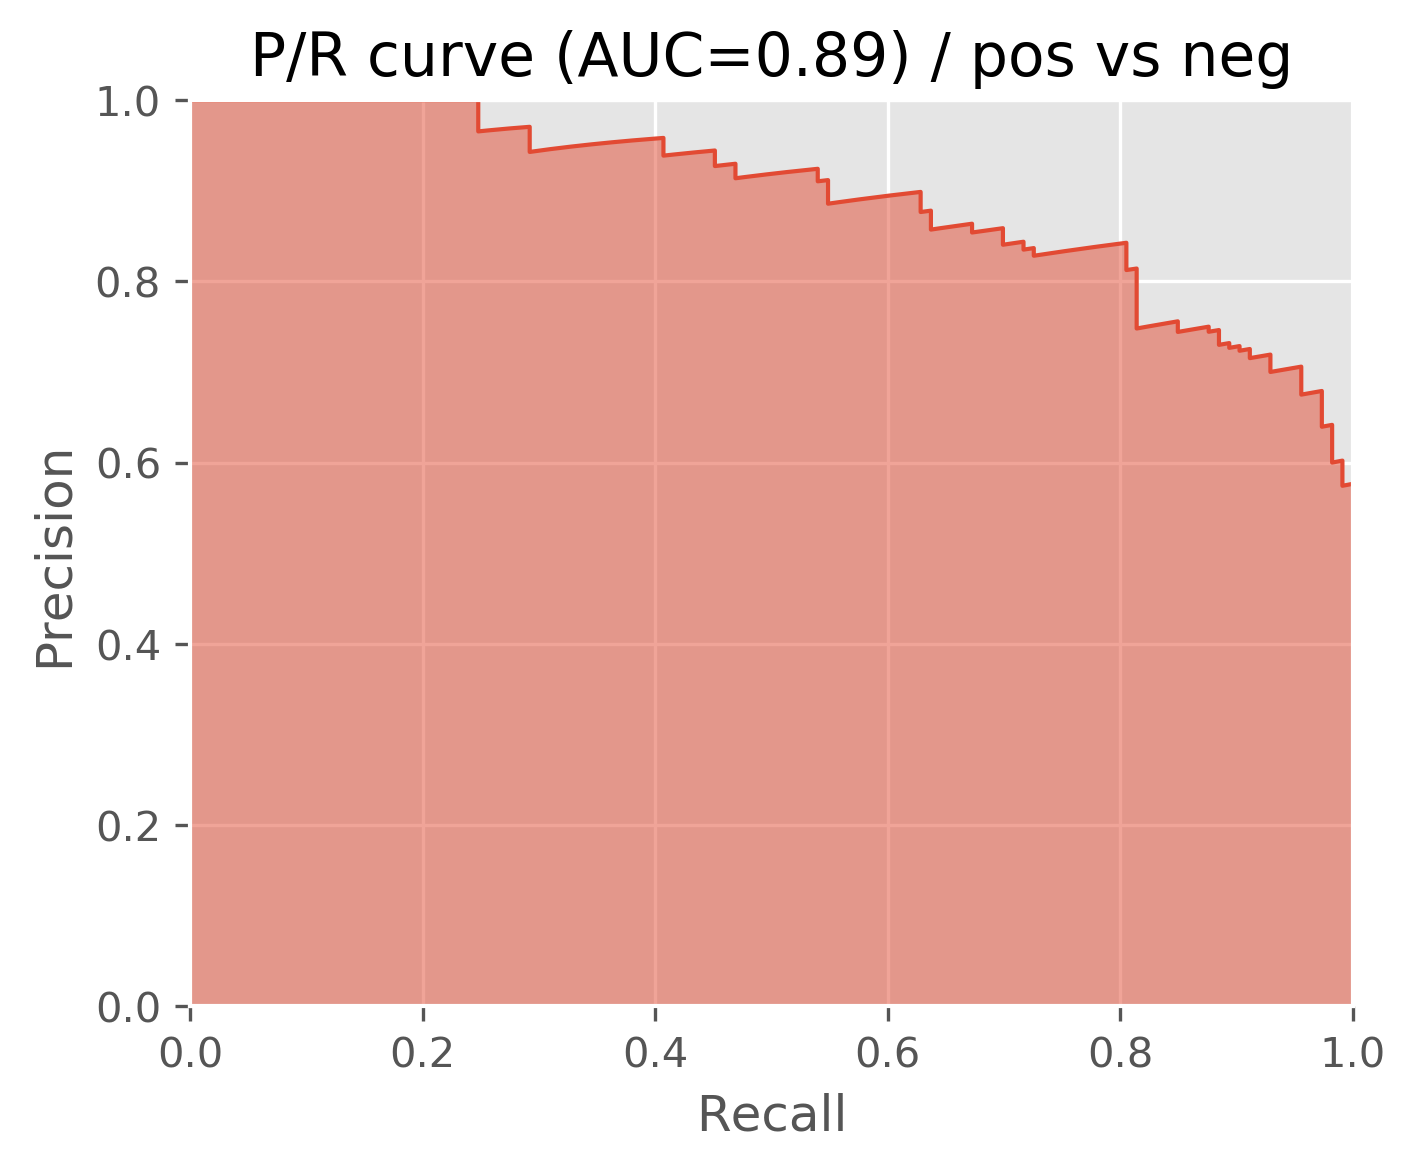

In [30]:
print("== Pos vs. neg ==")
pos_neg = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg]
Y = Y_orig[pos_neg]
Y = tweak_labels(Y, ["positive"])
train_model(lambda: create_ngram_model(best_params), X, Y, name="pos vs neg", plot="5")

== Pos/neg vs. irrelevant/neutral (BEST) ==
Mean acc=0.790	Mean P/R AUC=0.683


(0.0028345724907063441, 0.21007583965330445)

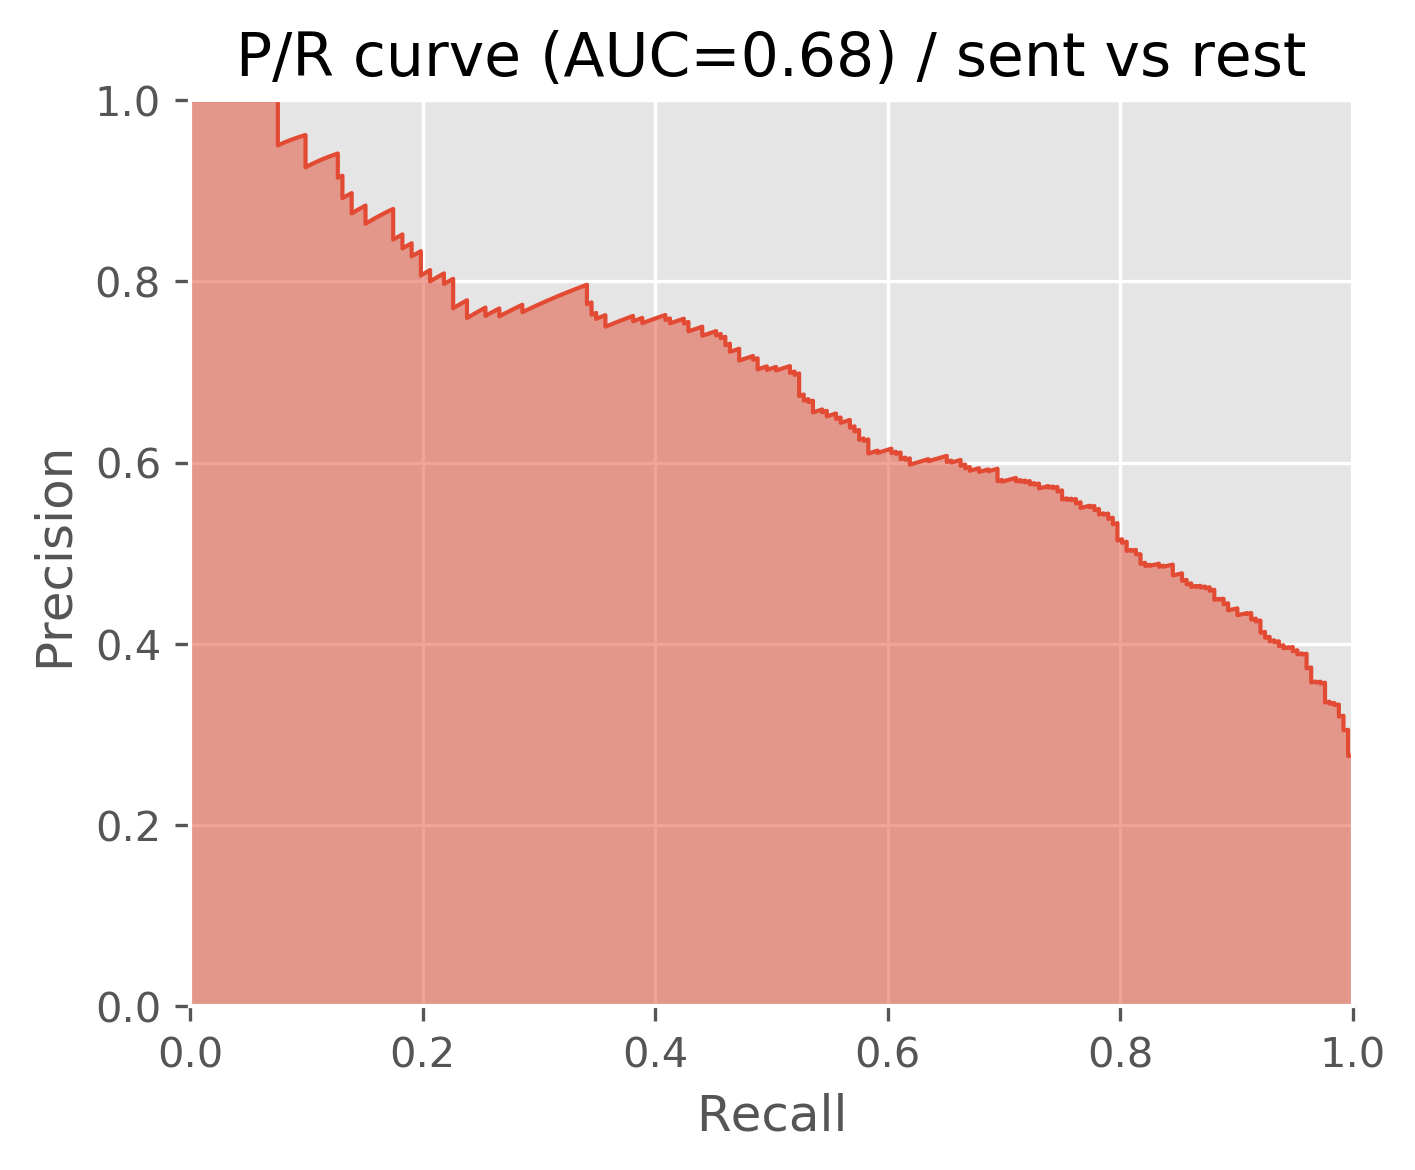

In [31]:
print("== Pos/neg vs. irrelevant/neutral ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
train_model(lambda: create_ngram_model(best_params), X, Y, name="sent vs rest", plot="6")

== Pos vs. rest (BEST) ==
Mean acc=0.885	Mean P/R AUC=0.491


(0.0040427509293680438, 0.11495124593716141)

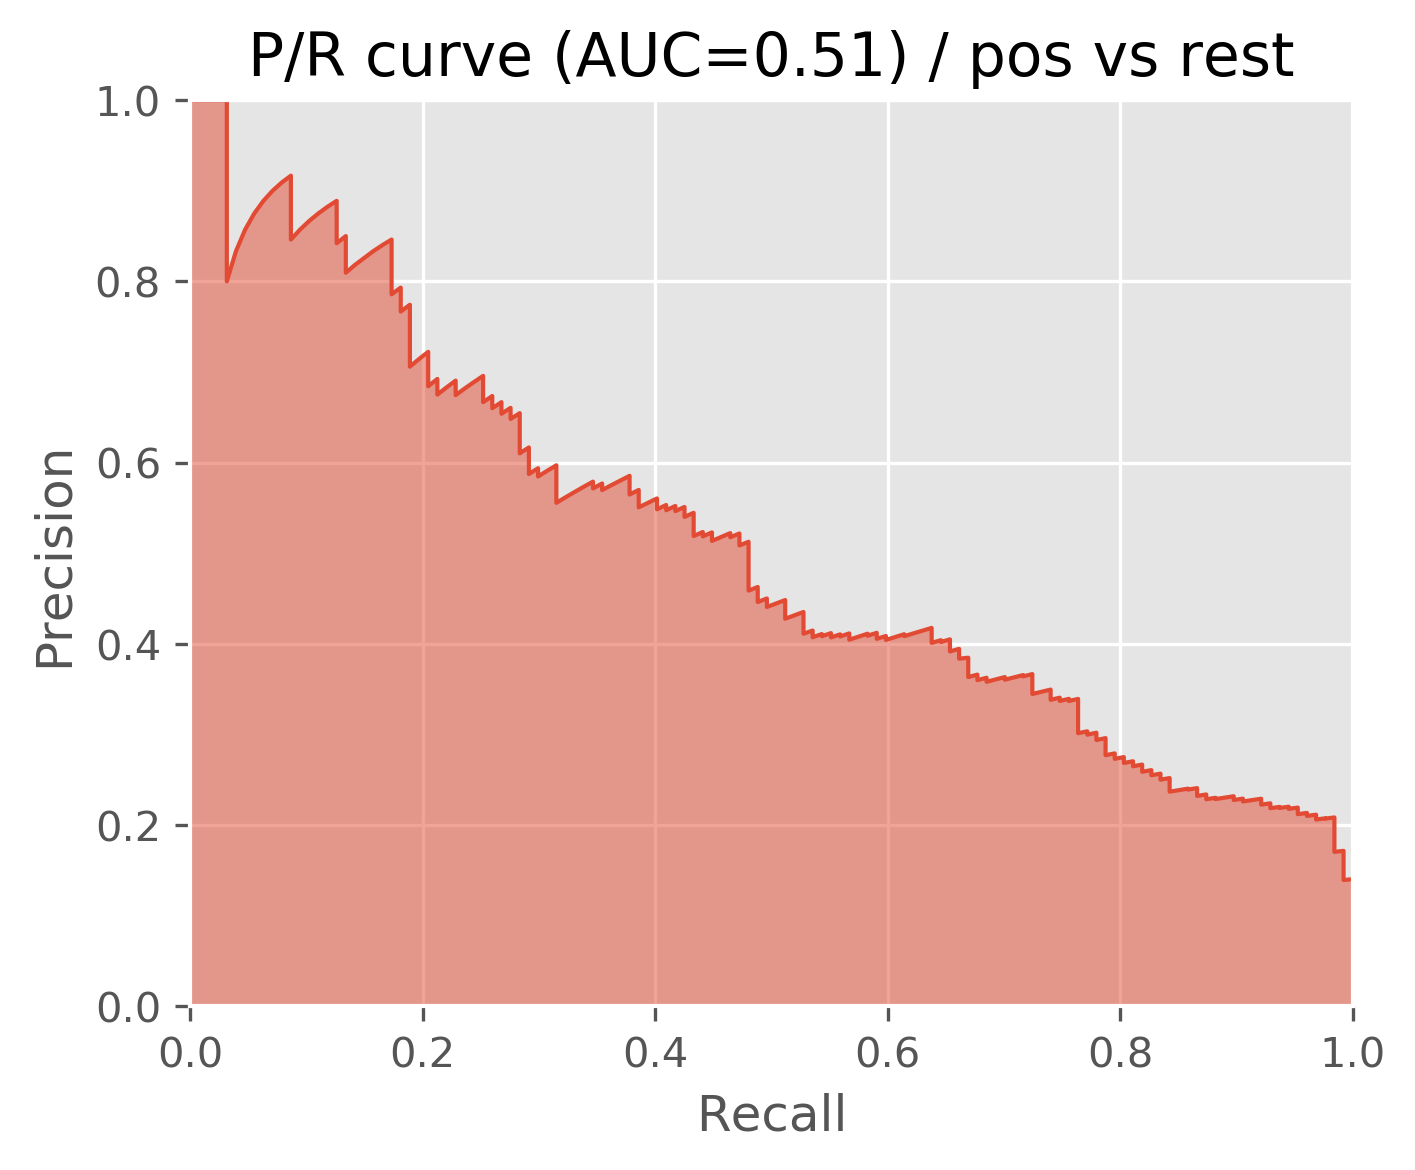

In [32]:
print("== Pos vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])

train_model(lambda: create_ngram_model(best_params), X, Y, name="pos vs rest", plot="7")

== Neg vs. rest (BEST) ==
Mean acc=0.882	Mean P/R AUC=0.621


(0.0013011152416356642, 0.11830985915492957)

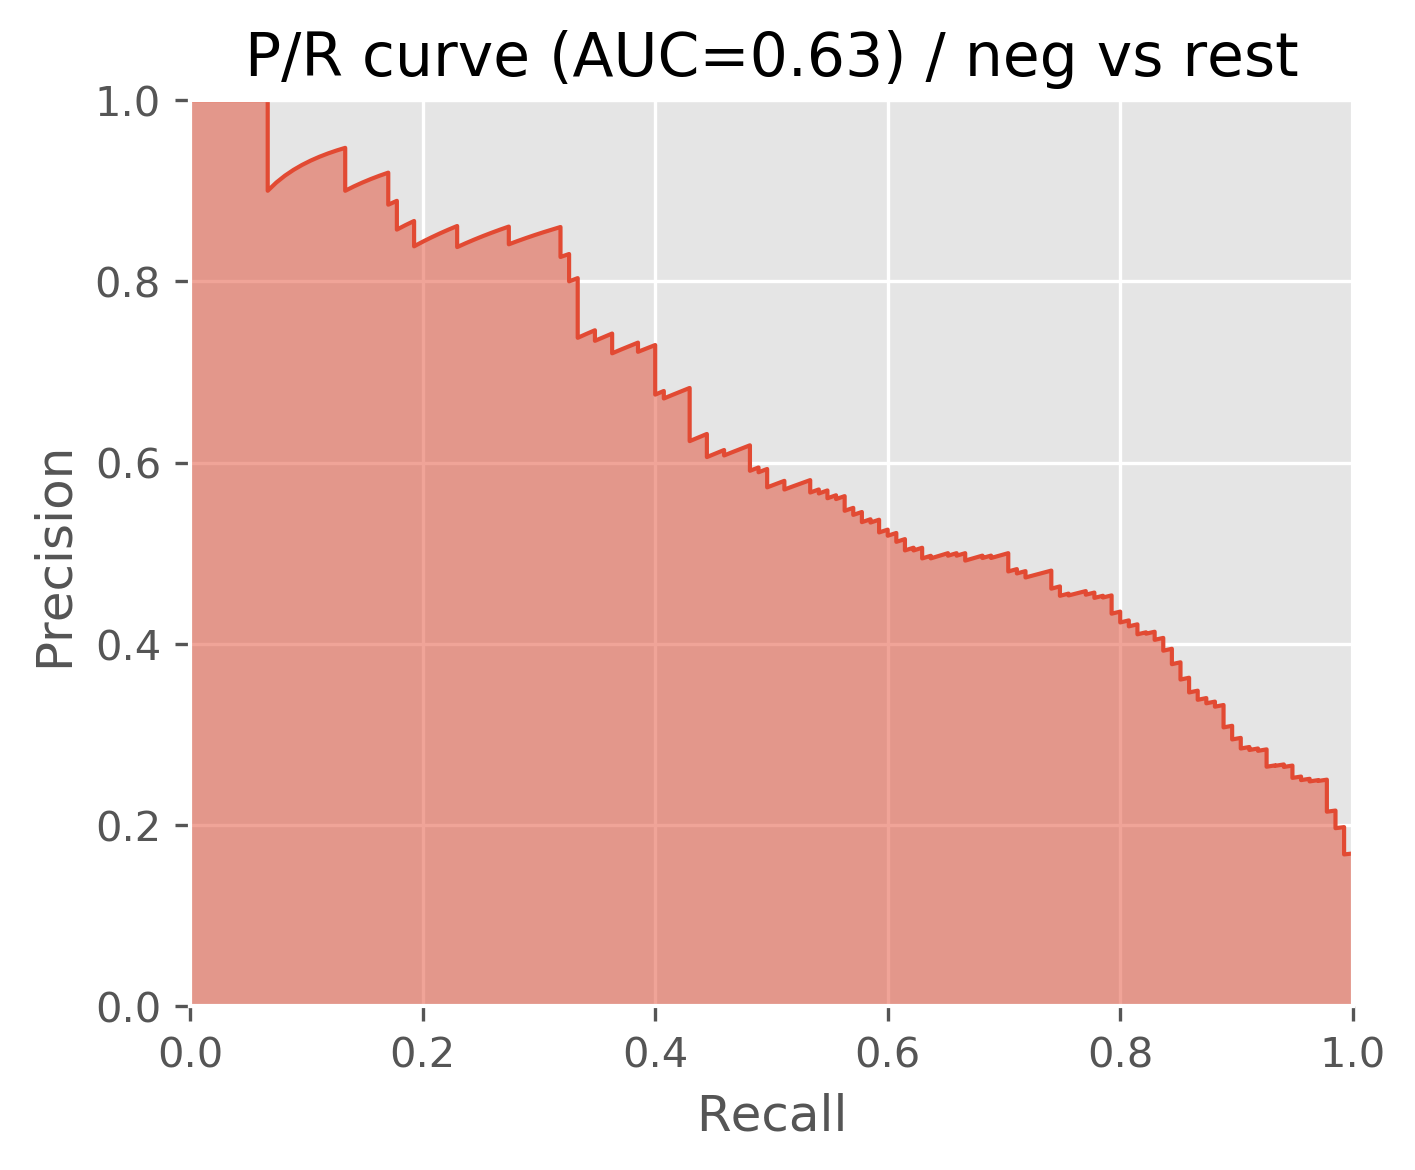

In [33]:
print("== Neg vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])

train_model(lambda: create_ngram_model(best_params), X, Y, name="neg vs rest", plot="8")

# Cleaning tweets

In [34]:
import re

emo_repl = {
    # positive emoticons
    "&lt;3": " good ",
    ":d": " good ", # :D in lower case
    ":dd": " good ", # :DD in lower case
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",

    # negative emoticons:
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":S": " bad ",
    ":-S": " bad ",
    }

# make sure that e.g. :dd is replaced before :d
emo_repl_order = [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]

re_repl = {
r"\br\b": "are",
r"\bu\b": "you",
r"\bhaha\b": "ha",
r"\bhahaha\b": "ha",
r"\bdon't\b": "do not",
r"\bdoesn't\b": "does not",
r"\bdidn't\b": "did not",
r"\bhasn't\b": "has not",
r"\bhaven't\b": "have not",
r"\bhadn't\b": "had not",
r"\bwon't\b": "will not",
r"\bwouldn't\b": "would not",
r"\bcan't\b": "can not",
r"\bcannot\b": "can not",
    }

def create_ngram_model_emoji(params=None):
        
    def preprocessor(tweet):
        tweet = tweet.lower()
        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)

        return tweet

    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor, analyzer="word")
        
    clf = MultinomialNB()
    pipeline = Pipeline([('tfidf', tfidf_ngrams), ('clf', clf)])

    if params:
        pipeline.set_params(**params)
        
    return pipeline

== Pos vs. neg ==
Mean acc=0.808	Mean P/R AUC=0.889


(0.0010238907849829503, 0.1924603174603175)

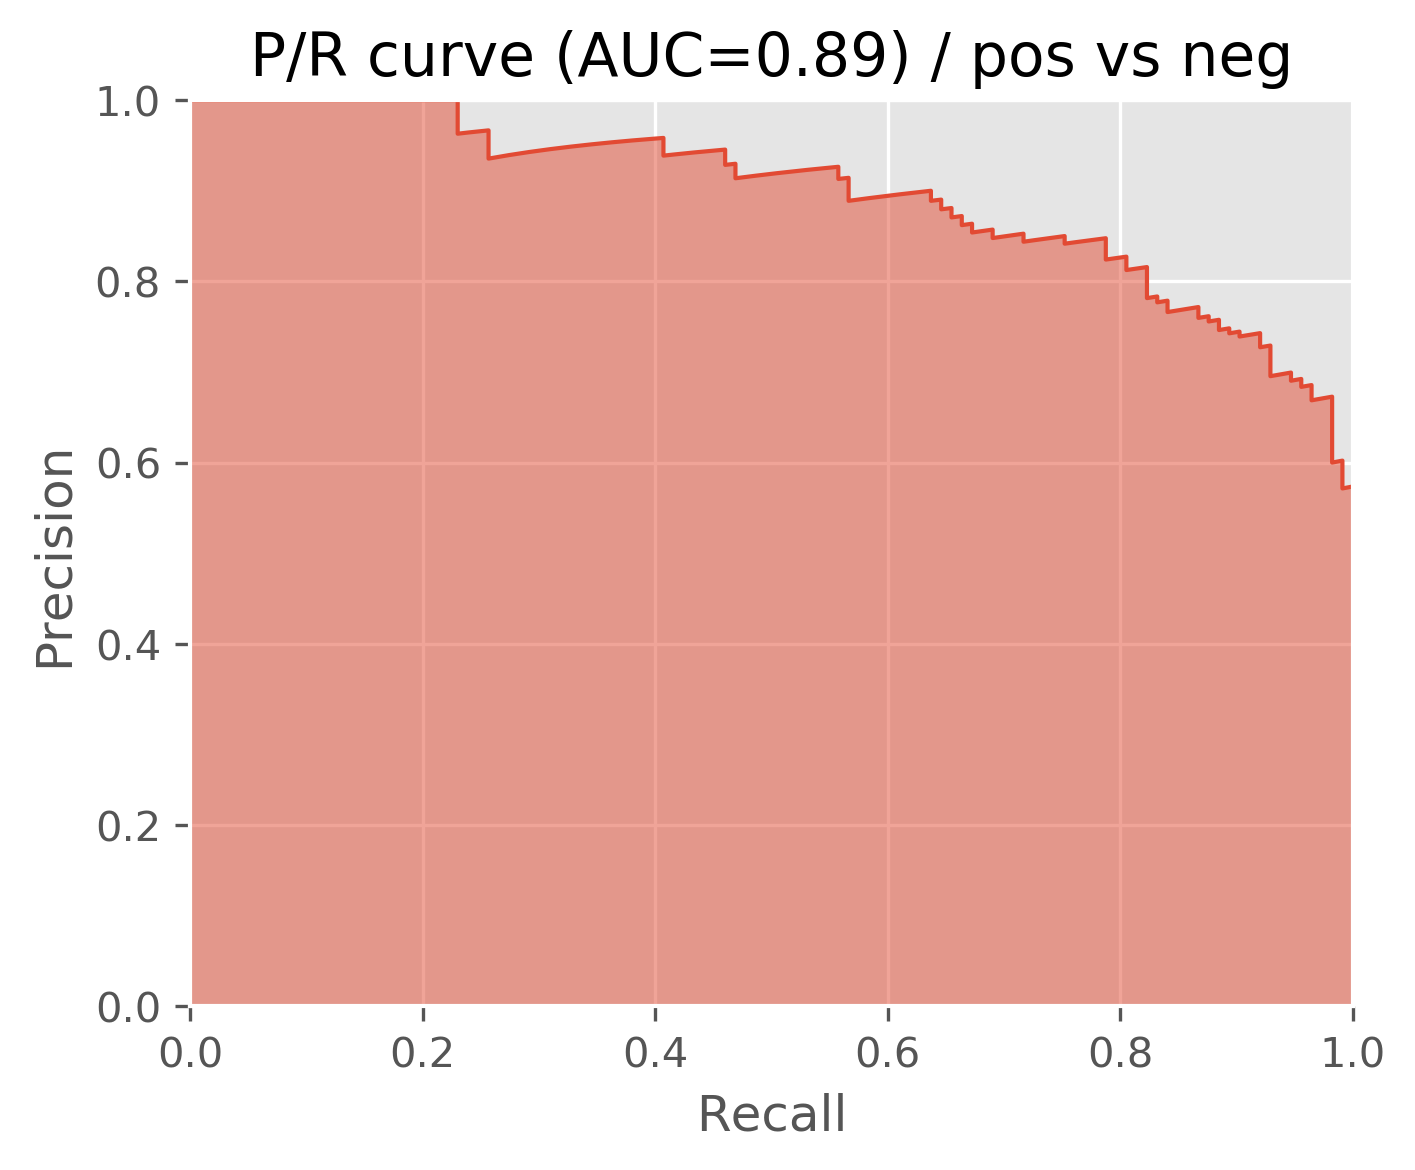

In [35]:
print("== Pos vs. neg ==")
pos_neg = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg]
Y = Y_orig[pos_neg]
Y = tweak_labels(Y, ["positive"])

train_model(lambda: create_ngram_model_emoji(best_params), X, Y, name="pos vs neg", plot="9")

== Pos/neg vs. irrelevant/neutral ==
Mean acc=0.791	Mean P/R AUC=0.689


(0.0026951672862453812, 0.20888407367280606)

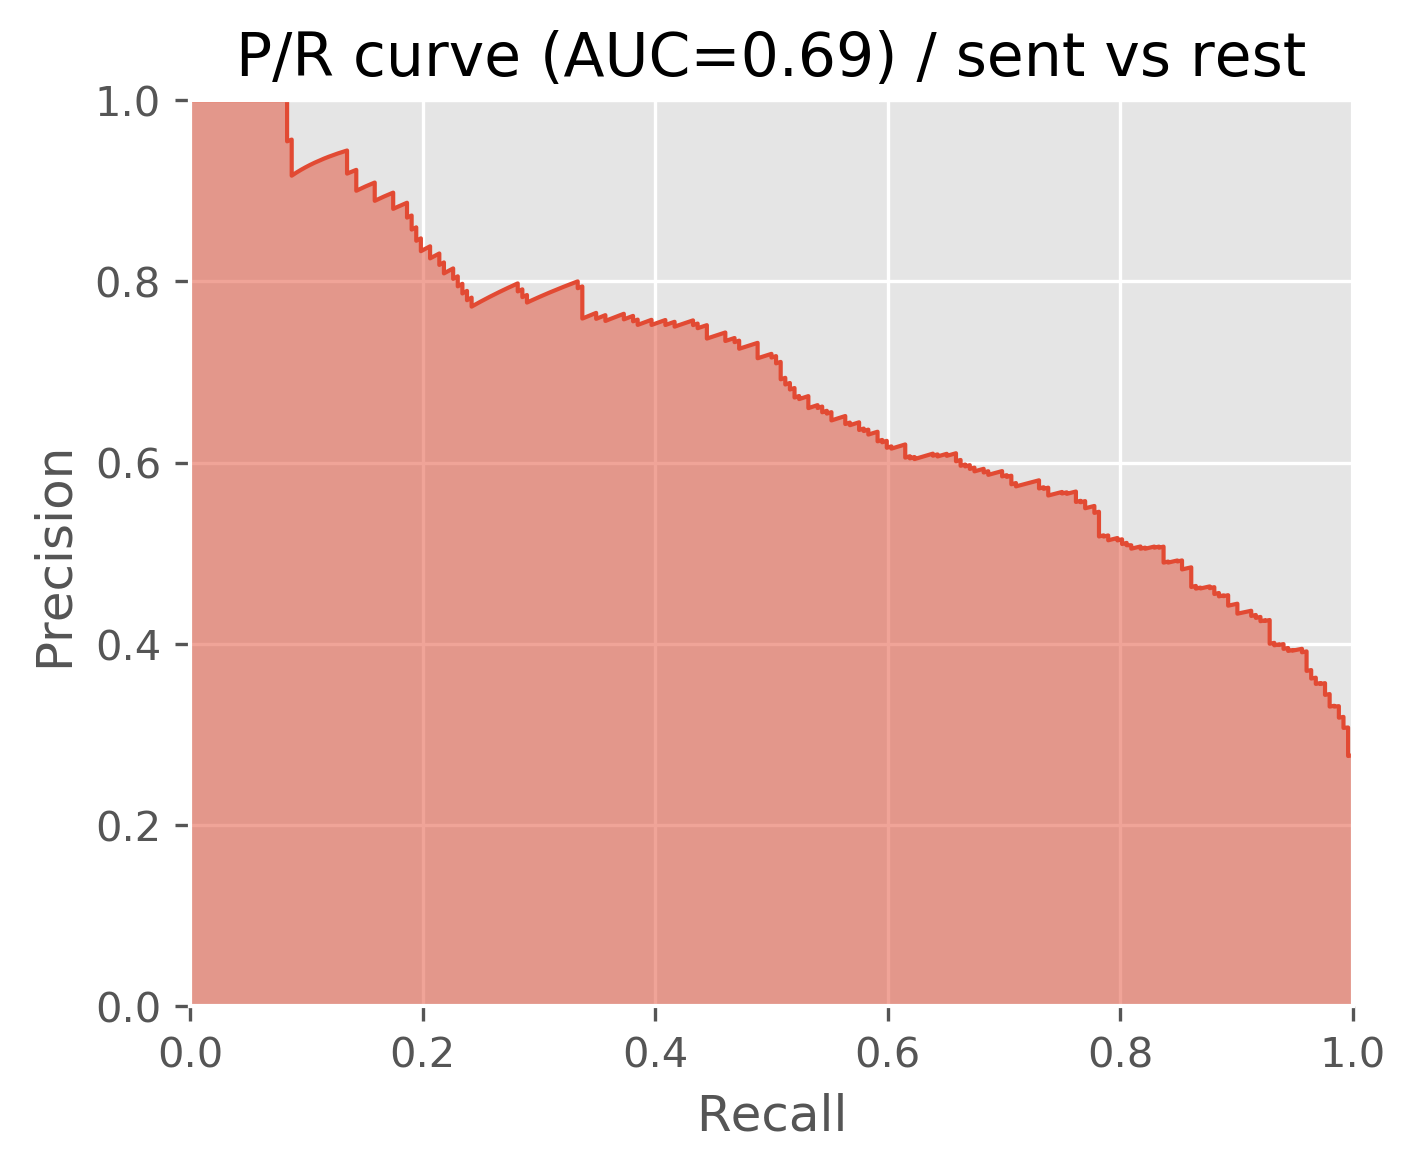

In [36]:
print("== Pos/neg vs. irrelevant/neutral ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
train_model(lambda: create_ngram_model_emoji(best_params), X, Y, name="sent vs rest", plot="10")

== Pos vs. rest ==
Mean acc=0.886	Mean P/R AUC=0.498


(0.00390334572490707, 0.11365113759479957)

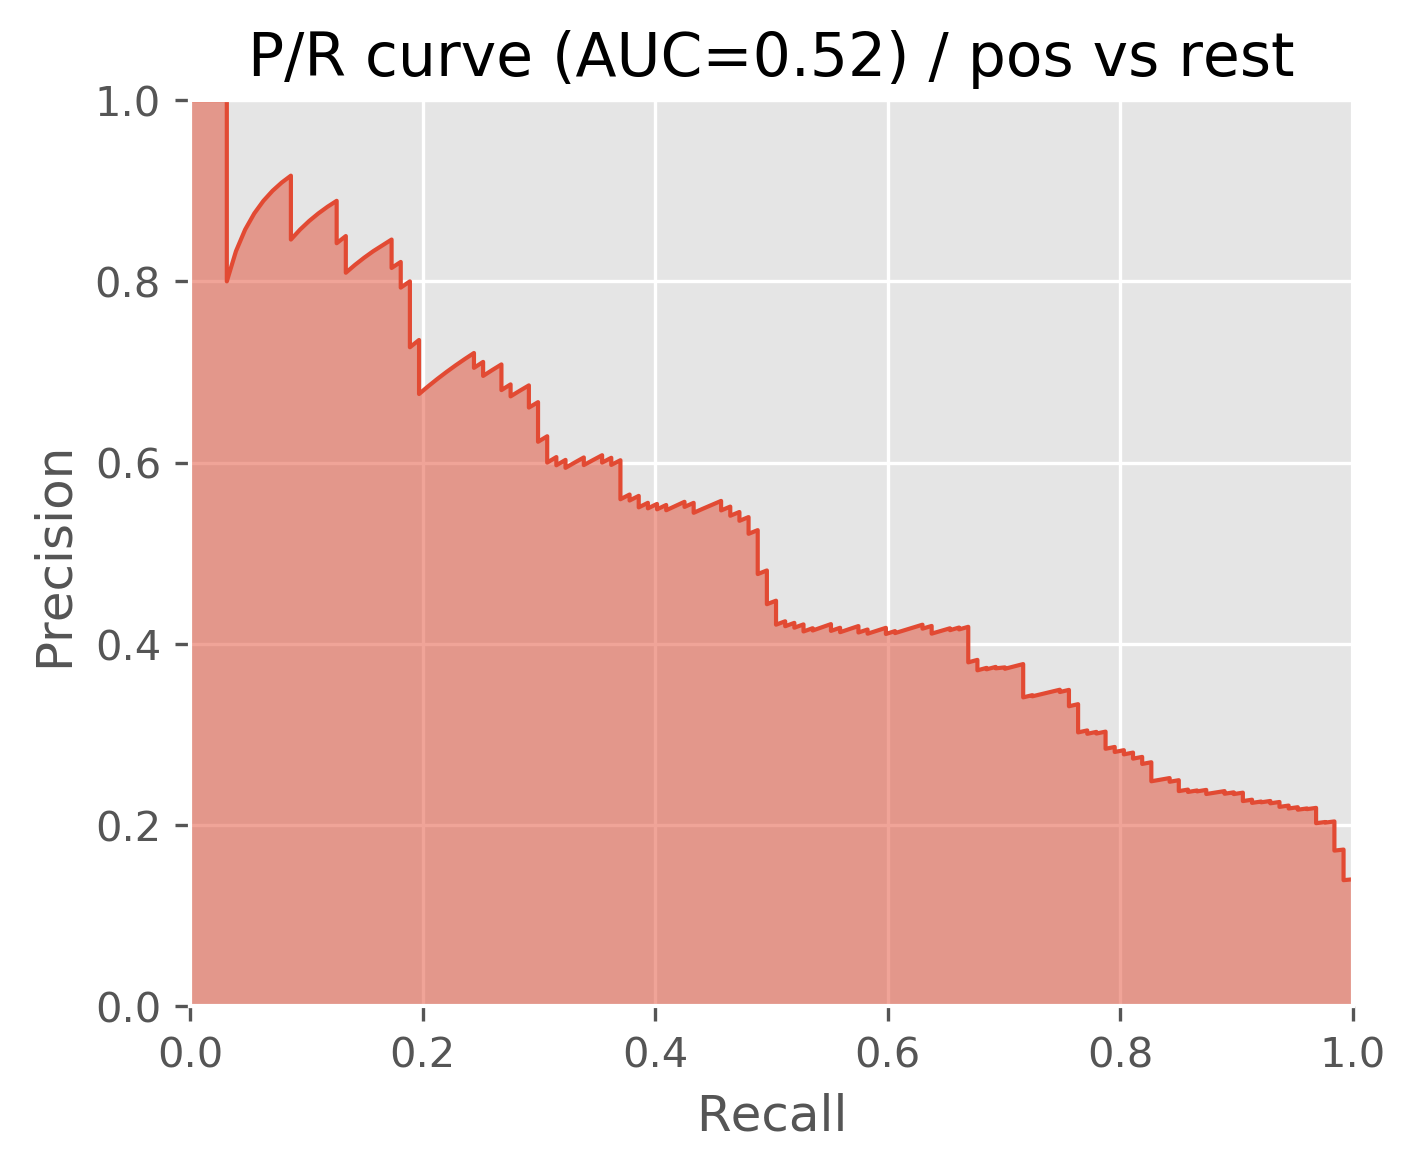

In [37]:
print("== Pos vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])

train_model(lambda: create_ngram_model_emoji(best_params), X, Y, name="pos vs rest", plot="11")

== Neg vs. rest ==
Mean acc=0.883	Mean P/R AUC=0.632


(0.0013475836431226518, 0.11744312026002168)

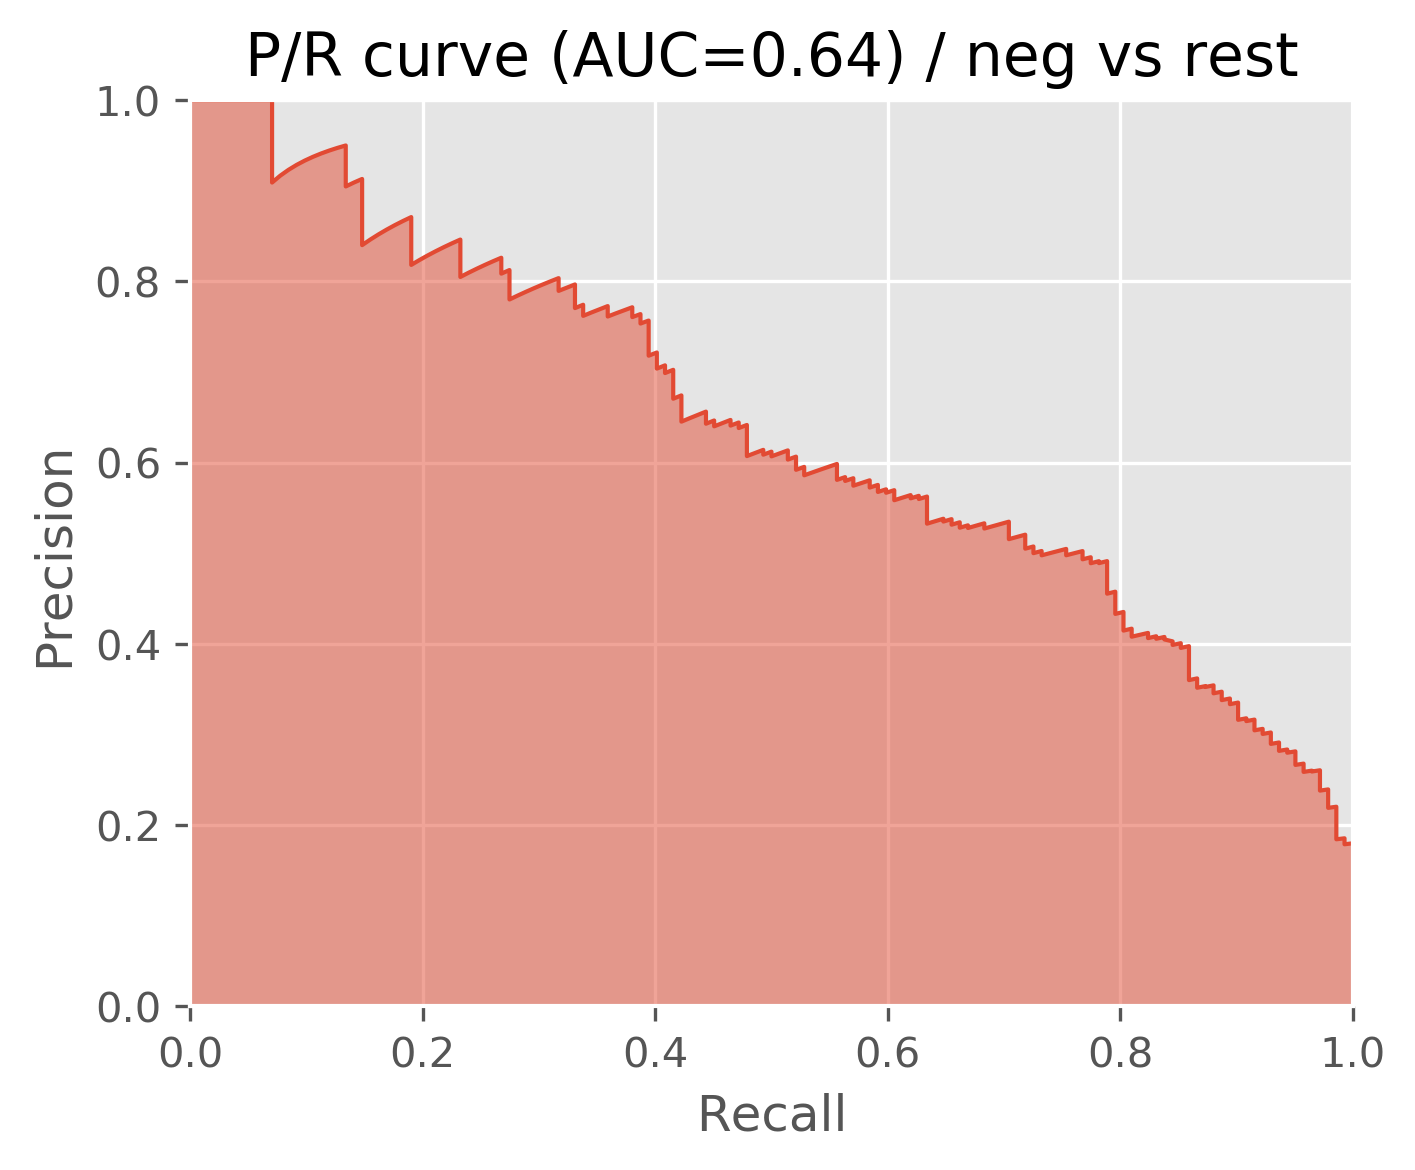

In [38]:
print("== Neg vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])

train_model(lambda: create_ngram_model_emoji(best_params), X, Y, name="neg vs rest", plot="12")

# Using SentiWordNet
For the following, we need to download the SentiWordNet file from http://sentiwordnet.isti.cnr.it, unzip it, and store it as "SentiWordNet_3.0.0_20130122.txt" in the data directory.

In [39]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(nltk.word_tokenize("This is a good book."))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wilrich\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('good', 'JJ'),
 ('book', 'NN'),
 ('.', '.')]

In [40]:
nltk.pos_tag(nltk.word_tokenize("Could you please book the flight?"))

[('Could', 'NNP'),
 ('you', 'PRP'),
 ('please', 'VBP'),
 ('book', 'NN'),
 ('the', 'DT'),
 ('flight', 'NN'),
 ('?', '.')]

In [41]:
import csv, collections

def load_sent_word_net():
    # making our life easier by using a dictionary that
    # automatically creates an empty list whenever we access
    # a not yet existing key
    sent_scores = collections.defaultdict(list)
    
    with open(os.path.join(DATA_DIR, "SentiWordNet_3.0.0_20130122.txt"), "r") as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#"):
                continue
            if len(line)==1:
                continue

            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS)==0 or len(ID)==0:
                continue
            for term in SynsetTerms.split(" "):
                # drop number at the end of every term
                term = term.split("#")[0] 
                term = term.replace("-", " ").replace("_", " ")
                key = "%s/%s"%(POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore), float(NegScore)))

    for key, value in sent_scores.items():
         sent_scores[key] = np.mean(value, axis=0)

    return sent_scores

sent_word_net = load_sent_word_net()

In [42]:
from sklearn.base import BaseEstimator

class LinguisticVectorizer(BaseEstimator):
    def get_feature_names(self):
        return np.array(['sent_neut', 'sent_pos', 'sent_neg',
         'nouns', 'adjectives', 'verbs', 'adverbs',
         'allcaps', 'exclamation', 'question', 'hashtag', 
         'mentioning'])

    # we don't fit here but need to return the reference
    # so that it can be used like fit(d).transform(d)
    def fit(self, documents, y=None):
        return self

    def _get_sentiments(self, d):
        sent = tuple(d.split())
        tagged = nltk.pos_tag(sent)

        pos_vals = []
        neg_vals = []

        nouns = 0.
        adjectives = 0.
        verbs = 0.
        adverbs = 0.

        for w,t in tagged:
            p, n = 0,0
            sent_pos_type = None
            if t.startswith("NN"):
                sent_pos_type = "n"
                nouns += 1
            elif t.startswith("JJ"):
                sent_pos_type = "a"
                adjectives += 1
            elif t.startswith("VB"):
                sent_pos_type = "v"
                verbs += 1
            elif t.startswith("RB"):
                sent_pos_type = "r"
                adverbs += 1

            if sent_pos_type is not None:
                sent_word = "%s/%s" % (sent_pos_type, w)

                if sent_word in sent_word_net:
                    p,n = sent_word_net[sent_word]

            pos_vals.append(p)
            neg_vals.append(n)

        l = len(sent)
        avg_pos_val = np.mean(pos_vals)
        avg_neg_val = np.mean(neg_vals)
        
        result = [1-avg_pos_val-avg_neg_val, avg_pos_val, avg_neg_val, 
                  nouns/l, adjectives/l, verbs/l, adverbs/l]
        
        return result


    def transform(self, documents):
        obj_val, pos_val, neg_val, nouns, adjectives, \
verbs, adverbs = np.array([self._get_sentiments(d) \
for d in documents]).T

        allcaps = []
        exclamation = []
        question = []
        hashtag = []
        mentioning = []

        for d in documents:
            allcaps.append(np.sum([t.isupper() \
                for t in d.split() if len(t)>2]))

            exclamation.append(d.count("!"))
            question.append(d.count("?"))
            hashtag.append(d.count("#"))
            mentioning.append(d.count("@"))

        result = np.array([obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs, allcaps, exclamation, question, 
hashtag, mentioning]).T

        return result


In [43]:
from sklearn.pipeline import FeatureUnion

def create_union_model(params=None):
    def preprocessor(tweet):
        tweet = tweet.lower()

        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)

        return tweet.replace("-", " ").replace("_", " ")

    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor, analyzer="word")
    ling_stats = LinguisticVectorizer()
    all_features = FeatureUnion([('ling', ling_stats), 
                                 ('tfidf', tfidf_ngrams)])
    clf = MultinomialNB()
    pipeline = Pipeline([('all', all_features), ('clf', clf)])

    if params:
        pipeline.set_params(**params)

    return pipeline

In [44]:
best_params = dict(all__tfidf__ngram_range=(1, 2),
                   all__tfidf__min_df=1,
                   all__tfidf__stop_words=None,
                   all__tfidf__smooth_idf=False,
                   all__tfidf__use_idf=False,
                   all__tfidf__sublinear_tf=True,
                   all__tfidf__binary=False,
                   clf__alpha=0.01,
                   )

== Pos vs. neg ==
Mean acc=0.793	Mean P/R AUC=0.882


(0.0010238907849829503, 0.20714285714285716)

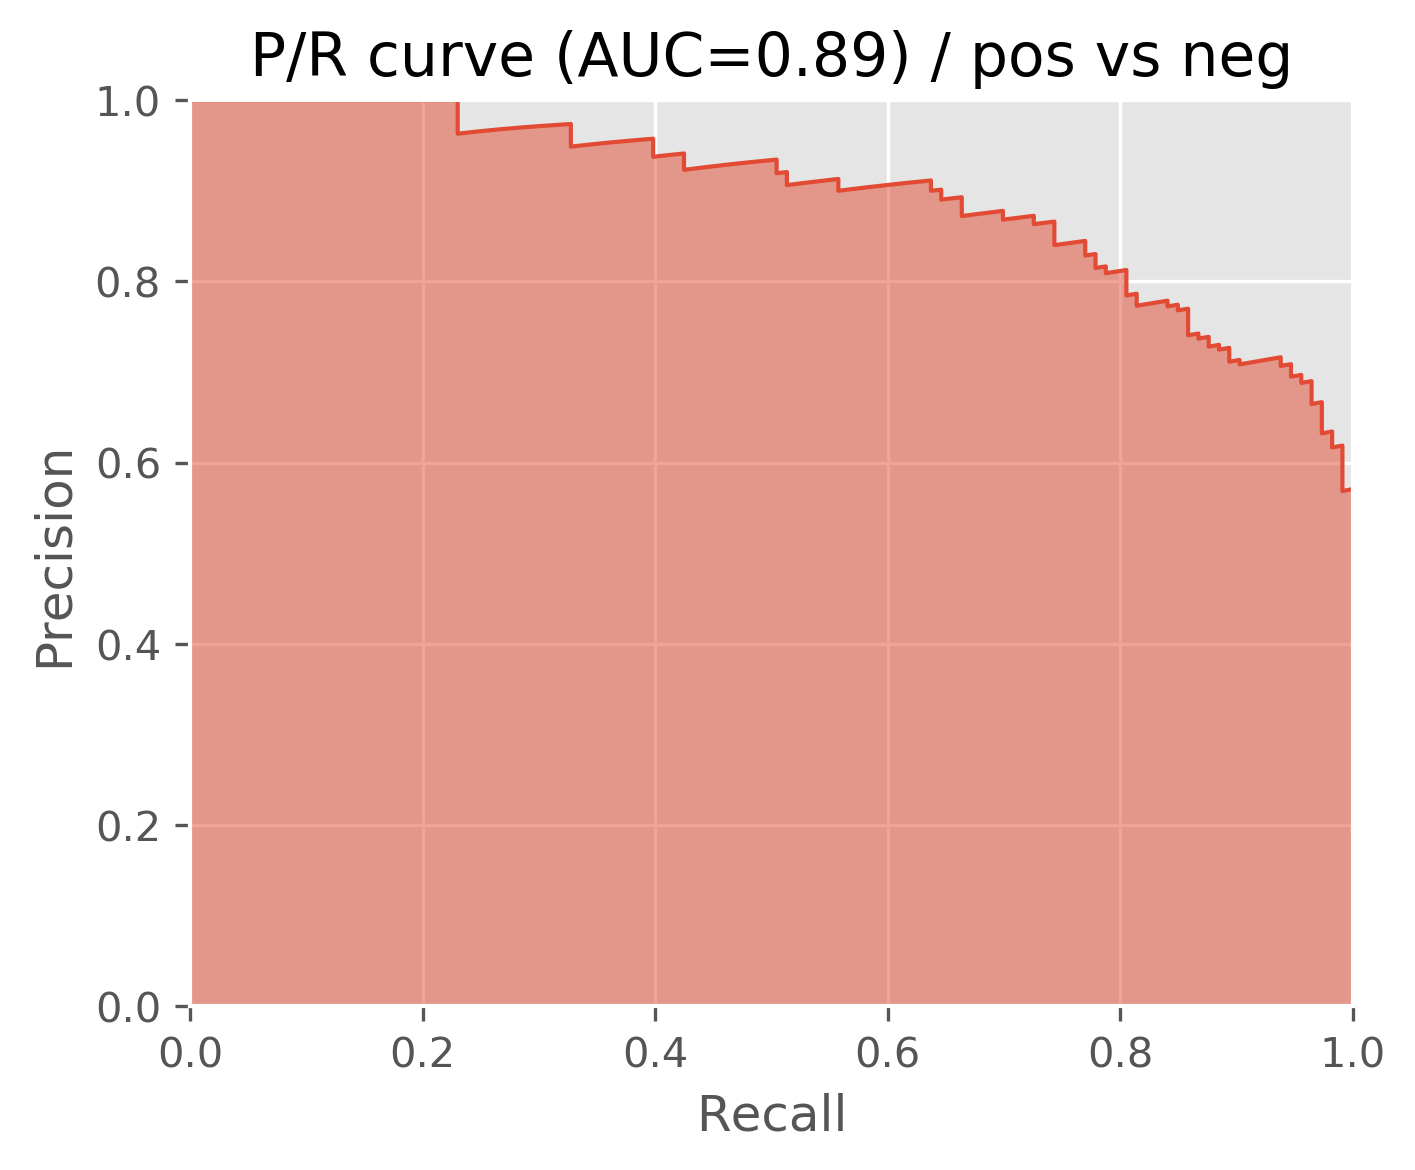

In [45]:
print("== Pos vs. neg ==")
pos_neg = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg]
Y = Y_orig[pos_neg]
Y = tweak_labels(Y, ["positive"])

train_model(lambda: create_union_model(best_params), X, Y, name="pos vs neg", plot="13")

== Pos/neg vs. irrelevant/neutral ==
Mean acc=0.787	Mean P/R AUC=0.688


(0.0030669144981412709, 0.2134344528710726)

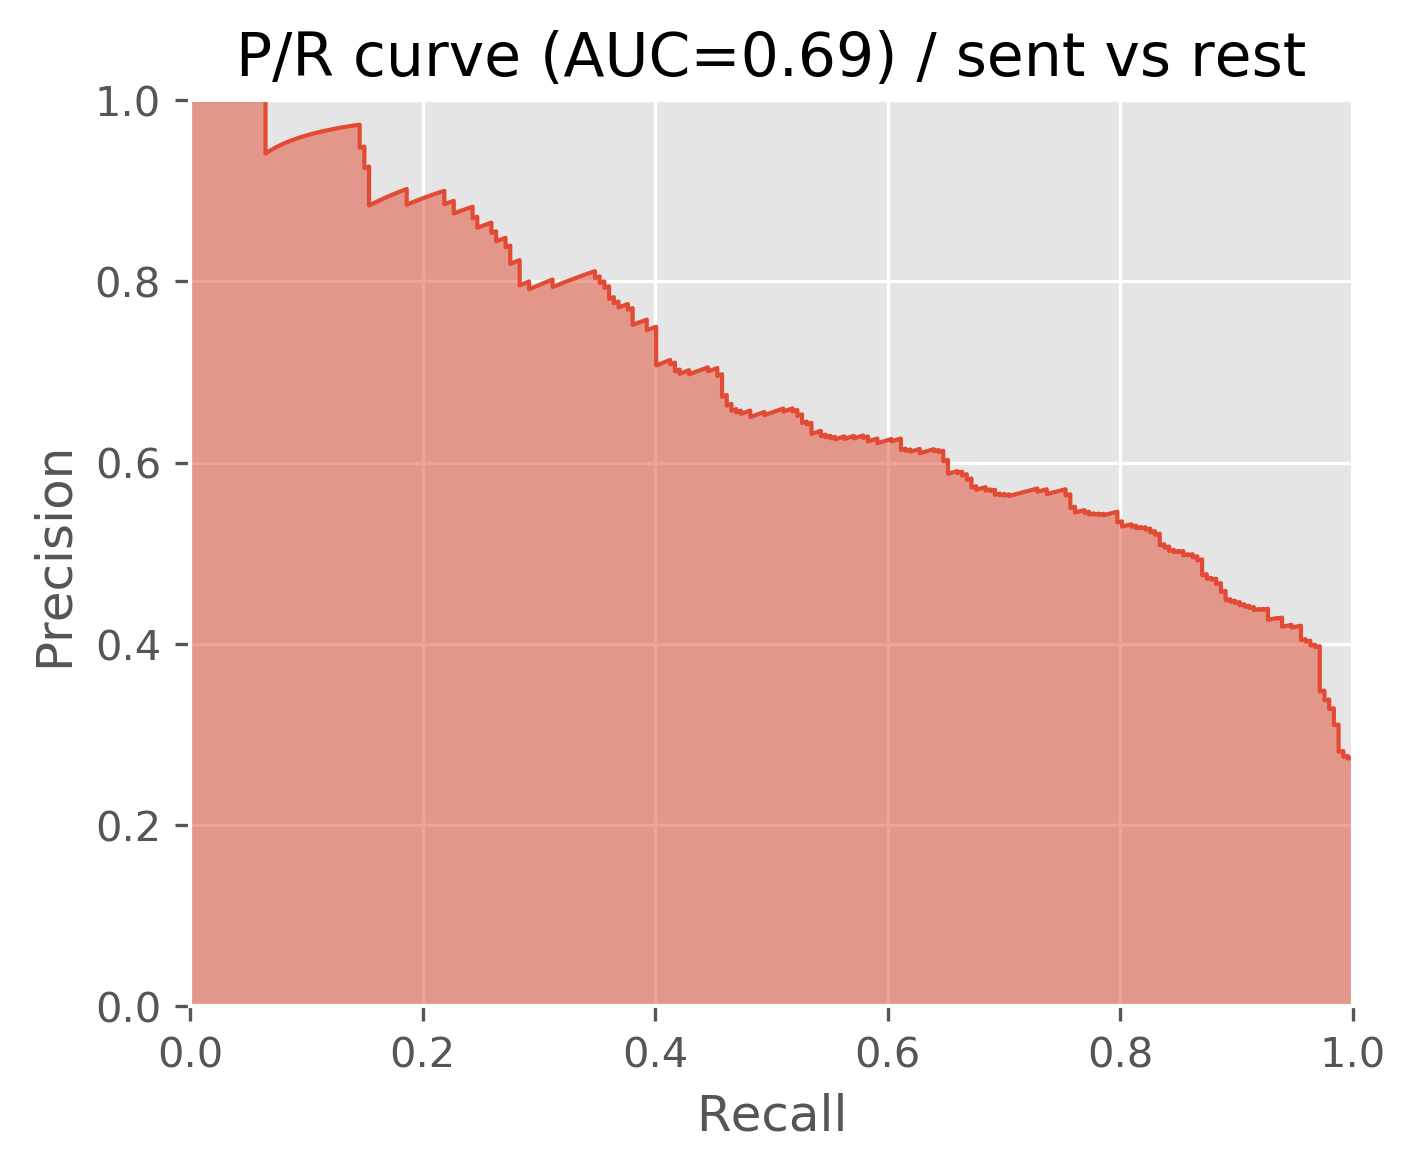

In [46]:
print("== Pos/neg vs. irrelevant/neutral ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
train_model(lambda: create_union_model(best_params), X, Y, name="sent vs rest", plot="14")

== Pos vs. rest ==
Mean acc=0.886	Mean P/R AUC=0.508


(0.0032527881040892324, 0.11365113759479957)

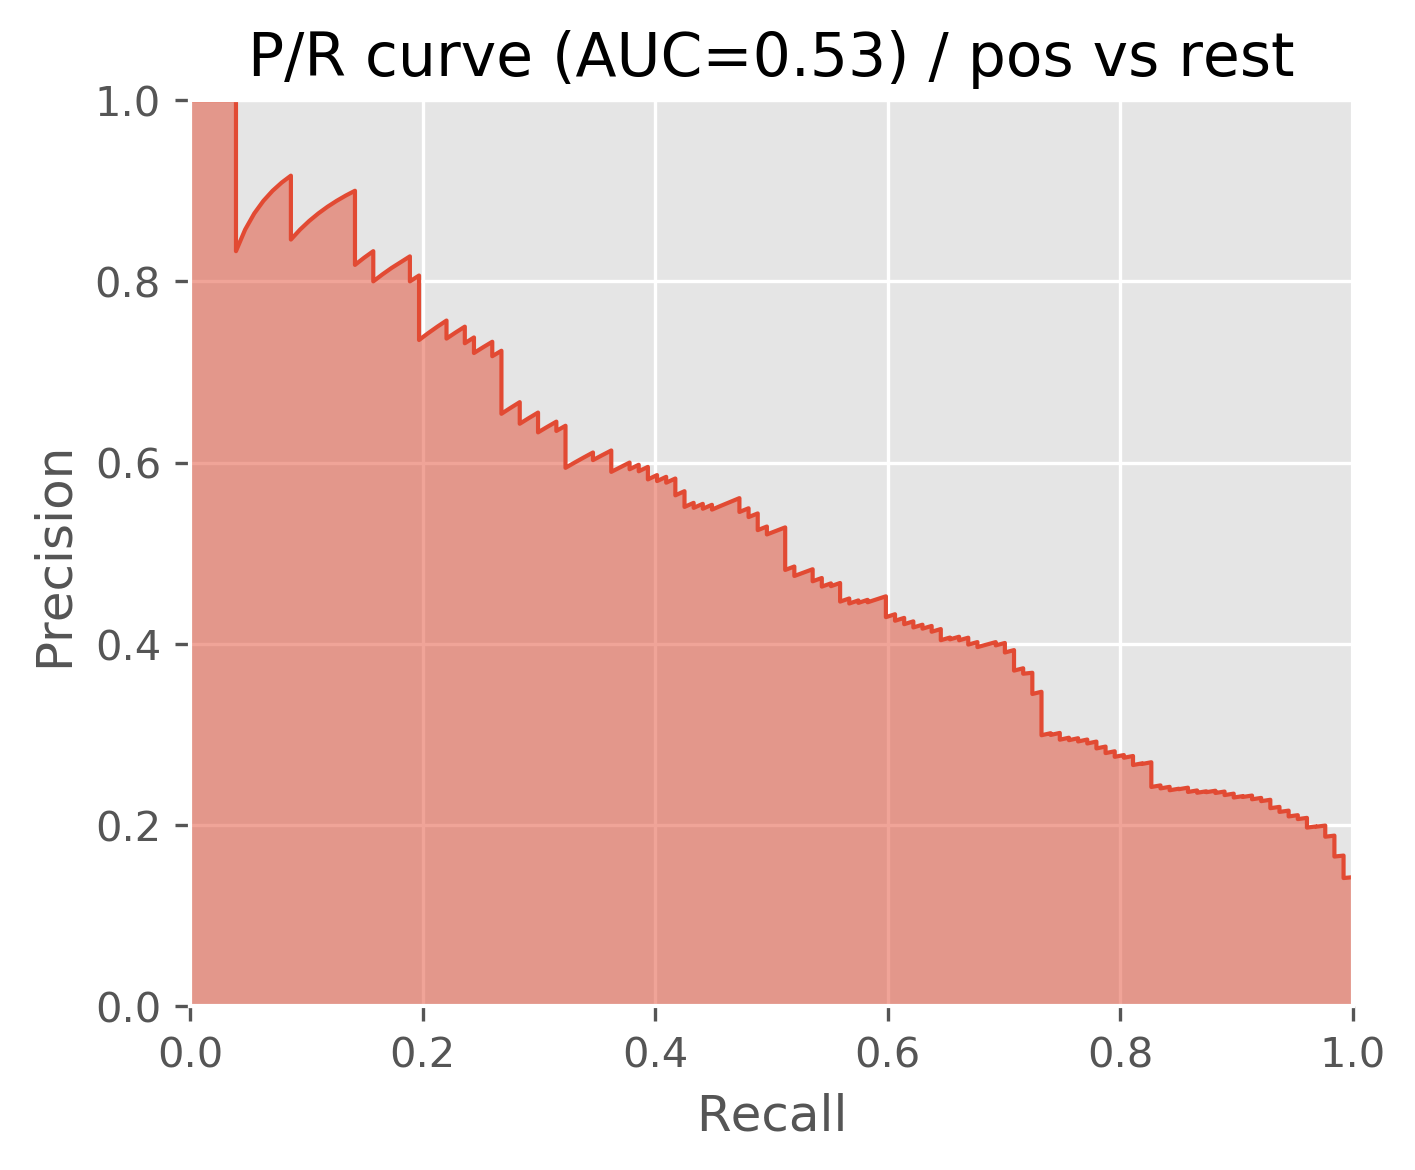

In [47]:
print("== Pos vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])

train_model(lambda: create_union_model(best_params), X, Y, name="pos vs rest", plot="15")

== Neg vs. rest ==
Mean acc=0.876	Mean P/R AUC=0.617


(0.0032992565055762202, 0.12394366197183097)

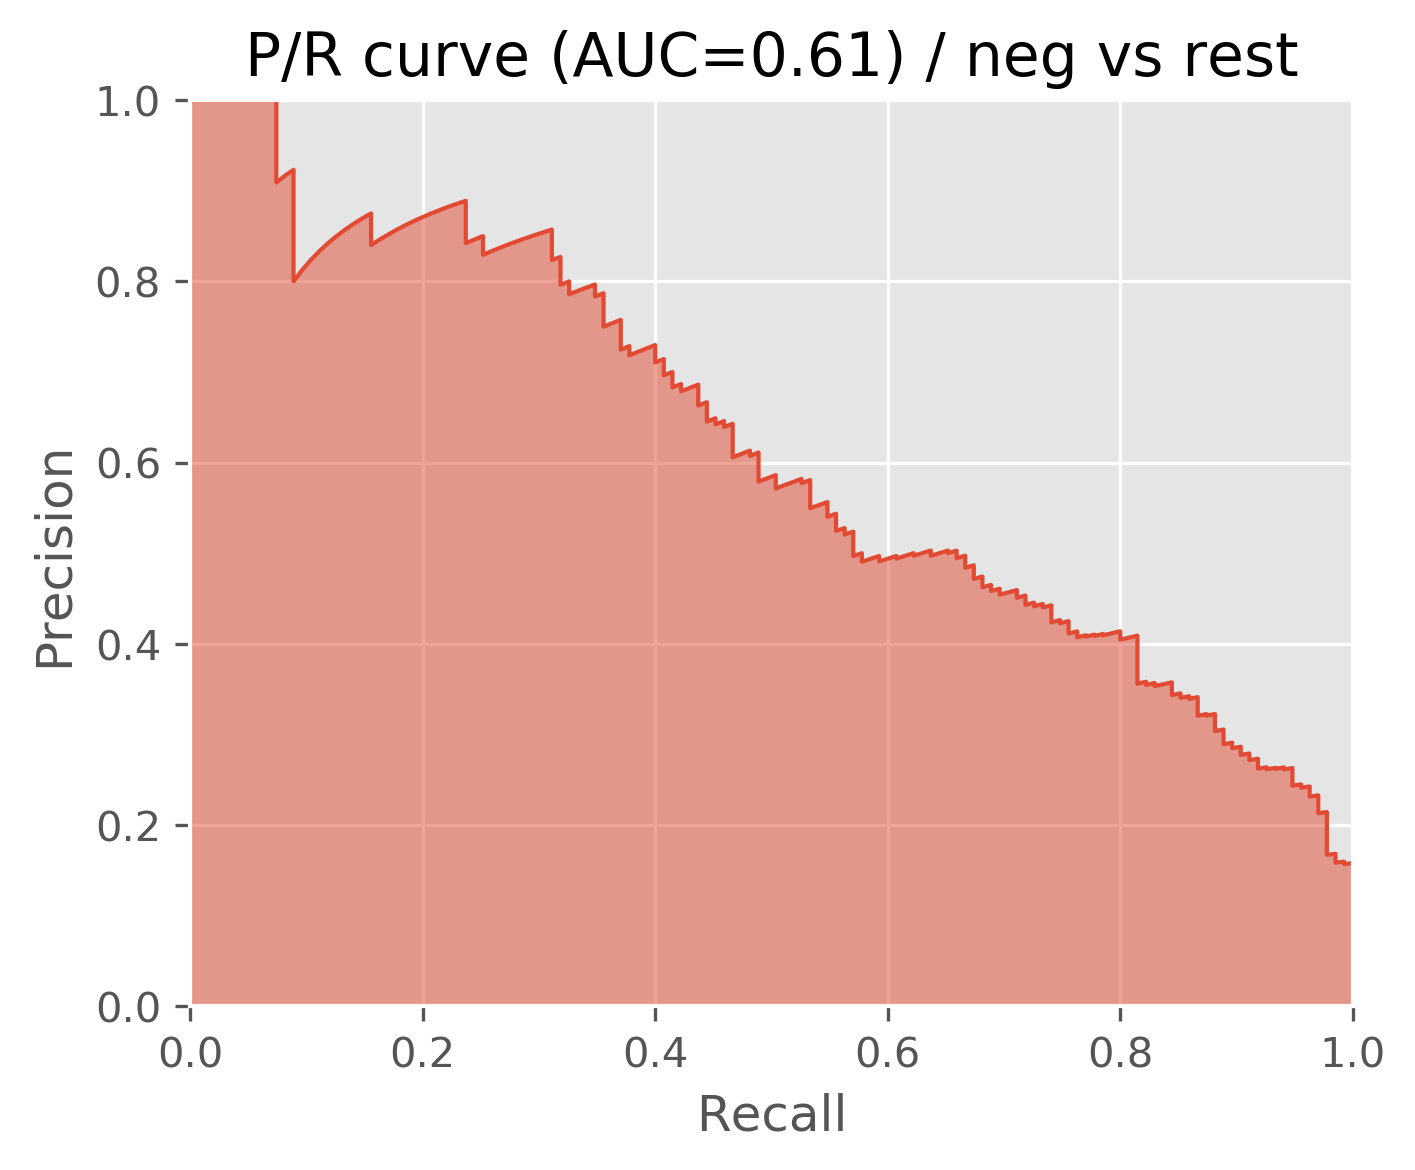

In [48]:
print("== Neg vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])

train_model(lambda: create_union_model(best_params), X, Y, name="neg vs rest", plot="16")